In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import os
from mpl_toolkits.mplot3d import Axes3D

from numpy import linalg as LA
from scipy.spatial import Delaunay

import cv2
import csv
import time

from generalizations import *

from sklearn.neighbors import NearestNeighbors
from info3d import *

In [10]:
# Getting the path to the Raw point clouds

OBJ_DIR = 'point_clouds/'

# Format is a tuple of (file path, file name).
OBJ_PATHS = [ [os.path.join(OBJ_DIR, f), f]
                    for f in os.listdir(OBJ_DIR) ]

OBJ_PATHS

[['point_clouds/Reception-Data61-L5.obj', 'Reception-Data61-L5.obj'],
 ['point_clouds/.DS_Store', '.DS_Store'],
 ['point_clouds/Driveway.obj', 'Driveway.obj'],
 ['point_clouds/Apartment.obj', 'Apartment.obj'],
 ['point_clouds/Workstations-Data61-L4.obj', 'Workstations-Data61-L4.obj'],
 ['point_clouds/Kitchen-Data61-L4.obj', 'Kitchen-Data61-L4.obj'],
 ['point_clouds/HallWayToKitchen-Data61-L4.obj',
  'HallWayToKitchen-Data61-L4.obj'],
 ['point_clouds/StairWell-Data61-L4.obj', 'StairWell-Data61-L4.obj']]

# Extracting the points, normals, and triangles

In [11]:
new_point_collection = []

new_all_point_collection = []

combining_radius = 2.5

for path, filename in OBJ_PATHS:
    
    pointCloudFile = open(path)#'point_cloud.obj')('SpatialMesh.obj')#

    pointCloudLines = pointCloudFile.readlines()
    
    pointCollection = [] # object_number, vertices, vertex normals, polygons

    pointCollection_no_objects = [[],[],[]] 
    prev_length = 0
    vertices_length = 1
    
    for line in pointCloudLines:

        if line == '\n': continue

        line_items = line.split()

        if line_items[0] == 'o':
            object_item = line_items[1].split('.')
            object_number = int(object_item[-1])
            pointCollection.append([object_number, [], [], []])
            vertices_length += prev_length

            #print(object_number)

        if line_items[0] == 'v':
            x = line_items[1]
            y = line_items[2]
            z = line_items[3]
            if len(line_items)> 4:
                c = line_items[4]
                if float(c) > 0.85:
                    pointCollection[object_number-1][1].append([float(x),float(y),float(z),float(c)])
                    pointCollection_no_objects[0].append([float(x),float(y),float(z),float(c)])
            else:
                pointCollection[object_number-1][1].append([float(x),float(y),float(z)])
                pointCollection_no_objects[0].append([float(x),float(y),float(z)])
            prev_length = len(pointCollection[object_number-1][1])


        if line_items[0] == 'vn':
            x = line_items[1]
            y = line_items[2]
            z = line_items[3]
            pointCollection[object_number-1][2].append([float(x),float(y),float(z)])
            pointCollection_no_objects[1].append([float(x),float(y),float(z)])

        if line_items[0] == 'f':
            p1 = int(line_items[1].split('//')[0])
            p2 = int(line_items[2].split('//')[0])
            p3 = int(line_items[3].split('//')[0])
            pointCollection[object_number-1][3].append([p1-vertices_length,
                                                        p2-vertices_length,
                                                        p3-vertices_length])
            pointCollection_no_objects[2].append([p1-1,p2-1,p3-1])        

    pointCloudFile.close
    print(filename)
    #print(" Length of point collection",len(pointCollection[1][1]))
    print(" Total number of point collections",len(pointCollection))
    
    #Combining objects: 1. Getting centroids
    centroids = []

    for object_name, pointCloud, _vn, triangles in pointCollection:
        pointCloud = np.asarray(pointCloud)
        triangles = np.asarray(triangles)#-vertices_length
        normals = np.asarray(_vn)
        
        centroids.append([object_name,
              np.mean(pointCloud[:,0]), # x-axis
              np.mean(pointCloud[:,2]), # z-axis
             ])
        
    centroids = np.asarray(centroids)
    remaining_centroids = np.copy(centroids)
    
    combinedPointCollection = []
    count = 1
    
    while(remaining_centroids.size!=0):
        #print("  ",remaining_centroids[0,0],remaining_centroids.shape)
        #focusing on the first remaining collection, i.e. through its centroid
        collection = np.where(LA.norm(remaining_centroids[:,1:] - remaining_centroids[0,1:], axis = 1)<combining_radius)[0]
        
        #print("  ",collection)
        
        pointCloud = np.asarray(pointCollection[int(remaining_centroids[collection[0],0]-1)][1])
        normals = np.asarray(pointCollection[int(remaining_centroids[collection[0],0])-1][2])
        triangles = np.asarray(pointCollection[int(remaining_centroids[collection[0],0])-1][3])

        for index in collection[1:]:
            
            n_pointCloud = np.asarray(pointCollection[int(remaining_centroids[index,0])-1][1])
            n_normals = np.asarray(pointCollection[int(remaining_centroids[index,0])-1][2])
            n_triangles = np.asarray(pointCollection[int(remaining_centroids[index,0])-1][3])+len(pointCloud)

            pointCloud = np.concatenate((pointCloud,n_pointCloud),0)
            normals = np.concatenate((normals,n_normals),0)
            triangles = np.concatenate((triangles,n_triangles),0)

        combinedPointCollection.append([
            pointCloud,
            normals,
            triangles])
        
        new_all_point_collection.append([
            filename+str(count),
            pointCloud,
            normals,
            triangles])
            
        count += 1
        remaining_centroids = np.delete(remaining_centroids,collection,axis=0)
        #print("   post",remaining_centroids.shape)
        
    print(" Resulting number =",len(combinedPointCollection))
    new_point_collection.append([
        filename,
        combinedPointCollection
    ])

print(len(new_all_point_collection),"total spaces.")

Reception-Data61-L5.obj
 Total number of point collections 37
 Resulting number = 11


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x86 in position 23: invalid start byte

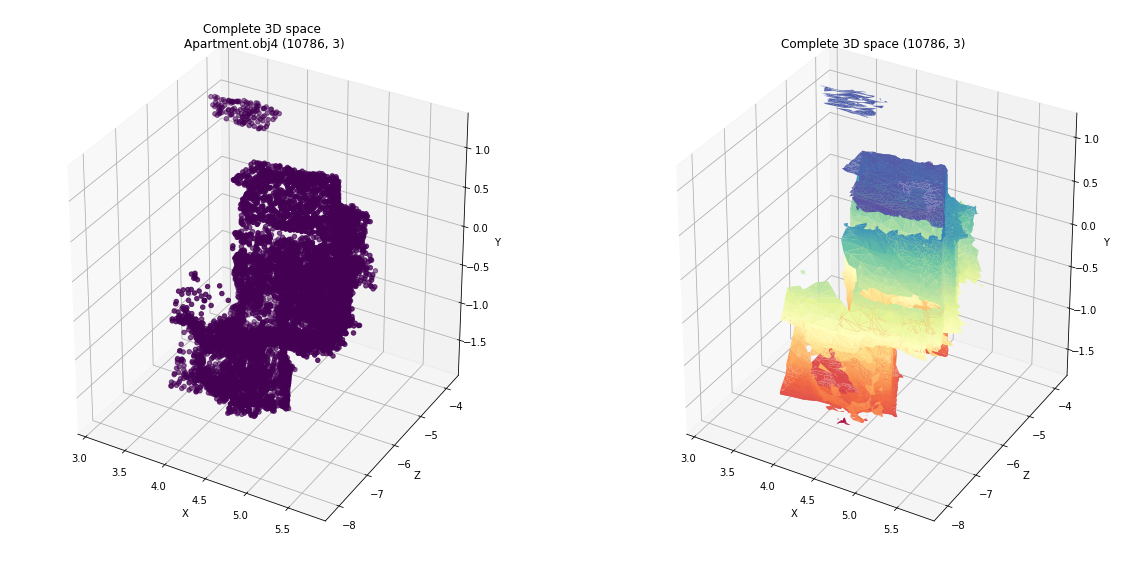

In [128]:
#fig=plt.figure()#
fig=plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121, projection='3d')

space = 25

pointCloud = np.asarray(new_all_point_collection[space][1])
triangles = np.asarray(new_all_point_collection[space][3])

X = pointCloud[:,0]
Y = pointCloud[:,1]
Z = pointCloud[:,2]
#vertices_length += len(X)
ax1.scatter(X,-Z,Y, c = 3*np.ones(pointCloud.shape[0]))
#color = (object_name%256,object_name%127,object_name%63)
#print(object_name,len(X),triangles.min(),triangles.max())

#ax.plot_trisurf(X, -Z, Y, triangles=triangles, cmap=plt.cm.Spectral)
        
ax1.set_xlabel('X')
ax1.set_ylabel('Z')
ax1.set_zlabel('Y')
ax1.set_title('Complete 3D space \n'+new_all_point_collection[space][0]+' '+str(pointCloud.shape))

# Add a colorbar
#fig.colorbar(im, ax=ax)

ax2 = fig.add_subplot(122, projection='3d')

#ax1.scatter(X,-Z,Y, c = object_name*3*np.ones(pointCloud.shape[0]))
#color = (object_name%256,object_name%127,object_name%63)
#print(object_name,len(X),triangles.min(),triangles.max())

ax2.plot_trisurf(X, -Z, Y, triangles=triangles, cmap=plt.cm.Spectral)
        
ax2.set_xlabel('X')
ax2.set_ylabel('Z')
ax2.set_zlabel('Y')
ax2.set_title('Complete 3D space '+str(pointCloud.shape))

# set the color limits - not necessary here, but good to know how.
#im.set_clim(0.0, 1.0)

plt.show()

In [101]:
print("Mean",np.mean(pointCloud,axis = 0))
print("Max",np.amax(pointCloud,axis = 0))
print("Min",np.amin(pointCloud,axis = 0))
print("Median",np.median(pointCloud,axis = 0))

print("Split median",(np.amax(pointCloud,axis = 0)+np.median(pointCloud,axis = 0))/2)
print("Split median",(np.amin(pointCloud,axis = 0)+np.median(pointCloud,axis = 0))/2)

Mean [ 2.16713043 -0.47515497  2.14329555]
Max [4.91996637 1.76157783 5.35070268]
Min [-1.28309343 -1.15620022 -1.44918812]
Median [ 2.23895602 -0.4588029   2.26891092]
Split median [3.57946119 0.65138747 3.8098068 ]
Split median [ 0.47793129 -0.80750156  0.4098614 ]


In [132]:
#vertices_length = 1

#1 Get the centroids and properties of the original point cloud
orignalPointCollectionAttributes = [] # [object_name, x_max, x_min, y_max, y_min, z_max, zmin]

centroids = []

copy_all_point_collection = new_all_point_collection.copy()

for object_name, pointCloud, _vn, triangles in new_all_point_collection:
    pointCloud = np.asarray(pointCloud)
    triangles = np.asarray(triangles)#-vertices_length
    normals = np.asarray(_vn)
    
    if len(pointCloud) < 1000:
        copy_all_point_collection.remove([object_name, pointCloud, _vn, triangles])
        continue

    orignalPointCollectionAttributes.append([
        object_name,
        np.amax(pointCloud[:,0]),np.amin(pointCloud[:,0]),
        np.amax(pointCloud[:,1]),np.amin(pointCloud[:,1]),
        np.amax(pointCloud[:,2]),np.amin(pointCloud[:,2]),
        len(pointCloud),
        getPointCloudArea(pointCloud, triangles)
                                     ])

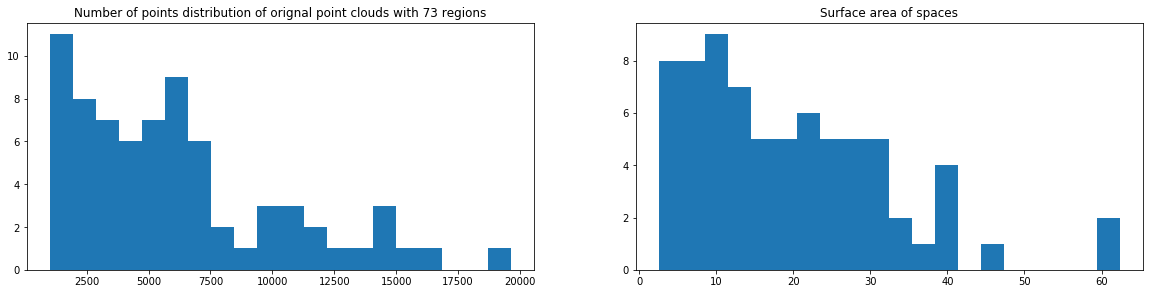

In [133]:
fig = plt.figure(figsize=(20,10))

orignalPointCollectionAttributes = np.asarray(orignalPointCollectionAttributes)

ax1 = fig.add_subplot(221)
ax1.hist(np.asarray(orignalPointCollectionAttributes[:,-2], dtype=np.uint32),bins = 20)
ax1.set_title('Number of points distribution of orignal point clouds with {} regions'.format(len(copy_all_point_collection)))

ax4 = fig.add_subplot(222)
ax4.set_title('Surface area of spaces'.format(len(orignalPointCollectionAttributes)))
ax4.hist(np.asarray(orignalPointCollectionAttributes[:,-1], dtype=np.single),bins = 20);#np.arange(0,7000,500))

#ax3.set_xticks(hist_value);

#combinedProperties

In [142]:
new_centered_point_collection = []

for object_name, pointCloud, _vn, triangles in copy_all_point_collection:
    
    pointCloud = np.asarray(pointCloud)
    triangles = np.asarray(triangles)#-vertices_length
    normals = np.asarray(_vn)
    
    new_centered_point_collection.append([
        object_name,
        np.concatenate((pointCloud,normals),axis = 1),
        triangles
    ])
    
with open('point_collection/all_point_collection.pickle','wb') as f: #just 73 after this
    pickle.dump(new_centered_point_collection,f)

In [138]:
new_descriptors = []

for object_name, pointCloud, _vn, triangles in copy_all_point_collection:
            
    try:
        t_descriptors, t_keypoints, t_d_c = getSpinImageDescriptors(np.concatenate((pointCloud,_vn),axis = 1))
        #print("Got the true descriptors",t_descriptors.shape,t_keypoints.shape)
    except Exception as ex:
        print(ex)
        print("Error getting the true descriptors of",object_name,"with size",pointCloud.shape)


    print("Done with",object_name)
        
    new_descriptors.append([
        t_descriptors,
        t_keypoints,
        t_d_c,
        object_name
    ])
    
    with open('new_descriptors.pickle','wb') as f:
        pickle.dump(new_descriptors,f)


Done with Reception-Data61-L5.obj1
Done with Reception-Data61-L5.obj2
Done with Reception-Data61-L5.obj3
Done with Reception-Data61-L5.obj4
Done with Reception-Data61-L5.obj6
Done with Reception-Data61-L5.obj7
Done with Reception-Data61-L5.obj8
Done with Reception-Data61-L5.obj10
Done with Driveway.obj1
Done with Driveway.obj2
Done with Driveway.obj3
Done with Driveway.obj4
Done with Driveway.obj5
Done with Driveway.obj7
Done with Driveway.obj8
Done with Driveway.obj9
Done with Driveway.obj11
Done with Apartment.obj1
Done with Apartment.obj2
Done with Apartment.obj3
Done with Apartment.obj4
Done with Apartment.obj5
Done with Apartment.obj6
Done with Workstations-Data61-L4.obj1
Done with Workstations-Data61-L4.obj2
Done with Workstations-Data61-L4.obj3
Done with Workstations-Data61-L4.obj4
Done with Workstations-Data61-L4.obj5
Done with Workstations-Data61-L4.obj6
Done with Workstations-Data61-L4.obj7
Done with Workstations-Data61-L4.obj8
Done with Workstations-Data61-L4.obj9
Done with 

In [144]:
random_theta =  (2*np.pi)*np.random.random()# from [0, 2pi)
random_axis = np.random.choice(np.arange(0,3))
rotatedPointCollection = rotatePointCollection(new_centered_point_collection,theta = random_theta, axis = random_axis)
print("theta = {:.2f} degrees, axis = {}".format(random_theta*180/np.pi, random_axis))

theta = 323.62 degrees, axis = 2


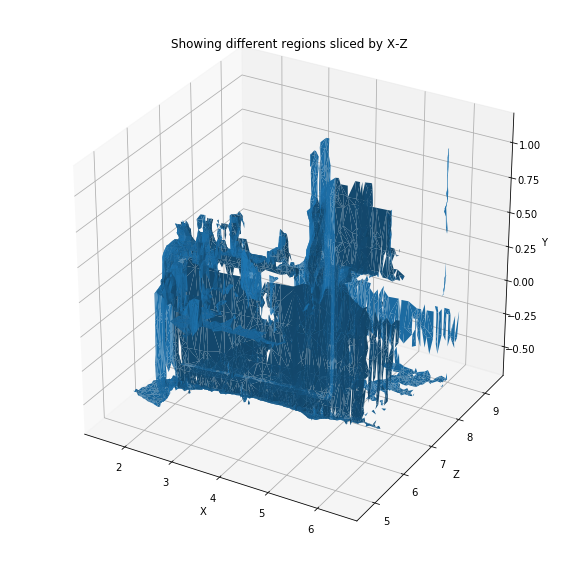

In [147]:
fig=plt.figure(figsize=(10, 10))


ax = fig.add_subplot(111, projection='3d')

#vertices_length = 1

for object_name, pointCloud, triangles in new_centered_point_collection[:1]:
    
    #if any(object_name-1 == item for item in [0,34,7,18,13,38,30]):
        pointCloud = np.asarray(pointCloud)
        triangles = np.asarray(triangles)#-vertices_length

        X = pointCloud[:,0]
        Y = pointCloud[:,1]
        Z = pointCloud[:,2]
        #vertices_length += len(X)
        #im = ax.scatter(X,Y,Z, c = object_name*3*np.ones(pointCloud.shape[0]))
        #color = (object_name%256,object_name%127,object_name%63)
        #print(object_name,len(X),triangles.min(),triangles.max())
        try:
            ax.plot_trisurf(X, -Z, Y, triangles=triangles)#, cmap=plt.cm.Spectral)
        except:
            pass
        
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_title('Showing different regions sliced by X-Z')

# Add a colorbar
#fig.colorbar(im, ax=ax)

# set the color limits - not necessary here, but good to know how.
#im.set_clim(0.0, 1.0)

plt.show()

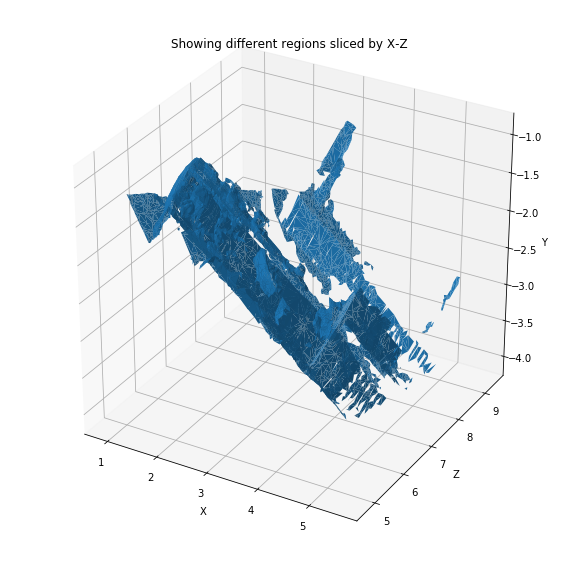

In [148]:
fig=plt.figure(figsize=(10, 10))


ax = fig.add_subplot(111, projection='3d')

#vertices_length = 1

for object_name, pointCloud, triangles in rotatedPointCollection[:1]:
    
    #if any(object_name-1 == item for item in [0,34,7,18,13,38,30]):
        pointCloud = np.asarray(pointCloud)
        triangles = np.asarray(triangles)#-vertices_length

        X = pointCloud[:,0]
        Y = pointCloud[:,1]
        Z = pointCloud[:,2]
        #vertices_length += len(X)
        #im = ax.scatter(X,Y,Z, c = object_name*3*np.ones(pointCloud.shape[0]))
        #color = (object_name%256,object_name%127,object_name%63)
        #print(object_name,len(X),triangles.min(),triangles.max())
        try:
            ax.plot_trisurf(X, -Z, Y, triangles=triangles)#, cmap=plt.cm.Spectral)
        except:
            pass
        
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_title('Showing different regions sliced by X-Z')

# Add a colorbar
#fig.colorbar(im, ax=ax)

# set the color limits - not necessary here, but good to know how.
#im.set_clim(0.0, 1.0)

plt.show()

73

In [68]:
#
#with open('complete_3D_space_Data61_points.csv', mode='w') as f:
#    file_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
#    file_writer.writerow(['x', 'y', 'z','nx', 'ny', 'nz'])
#    for point in oriented_points:
#        file_writer.writerow(point)
        
#with open('complete_3D_space_Data61_triangle-mesh.csv', mode='w') as f:
#    file_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
#    file_writer.writerow(['v1','v2','v3'])
#    for triangle in pointCollection_no_objects[2]:
#        file_writer.writerow(triangle)
#        file_writer.writerow(['Erica Meyers', 'IT', 'March'])

In [7]:
sphereFile = open('sphere.obj')#'point_cloud.obj')('SpatialMesh.obj')#

sphereFileLines = sphereFile.readlines()

#sphere = [] # object_number, vertices, vertex normals, polygons

#pointCollection_no_objects = [[],[],[]] 
spherePointVertices = []
spherePointNormals = []

prev_length = 0
vertices_length = 1

for line in sphereFileLines:
    
    if line == '\n': continue

    line_items = line.split()

        #print(object_number)
    
    if line_items[0] == 'v':
        x = line_items[1]
        y = line_items[2]
        z = line_items[3]
        if len(line_items)> 4:
            c = line_items[4]
            if float(c) > 0.85:
                pointCollection[object_number-1][1].append([float(x),float(y),float(z),float(c)])
                pointCollection_no_objects[0].append([float(x),float(y),float(z),float(c)])
        else:
            spherePointVertices.append([float(x),float(y),float(z)])
            #pointCollection_no_objects[0].append([float(x),float(y),float(z)])
        #prev_length = len(pointCollection[object_number-1][1])

            
    if line_items[0] == 'vn':
        x = line_items[1]
        y = line_items[2]
        z = line_items[3]
        spherePointNormals.append([float(x),float(y),float(z)])
        #pointCollection_no_objects[1].append([float(x),float(y),float(z)])
        
#    if line_items[0] == 'f':
#        p1 = int(line_items[1].split('//')[0])
#        p2 = int(line_items[2].split('//')[0])
#        p3 = int(line_items[3].split('//')[0])
#        pointCollection[object_number-1][3].append([p1-vertices_length,
#                                                    p2-vertices_length,
#                                                    p3-vertices_length])
#        pointCollection_no_objects[2].append([p1-1,p2-1,p3-1])        

spherePointCloud = np.concatenate((np.asarray(spherePointVertices),np.asarray(spherePointNormals))
                                  ,axis = 1)
print("Length of points",len(spherePointVertices))
print("Shape of sphere point cloud",spherePointCloud.shape)

Length of points 482
Shape of sphere point cloud (482, 6)


In [8]:
# Creating a cube point cloud.

sides = [[1,-1],[1,-1],[1,-1]]

position = np.asarray([0, 1, 2])

cubePointCloud = []
for i,side in enumerate(sides):
    #print(i,side)
    for flip in side:
        sidePointCloud = np.zeros((len(np.arange(-1,1,0.1))**2,6))
        #print(sidePointCloud.shape)
        pos = np.delete(position,i)
        #print(pos)
        for p,v1 in enumerate(np.arange(-1,1,0.1)):
            sidePointCloud[p*len(np.arange(-1,1,0.1)):(p+1)*len(np.arange(-1,1,0.1)),pos[0]]=np.arange(-1,1,0.1)
            sidePointCloud[p*len(np.arange(-1,1,0.1)):(p+1)*len(np.arange(-1,1,0.1)),pos[1]]=v1
        sidePointCloud[:,i]=flip
        sidePointCloud[:,3+i]=flip
        if len(cubePointCloud) == 0:
            cubePointCloud = sidePointCloud
        else:
            cubePointCloud = np.concatenate((cubePointCloud,sidePointCloud),axis = 0)
            
print("Shape of cube pointCloud", cubePointCloud.shape)

Shape of cube pointCloud (2400, 6)


In [9]:
np.arange(-1,1,0.1).shape

(20,)

Index [16 11 23 24 15 10 43 30 45 19 29  7 53 28 35 47 46 40 21 31 38 18  5 32
 51 14  1 50  2 37 12  6  9  0 49 27 13  4 41 34 25 26 52 36 22 20 44 39
  3 33  8 48 17 42]
Count [  10   41   42   45   53  119  167  173  180  186  198  200  231  232
  292  316  350  381  404  439  530  686  696  814  823  861  880 1008
 1016 1041 1125 1187 1201 1222 1260 1439 1479 1825 1967 2258 2269 2321
 2352 2441 2630 2663 2933 3417 3424 3450 3766 3901 4028 6243]


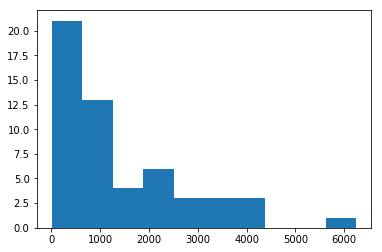

In [10]:
pointCollectionProperties = []

for o_, v_, vn_, p_  in pointCollection: # object_number, vertices, vertex normals, polygons
    pointCollectionProperties.append([
        o_,
        len(v_),
    ])


pointCollectionProperties = np.asarray(pointCollectionProperties)
plt.hist(pointCollectionProperties[:,1],bins=10)
print("Index",np.argsort(pointCollectionProperties[:,1]))
print("Count",pointCollectionProperties[np.argsort(pointCollectionProperties[:,1]),1])

In [12]:
def getPointDistance(_point_cloud, _triangles):
    
    distances = []
    for triangle in _triangles:
        d01 = LA.norm(_point_cloud[triangle[0],:3] - _point_cloud[triangle[1],:3])
        d21 = LA.norm(_point_cloud[triangle[2],:3] - _point_cloud[triangle[1],:3])
        d20 = LA.norm(_point_cloud[triangle[2],:3] - _point_cloud[triangle[0],:3])
        distances.append([d01,d21,d20])
        
    return distances

In [13]:

point_distances = []
for obj_name, pointCloud, triangles in centeredPointCollection:

    distance = getPointDistance(pointCloud,triangles)
    if len(point_distances) == 0:
        point_distances = distance
    else:
        point_distances = np.concatenate((np.asarray(point_distances),np.asarray(distance)),axis = 0)
  

Minimum point distance 0.0024999975207758043
Maximum point distance 0.4252133985620542
Mean point distance 0.07347263974673303
Median point distance 0.056789104274218


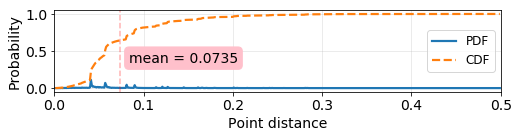

In [14]:
fig=plt.figure(figsize=(8, 1.5)) ##fig=plt.figure(figsize=(80, 80))
plt.grid(alpha=0.3)
plt.xlim(0,0.5)
plt.xlabel("Point distance",fontsize = 14)

print("Minimum point distance",np.min(point_distances.flatten('C')))
print("Maximum point distance",np.max(point_distances.flatten('C')))
print("Mean point distance",np.mean(point_distances.flatten('C')))
print("Median point distance",np.median(point_distances.flatten('C')))


hist, values = np.histogram(point_distances.flatten('C'),bins = np.arange(0,0.5,0.001))
plt.plot(values[1:],hist/np.sum(hist), label = 'PDF',linewidth = 2.2)
plt.plot(values[1:],np.cumsum(hist/np.sum(hist)), '--',label = 'CDF',linewidth = 2.2)
plt.legend(fontsize = 12,loc='center right')
plt.axvline(np.mean(point_distances.flatten('C')),linestyle='--',alpha = 0.3, color = 'red')

plt.text(
    np.mean(point_distances.flatten('C'))+0.01,0.35,
    'mean = {:.4f}'.format(np.mean(point_distances.flatten('C'))), 
    fontsize = 14,bbox=dict(boxstyle="round", color = "pink")
)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
plt.savefig('plots/point-distance.pdf', format='pdf', dpi=1000, bbox_inches = 'tight')

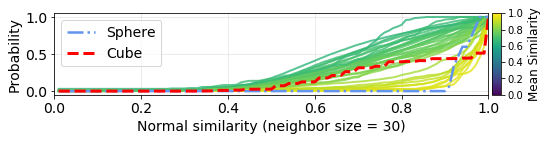

In [109]:
fig=plt.figure(figsize=(8, 1.5)) ##fig=plt.figure(figsize=(80, 80))

neighbor_size = 30

linewidth = 5

# Of all spaces
for obj_name, pointCloud, triangles in centeredPointCollection:
    
    nbrs = NearestNeighbors(n_neighbors=neighbor_size, algorithm='brute').fit(pointCloud[:,:3])
    distances, indices = nbrs.kneighbors(pointCloud[:,:3])
    
    try:
        nearby_normals = pointCloud[indices,3:6]
        refrnc_normals = np.reshape(np.repeat(pointCloud[:,3:6],neighbor_size,axis=0),nearby_normals.shape)

        normal_product = np.sum(np.multiply(refrnc_normals,nearby_normals),axis=2)
    except Exception as e1:
        print("getLocalSelfSimilarity: Error while getting normals,", e1)
    
    color = np.mean(np.abs(normal_product))
    hist, values = np.histogram(np.mean(np.abs(normal_product),axis = 1), bins = np.arange(0,1.01,0.01))
    CY = np.cumsum(hist/np.sum(hist))
    plt.plot(values[1:], CY, alpha = 0.8, color = mpl.cm.viridis(color), linewidth = 2)
   
#Of a sphere

nbrs = NearestNeighbors(n_neighbors=neighbor_size, algorithm='brute').fit(spherePointCloud[:,:3])
distances, indices = nbrs.kneighbors(spherePointCloud[:,:3])
try:
    nearby_normals = spherePointCloud[indices,3:6]
    refrnc_normals = np.reshape(np.repeat(spherePointCloud[:,3:6],neighbor_size,axis=0),nearby_normals.shape)

    normal_product = np.sum(np.multiply(refrnc_normals,nearby_normals),axis=2)
except Exception as e1:
    print("getLocalSelfSimilarity: Error while getting normals,", e1)

hist, values = np.histogram(np.mean(np.abs(normal_product),axis = 1), bins = np.arange(0,1.01,0.01))
CY = np.cumsum(hist/np.sum(hist))
p1, = plt.plot(values[1:], CY, '-.',color='cornflowerblue',label = 'Sphere', linewidth = 2.5)

# Of a cube
nbrs = NearestNeighbors(n_neighbors=neighbor_size, algorithm='brute').fit(cubePointCloud[:,:3])
distances, indices = nbrs.kneighbors(cubePointCloud[:,:3])
try:
    nearby_normals = cubePointCloud[indices,3:6]
    refrnc_normals = np.reshape(np.repeat(cubePointCloud[:,3:6],neighbor_size,axis=0),nearby_normals.shape)

    normal_product = np.sum(np.multiply(refrnc_normals,nearby_normals),axis=2)
except Exception as e1:
    print("getLocalSelfSimilarity: Error while getting normals,", e1)

hist, values = np.histogram(np.mean(np.abs(normal_product),axis = 1), bins = np.arange(0,1.01,0.01))
CY = np.cumsum(hist/np.sum(hist))
p2, = plt.plot(values[1:], CY, '--',color = 'red',label = 'Cube', linewidth = 3)

plt.xlabel("Normal similarity (neighbor size = {})".format(neighbor_size), fontsize = 14)
plt.xlim(0,1)
plt.xticks(np.arange(0,1.1,0.2),fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(alpha=0.3)
plt.legend([p1, p2],['Sphere','Cube'],fontsize = 14);
plt.ylabel('Probability', fontsize = 14)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="2%", pad=0.05)    
cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=mpl.cm.viridis, orientation='vertical')
cb1.set_label('Mean Similarity', fontsize = 12)
plt.gcf().add_axes(ax_cb)

plt.savefig('plots/cdf-normal-similarity.pdf', format='pdf', dpi=1000, bbox_inches = 'tight')

Average Number of points per space 1921.6842105263158


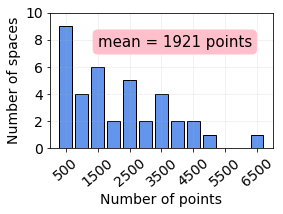

In [16]:
fig=plt.figure(figsize=(4, 2.5)) ##fig=plt.figure(figsize=(80, 80))
plt.grid(alpha=0.2)

plt.xlim(0,7000)
plt.ylim(0,10)
plt.xticks(np.arange(500,7000,1000),fontsize = 14,rotation = 40)
plt.yticks(fontsize = 14)
#ax3 = fig.add_subplot(223)
#plt.title('Number of points distribution of orignal point clouds with {} regions'.format(len(centeredPointCollection)))
hist, values = np.histogram(combinedProperties[:,0],bins = np.arange(0,7000,500));#, width = 250);
plt.xlabel('Number of points', fontsize = 14);
plt.ylabel('Number of spaces', fontsize = 14);
plt.bar(values[1:], hist, width = 400, color = 'cornflowerblue', edgecolor='black')#, hatch="//")
plt.text(x = 1500, y = 7.5,s ="mean = 1921 points",fontsize = 15,
         bbox=dict(boxstyle="round", color = "pink"))

plt.savefig('plots/hist-point-count.pdf', format='pdf', dpi=1000, bbox_inches = 'tight')
print("Average Number of points per space",np.mean(combinedProperties[:,0]))

Average Surface area of spaces 6.590848431094437


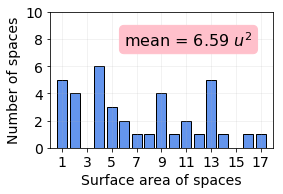

In [17]:
fig=plt.figure(figsize=(4, 2.5)) ##fig=plt.figure(figsize=(80, 80))
plt.grid(alpha=0.2)

print("Average Surface area of spaces",np.mean(combinedProperties[:,1]))

plt.xlim(0,18)
plt.ylim(0,10)
plt.xticks(np.arange(1,18,2),fontsize = 14)
plt.yticks(fontsize = 14)
#ax4 = fig.add_subplot(224)
plt.xlabel('Surface area of spaces', fontsize = 14)
plt.ylabel('Number of spaces', fontsize = 14);

#plt.xticks(np.arange(1,21,2))
hist, values = np.histogram(combinedProperties[:,1],bins = np.arange(0,21,1))#np.arange(0,7000,500));
#plt.hist(combinedProperties[:,1],bins = np.arange(0,21,1))#np.arange(0,7000,500));

plt.bar(values[1:], hist, color = 'cornflowerblue', edgecolor='black')#, hatch="//")
plt.text(x = 6, y = 7.5,s ="mean = 6.59 $u^2$",fontsize = 16,
         bbox=dict(boxstyle="round", color = "pink"))
plt.savefig('plots/hist-surface-area.pdf', format='pdf', dpi=1000, bbox_inches = 'tight')


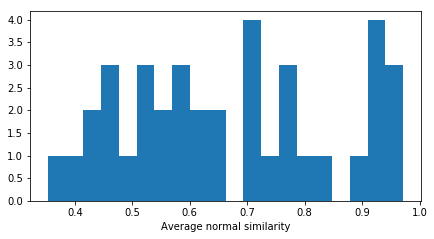

In [18]:
fig=plt.figure(figsize=(7, 3.5)) ##fig=plt.figure(figsize=(80, 80))

#ax4 = fig.add_subplot(224)
plt.xlabel('Average normal similarity')
plt.hist(combinedProperties[:,2],bins = 20);#np.arange(0,7000,500));

(11, 38)
Correlation of errors and point population: 0.6329873417821946
Correlation of errors and normal similarity: -0.5648402926557278


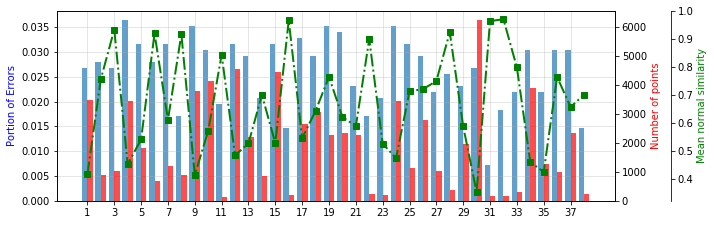

In [19]:
fig=plt.figure(figsize=(10, 3.5))

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        

ax1 = fig.subplots()
width = 0.4

with open('results_spin_image_partials/complete_c_qpr_0.25_3_scores.pickle', 'rb') as f:
    qpr_scores = pickle.load(f)
    
ax1.set_xticks(np.arange(1, 38,2))
ax1.grid(alpha = 0.4)
#ax1.set_ylim(0,0.1)

ax1.set_ylabel('Portion of Errors', color = 'blue')

#plt.ylim()
 
err_rate, qpr_errors = getErrorRate(qpr_scores)

error_accumulation_per_object = []

for radius, error_values, error_maps in qpr_errors:
#    print(radius, error_values.shape, error_maps.shape)
    error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
#    np.sum(error_maps, axis = 0).shape)

error_per_object = np.asarray(error_accumulation_per_object)
print(error_per_object.shape)
p1 = ax1.bar(
    np.arange(1, error_per_object.shape[1]+1,1)-0.5*width,
    np.sum(error_per_object,axis = 0)/np.sum(error_per_object),
    width = width, alpha = 0.7,
    label = "Errors in partial matching");

ax2 = ax1.twinx()
ax2.set_ylabel('Number of points', color = 'red')

p2 = ax2.bar(
    np.arange(1, error_per_object.shape[1]+1,1)+0.5*width,
    combinedProperties[:,0],
    color = 'red', width = width, alpha = 0.7,
    label = "Number of points");

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)

ax3.set_ylabel('Mean normal similarity', color = 'green')

p3 = ax3.plot(
    np.arange(1, error_per_object.shape[1]+1,1),
    combinedProperties[:,2],
    '-.sg', linewidth = 2,
    label = "Mean normal similarity");

lines = [p1, p2]#, p3, p4, p5,p6]

#ax1.legend(lines, [l.get_label() for l in lines], loc='best')

properties_errors_stack = np.stack((np.sum(error_per_object,axis = 0)/np.sum(error_per_object),
                                    combinedProperties[:,0].flatten('C')/np.sum(combinedProperties[:,0]),
                                    combinedProperties[:,2].flatten('C')
                                   ),axis =0)
#np.corrcoef(np.stack)
#combinedProperties[:,0].flatten('C').shape
#error_per_object.shape
error_corrcoef = np.corrcoef(properties_errors_stack)[0]

print("Correlation of errors and point population:",error_corrcoef[1])
print("Correlation of errors and normal similarity:",error_corrcoef[2])


(11, 38)
Correlation of errors and point population: -0.3411449286704859
Correlation of errors and normal similarity: 0.24345347392146513


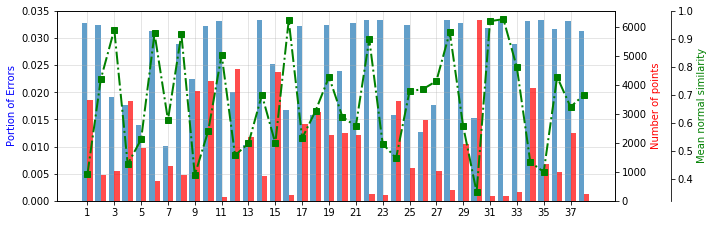

In [20]:
fig=plt.figure(figsize=(10, 3.5))

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        

ax1 = fig.subplots()
width = 0.4

with open('results_spin_image_partials/generalized_r_qpr_0.25_3_scores.pickle', 'rb') as f:
    qpr_scores = pickle.load(f)
    
    
ax1.set_xticks(np.arange(1, 38,2))
ax1.grid(alpha = 0.4)
#ax1.set_ylim(0,0.1)

ax1.set_ylabel('Portion of Errors', color = 'blue')

#plt.ylim()
 
err_rate, qpr_errors = getErrorRate(qpr_scores)

error_accumulation_per_object = []

for radius, error_values, error_maps in qpr_errors:
#    print(radius, error_values.shape, error_maps.shape)
    error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
#    np.sum(error_maps, axis = 0).shape)

error_per_object = np.asarray(error_accumulation_per_object)
print(error_per_object.shape)
p1 = ax1.bar(
    np.arange(1, error_per_object.shape[1]+1,1)-0.5*width,
    np.sum(error_per_object,axis = 0)/np.sum(error_per_object),
    width = width, alpha = 0.7,
    label = "Errors");

ax2 = ax1.twinx()
ax2.set_ylabel('Number of points', color = 'red')

p2 = ax2.bar(
    np.arange(1, error_per_object.shape[1]+1,1)+0.5*width,
    combinedProperties[:,0],
    color = 'red', width = width, alpha = 0.7,
    label = "Number of points");

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)

ax3.set_ylabel('Mean normal similarity', color = 'green')

p3 = ax3.plot(
    np.arange(1, error_per_object.shape[1]+1,1),
    combinedProperties[:,2],
    '-.sg', linewidth = 2,
    label = "Mean normal similarity");

lines = [p1, p2]#, p3, p4, p5,p6]

#ax1.legend(lines, [l.get_label() for l in lines], loc='best')

properties_errors_stack = np.stack((np.sum(error_per_object,axis = 0)/np.sum(error_per_object),
                                    combinedProperties[:,0].flatten('C')/np.sum(combinedProperties[:,0]),
                                    combinedProperties[:,2].flatten('C')
                                   ),axis =0)
#np.corrcoef(np.stack)
#combinedProperties[:,0].flatten('C').shape
#error_per_object.shape
error_corrcoef = np.corrcoef(properties_errors_stack)[0]

print("Correlation of errors and point population:",error_corrcoef[1])
print("Correlation of errors and normal similarity:",error_corrcoef[2])

/Users/deg032/Projects/3D/info3d.py:1291: RuntimeWarning: invalid value encountered in true_divide
  adjusted_scores = scores[:,:,0]*scores[:,:,-1]/scores[:,:,1]


(8, 38)
Correlation of errors and point population: 0.21912310255171208
Correlation of errors and normal similarity: -0.26025525641899955


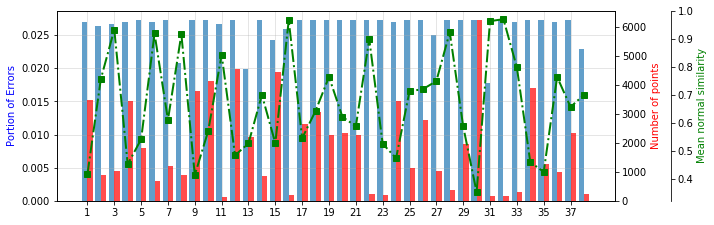

In [21]:
fig=plt.figure(figsize=(10, 3.5))

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        

ax1 = fig.subplots()
width = 0.4

with open('results_spin_image_partials_localized/c_qpr_0.25_2_scores.pickle', 'rb') as f:
    qpr_scores = pickle.load(f)
    
    
ax1.set_xticks(np.arange(1, 38,2))
ax1.grid(alpha = 0.4)
#ax1.set_ylim(0,0.1)

ax1.set_ylabel('Portion of Errors', color = 'blue')

#plt.ylim()
 
err_rate, qpr_errors = getErrorRate(qpr_scores)

error_accumulation_per_object = []

for radius, error_values, error_maps in qpr_errors:
#    print(radius, error_values.shape, error_maps.shape)
    error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
#    np.sum(error_maps, axis = 0).shape)

error_per_object = np.asarray(error_accumulation_per_object)
print(error_per_object.shape)
p1 = ax1.bar(
    np.arange(1, error_per_object.shape[1]+1,1)-0.5*width,
    np.sum(error_per_object,axis = 0)/np.sum(error_per_object),
    width = width, alpha = 0.7,
    label = "Errors in partial matching");

ax2 = ax1.twinx()
ax2.set_ylabel('Number of points', color = 'red')

p2 = ax2.bar(
    np.arange(1, error_per_object.shape[1]+1,1)+0.5*width,
    combinedProperties[:,0],
    color = 'red', width = width, alpha = 0.7,
    label = "Number of points");

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)

ax3.set_ylabel('Mean normal similarity', color = 'green')

p3 = ax3.plot(
    np.arange(1, error_per_object.shape[1]+1,1),
    combinedProperties[:,2],
    '-.sg', linewidth = 2,
    label = "Mean normal similarity");

lines = [p1, p2]#, p3, p4, p5,p6]

#ax1.legend(lines, [l.get_label() for l in lines], loc='best')

properties_errors_stack = np.stack((np.sum(error_per_object,axis = 0)/np.sum(error_per_object),
                                    combinedProperties[:,0].flatten('C')/np.sum(combinedProperties[:,0]),
                                    combinedProperties[:,2].flatten('C')
                                   ),axis =0)
#np.corrcoef(np.stack)
#combinedProperties[:,0].flatten('C').shape
#error_per_object.shape
error_corrcoef = np.corrcoef(properties_errors_stack)[0]

print("Correlation of errors and point population:",error_corrcoef[1])
print("Correlation of errors and normal similarity:",error_corrcoef[2])

/Users/deg032/Projects/3D/info3d.py:1291: RuntimeWarning: invalid value encountered in true_divide
  adjusted_scores = scores[:,:,0]*scores[:,:,-1]/scores[:,:,1]


[[ 1.         -0.32718996  0.48389668  0.63298734 -0.56484029]
 [-0.32718996  1.          0.08822571 -0.34114493  0.24345347]
 [ 0.48389668  0.08822571  1.          0.2191231  -0.26025526]
 [ 0.63298734 -0.34114493  0.2191231   1.         -0.76458473]
 [-0.56484029  0.24345347 -0.26025526 -0.76458473  1.        ]]


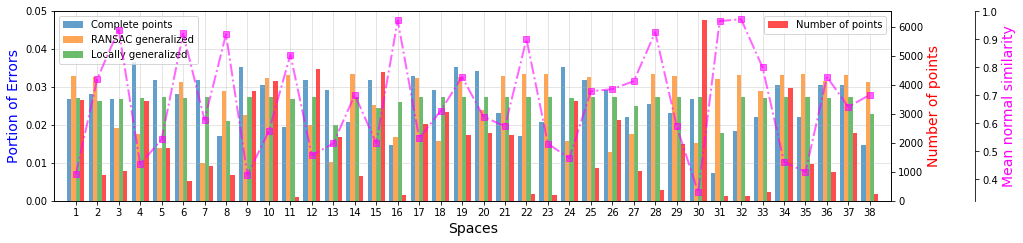

In [22]:
fig=plt.figure(figsize=(15, 3.5))

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        

ax1 = fig.subplots()
width = 0.4

ax1.set_xticks(np.arange(1, 39,1))
ax1.set_xlabel('Spaces',fontsize = 14)
ax1.grid(alpha = 0.4)
ax1.set_ylim(0,0.05)

ax1.set_xlim(0,39)

ax1.set_ylabel('Portion of Errors', color = 'blue',fontsize = 14)

# COMPLETE
with open('results_spin_image_partials/complete_c_qpr_0.25_3_scores.pickle', 'rb') as f:
    qpr_scores = pickle.load(f)
     
err_rate, qpr_errors = getErrorRate(qpr_scores)

error_accumulation_per_object = []

for radius, error_values, error_maps in qpr_errors:
#    print(radius, error_values.shape, error_maps.shape)
    error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
#    np.sum(error_maps, axis = 0).shape)

error_per_object = np.asarray(error_accumulation_per_object)
#print(error_per_object.shape)
p1 = ax1.bar(
    np.arange(1, error_per_object.shape[1]+1,1)-1.5*0.5*width,
    np.sum(error_per_object,axis = 0)/np.sum(error_per_object),
    width = 0.5*width, alpha = 0.7,
    label = "Complete points");

# GENERALIZED
with open('results_spin_image_partials/generalized_r_qpr_0.25_3_scores.pickle', 'rb') as f:
    qpr_scores = pickle.load(f)
    
err_rate, qpr_errors = getErrorRate(qpr_scores)

error_accumulation_per_object = []

for radius, error_values, error_maps in qpr_errors:
#    print(radius, error_values.shape, error_maps.shape)
    error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
#    np.sum(error_maps, axis = 0).shape)

g_error_per_object = np.asarray(error_accumulation_per_object)
#print(error_per_object.shape)
p2 = ax1.bar(
    np.arange(1, g_error_per_object.shape[1]+1,1)-0.5*0.5*width,
    np.sum(g_error_per_object,axis = 0)/np.sum(g_error_per_object),
    width = 0.5*width, alpha = 0.7,
    label = "RANSAC generalized");

# LOCALIZED
with open('results_spin_image_partials_localized/c_qpr_0.25_2_scores.pickle', 'rb') as f:
    qpr_scores = pickle.load(f)
    
err_rate, qpr_errors = getErrorRate(qpr_scores)

error_accumulation_per_object = []

for radius, error_values, error_maps in qpr_errors:
#    print(radius, error_values.shape, error_maps.shape)
    error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
#    np.sum(error_maps, axis = 0).shape)

l_error_per_object = np.asarray(error_accumulation_per_object)
#print(error_per_object.shape)
p3 = ax1.bar(
    np.arange(1, l_error_per_object.shape[1]+1,1)+0.5*0.5*width,
    np.sum(l_error_per_object,axis = 0)/np.sum(l_error_per_object),
    width = 0.5*width, alpha = 0.7,
    label = "Locally generalized");

ax2 = ax1.twinx()
ax2.set_ylabel('Number of points', color = 'red',fontsize = 14)

ax2.bar(
    np.arange(1, error_per_object.shape[1]+1,1)+1.5*0.5*width,
    combinedProperties[:,0],
    color = 'red', width = 0.5*width, alpha = 0.7,
    label = "Number of points");

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)

ax3.set_ylabel('Mean normal similarity', color = 'magenta',fontsize = 14)

ax3.plot(
    np.arange(1, error_per_object.shape[1]+1,1),
    combinedProperties[:,2],
    '-.s',color='magenta', linewidth = 2, alpha = 0.6,
    label = "Mean normal similarity");

lines = [p1, p2, p3]#, p5,p6]

ax1.legend(lines, [l.get_label() for l in lines], loc='upper left')
ax2.legend(loc='upper right')

properties_errors_stack = np.stack((np.sum(error_per_object,axis = 0),
                                    np.sum(g_error_per_object,axis = 0),
                                    np.sum(l_error_per_object,axis = 0),
                                    combinedProperties[:,0].flatten('C')/np.sum(combinedProperties[:,0]),
                                    combinedProperties[:,2].flatten('C')
                                   ),axis =0)
#np.corrcoef(np.stack)
#combinedProperties[:,0].flatten('C').shape
#error_per_object.shape
error_corrcoef = np.corrcoef(properties_errors_stack)
print(error_corrcoef)
#print("Correlation of errors and point population:",error_corrcoef[1])
#print("Correlation of errors and normal similarity:",error_corrcoef[2])

#plt.savefig('plots/space-analysis.pdf', format='pdf', dpi=1000, bbox_inches = 'tight')

/Users/deg032/Projects/3D/info3d.py:1291: RuntimeWarning: invalid value encountered in true_divide
  adjusted_scores = scores[:,:,0]*scores[:,:,-1]/scores[:,:,1]


[[ 1.         -0.32718996  0.48389668  0.63298734 -0.56484029]
 [-0.32718996  1.          0.08822571 -0.34114493  0.24345347]
 [ 0.48389668  0.08822571  1.          0.2191231  -0.26025526]
 [ 0.63298734 -0.34114493  0.2191231   1.         -0.76458473]
 [-0.56484029  0.24345347 -0.26025526 -0.76458473  1.        ]]


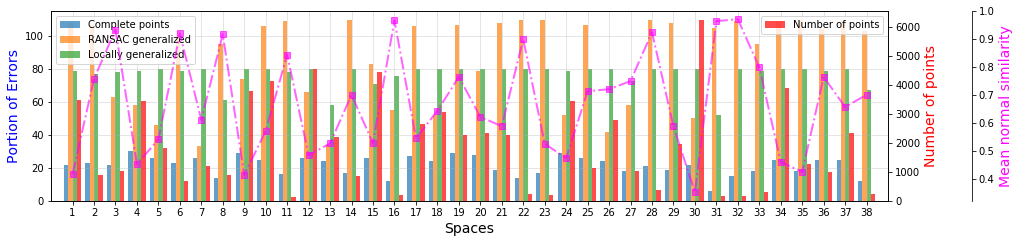

In [23]:
fig=plt.figure(figsize=(15, 3.5))

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        

ax1 = fig.subplots()
width = 0.4

ax1.set_xticks(np.arange(1, 39,1))
ax1.set_xlabel('Spaces',fontsize = 14)
ax1.grid(alpha = 0.4)
#ax1.set_ylim(0,0.05)

ax1.set_xlim(0,39)

ax1.set_ylabel('Portion of Errors', color = 'blue',fontsize = 14)

# COMPLETE
with open('results_spin_image_partials/complete_c_qpr_0.25_3_scores.pickle', 'rb') as f:
    qpr_scores = pickle.load(f)
     
err_rate, qpr_errors = getErrorRate(qpr_scores)

error_accumulation_per_object = []

for radius, error_values, error_maps in qpr_errors:
#    print(radius, error_values.shape, error_maps.shape)
    error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
#    np.sum(error_maps, axis = 0).shape)

error_per_object = np.asarray(error_accumulation_per_object)
#print(error_per_object.shape)
p1 = ax1.bar(
    np.arange(1, error_per_object.shape[1]+1,1)-1.5*0.5*width,
    np.sum(error_per_object,axis = 0),#/np.sum(error_per_object),
    width = 0.5*width, alpha = 0.7,
    label = "Complete points");

# GENERALIZED
with open('results_spin_image_partials/generalized_r_qpr_0.25_3_scores.pickle', 'rb') as f:
    qpr_scores = pickle.load(f)
    
err_rate, qpr_errors = getErrorRate(qpr_scores)

error_accumulation_per_object = []

for radius, error_values, error_maps in qpr_errors:
#    print(radius, error_values.shape, error_maps.shape)
    error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
#    np.sum(error_maps, axis = 0).shape)

g_error_per_object = np.asarray(error_accumulation_per_object)
#print(error_per_object.shape)
p2 = ax1.bar(
    np.arange(1, g_error_per_object.shape[1]+1,1)-0.5*0.5*width,
    np.sum(g_error_per_object,axis = 0),#/np.sum(g_error_per_object),
    width = 0.5*width, alpha = 0.7,
    label = "RANSAC generalized");

# LOCALIZED
with open('results_spin_image_partials_localized/c_qpr_0.25_2_scores.pickle', 'rb') as f:
    qpr_scores = pickle.load(f)
    
err_rate, qpr_errors = getErrorRate(qpr_scores)

error_accumulation_per_object = []

for radius, error_values, error_maps in qpr_errors:
#    print(radius, error_values.shape, error_maps.shape)
    error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
#    np.sum(error_maps, axis = 0).shape)

l_error_per_object = np.asarray(error_accumulation_per_object)
#print(error_per_object.shape)
p3 = ax1.bar(
    np.arange(1, l_error_per_object.shape[1]+1,1)+0.5*0.5*width,
    np.sum(l_error_per_object,axis = 0),#/np.sum(l_error_per_object),
    width = 0.5*width, alpha = 0.7,
    label = "Locally generalized");

ax2 = ax1.twinx()
ax2.set_ylabel('Number of points', color = 'red',fontsize = 14)

ax2.bar(
    np.arange(1, error_per_object.shape[1]+1,1)+1.5*0.5*width,
    combinedProperties[:,0],
    color = 'red', width = 0.5*width, alpha = 0.7,
    label = "Number of points");

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)

ax3.set_ylabel('Mean normal similarity', color = 'magenta',fontsize = 14)

ax3.plot(
    np.arange(1, error_per_object.shape[1]+1,1),
    combinedProperties[:,2],
    '-.s',color='magenta', linewidth = 2, alpha = 0.6,
    label = "Mean normal similarity");

lines = [p1, p2, p3]#, p5,p6]

ax1.legend(lines, [l.get_label() for l in lines], loc='upper left')
ax2.legend(loc='upper right')

properties_errors_stack = np.stack((np.sum(error_per_object,axis = 0),
                                    np.sum(g_error_per_object,axis = 0),
                                    np.sum(l_error_per_object,axis = 0),
                                    combinedProperties[:,0].flatten('C')/np.sum(combinedProperties[:,0]),
                                    combinedProperties[:,2].flatten('C')
                                   ),axis =0)
#np.corrcoef(np.stack)
#combinedProperties[:,0].flatten('C').shape
#error_per_object.shape
error_corrcoef = np.corrcoef(properties_errors_stack)
print(error_corrcoef)
#print("Correlation of errors and point population:",error_corrcoef[1])
#print("Correlation of errors and normal similarity:",error_corrcoef[2])

#plt.savefig('plots/space-analysis.pdf', format='pdf', dpi=1000, bbox_inches = 'tight')

<Figure size 720x720 with 0 Axes>

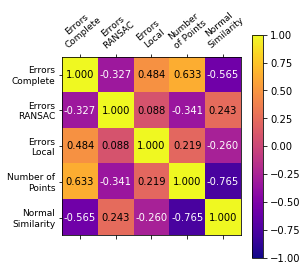

In [24]:
fig=plt.figure(figsize=(10, 10))

plt.matshow(error_corrcoef,cmap=plt.get_cmap('plasma'))
plt.xticks(np.arange(0,5),
           ['Errors\nComplete','Errors\nRANSAC','Errors\nLocal','Number\nof Points','Normal\nSimilarity'],
           fontsize = 9, rotation=40
          )
plt.yticks(np.arange(0,5),
           ['Errors\nComplete','Errors\nRANSAC','Errors\nLocal','Number of\nPoints','Normal\nSimilarity'],
           fontsize = 9
          )
plt.clim(-1,1)
plt.colorbar()

for (i, j), z in np.ndenumerate(error_corrcoef):
    if z < 0:
        plt.text(i, j, '{:.3f}'.format(z), ha='center', va='center', color = 'white')
    else:
        plt.text(i, j, '{:.3f}'.format(z), ha='center', va='center')
        
#plt.savefig('plots/space-analysis-corrcoef.pdf', format='pdf', dpi=1000,bbox_inches = 'tight')

In [35]:
combinedProperties.shape

#    combinedProperties.append([
#        len(pointCloud),
#        getPointCloudArea(pointCloud, triangles),
#        np.mean(normal_product),
#        np.std(normal_product)
#    ])

(38, 4)

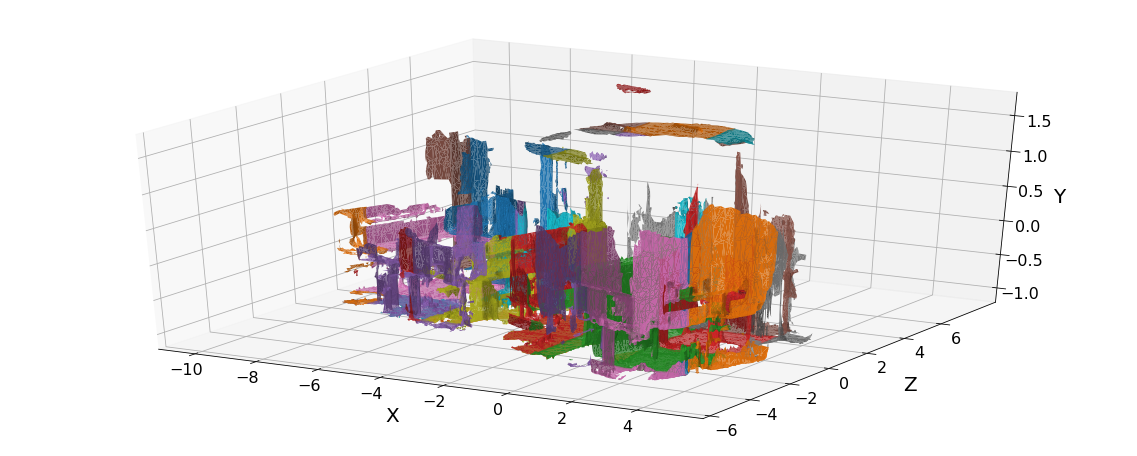

<Figure size 432x288 with 0 Axes>

In [161]:
fig=plt.figure(figsize=(20, 8))


ax = fig.add_subplot(111, projection='3d')

#vertices_length = 1

for object_name, pointCloud, _vn, triangles in pointCollection:#[3:4]:
    
    pointCloud = np.asarray(pointCloud)
    triangles = np.asarray(triangles)#-vertices_length

    X = pointCloud[:,0]
    Y = pointCloud[:,1]
    Z = pointCloud[:,2]
    #vertices_length += len(X)
    #im = ax.scatter(X,Y,Z, c = object_name*3*np.ones(pointCloud.shape[0]))
    color = (object_name%256,object_name%127,object_name%63)
    #print(object_name,len(X),triangles.min(),triangles.max())
    try:
        ax.plot_trisurf(X, -Z, Y, triangles=triangles)#, cmap=plt.cm.Spectral)
    except:
        pass
        
ax.set_xlabel('X', fontsize = 20, labelpad=20)
ax.set_ylabel('Z', fontsize = 20, labelpad=20)
ax.set_zlabel('Y', fontsize = 20, labelpad=5)

ax.set_xticks(np.arange(-10,6,2))
ax.set_yticks(np.arange(-6,7,2))
#ax.set_zticks(np.arange(-1,2,1.5))
#ax.set_title('Showing different regions sliced by X-Z')

# Add a colorbar
#fig.colorbar(im, ax=ax)

# set the color limits - not necessary here, but good to know how.
#im.set_clim(0.0, 1.0)
#ax._axis3don = False
ax.tick_params(axis='both', labelsize = 16)

plt.show()

#plt.savefig('plots/complete-point-cloud.pdf', format='pdf', dpi=1000)

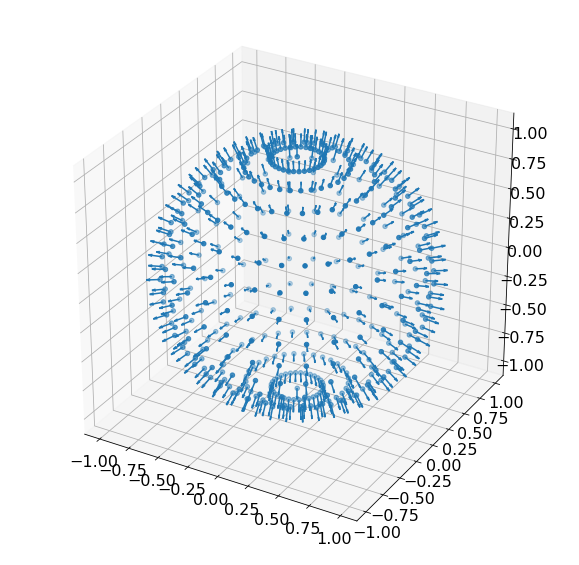

In [50]:
fig=plt.figure(figsize=(10, 10))


ax = fig.add_subplot(111, projection='3d')

#vertices_length = 1

X = edited_spherePointCloud[:,0]
Y = edited_spherePointCloud[:,1]
Z = edited_spherePointCloud[:,2]

try:
    ax.scatter(X, -Z, Y, cmap=plt.cm.Spectral)
except:
    pass
        
NX = edited_spherePointCloud[:,3]
NY = edited_spherePointCloud[:,4]
NZ = edited_spherePointCloud[:,5]

try:
    ax.quiver(X, -Z, Y, NX, -NZ, NY, length = 0.1)
except:
    pass
    
#ax.set_zticks(np.arange(-1,2,1.5))
#ax.set_title('Showing different regions sliced by X-Z')

# Add a colorbar
#fig.colorbar(im, ax=ax)

# set the color limits - not necessary here, but good to know how.
#im.set_clim(0.0, 1.0)
#ax._axis3don = False
ax.tick_params(axis='both', labelsize = 16)

plt.show()

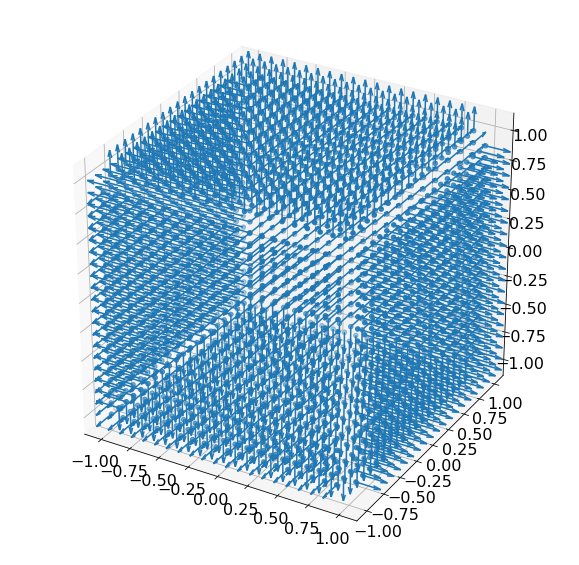

In [49]:
fig=plt.figure(figsize=(10, 10))


ax = fig.add_subplot(111, projection='3d')

#vertices_length = 1

X = cubePointCloud[:,0]
Y = cubePointCloud[:,1]
Z = cubePointCloud[:,2]

try:
    ax.scatter(X, -Z, Y, cmap=plt.cm.Spectral)
except:
    pass
        
NX = cubePointCloud[:,3]
NY = cubePointCloud[:,4]
NZ = cubePointCloud[:,5]

try:
    ax.quiver(X, -Z, Y, NX, -NZ, NY, length = 0.2)
except:
    pass
    
#ax.set_zticks(np.arange(-1,2,1.5))
#ax.set_title('Showing different regions sliced by X-Z')

# Add a colorbar
#fig.colorbar(im, ax=ax)

# set the color limits - not necessary here, but good to know how.
#im.set_clim(0.0, 1.0)
#ax._axis3don = False
ax.tick_params(axis='both', labelsize = 16)

plt.show()

In [9]:
len(pointCollection)

54

In [39]:
spherePointCloud/20

array([[ 0.0000000e+00,  9.8685400e-01, -0.0000000e+00,  0.0000000e+00,
         5.0000000e-02, -0.0000000e+00],
       [-0.0000000e+00,  9.6789190e-01, -1.9252565e-01, -2.8720000e-04,
         4.8837000e-02, -1.0717400e-02],
       [-3.7559900e-02,  9.6789190e-01, -1.8882635e-01, -2.3725500e-03,
         4.8837000e-02, -1.0455450e-02],
       ...,
       [ 7.3675900e-02, -9.6789190e-01, -1.7787045e-01,  4.3667000e-03,
        -4.8837000e-02, -9.7917000e-03],
       [ 3.7559450e-02, -9.6789190e-01, -1.8882620e-01,  2.3725000e-03,
        -4.8837000e-02, -1.0455450e-02],
       [ 0.0000000e+00, -9.8685400e-01, -0.0000000e+00,  0.0000000e+00,
        -5.0000000e-02, -0.0000000e+00]])

# Analysing descriptors

In [99]:
#with open('descriptors/n_si_descriptors_r1_20.pickle', 'rb') as f:
#    qs_descriptor_set = pickle.load(f)

#with open('descriptors/n_rsi_descriptors_r1_20.pickle', 'rb') as f:
#    rs_descriptor_set = pickle.load(f)

with open('descriptors/fi_si_descriptors_r1_20.pickle', 'rb') as f:
    qs_descriptor_set = pickle.load(f)

with open('descriptors/fi_rsi_descriptors_r1_20.pickle', 'rb') as f:
    rs_descriptor_set = pickle.load(f)
    
with open('descriptors/qi_descriptors.pickle', 'rb') as f:
    qi_descriptors = pickle.load(f)

with open('descriptors/ri_descriptors.pickle', 'rb') as f:
    ri_descriptors = pickle.load(f)
    
with open('descriptors/g_qi_descriptors.pickle', 'rb') as f:
    g_qi_descriptors = pickle.load(f)

with open('descriptors/g_ri_descriptors.pickle', 'rb') as f:
    g_ri_descriptors = pickle.load(f)

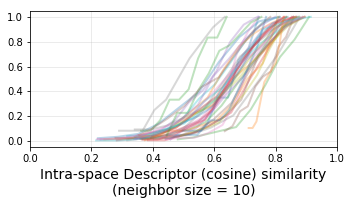

In [96]:
fig=plt.figure(figsize=(5.5, 2.5)) ##fig=plt.figure(figsize=(80, 80))

neighbor_size = 10

descriptor_similarity = []
linewidth = 5

# Of all spaces
for o_, descriptors, keypoints in qi_descriptors:
    #print(descriptors.shape,keypoints.shape)
    #pass
    #obj_name, pointCloud, triangles in centeredPointCollection:
    
    nbrs = NearestNeighbors(n_neighbors=neighbor_size, algorithm='brute').fit(keypoints[:,:3])
    distances, indices = nbrs.kneighbors(keypoints[:,:3])
    
    try:
        nearby_descriptors = descriptors[indices,:]
        refrnc_descriptors = np.reshape(np.repeat(descriptors[:,:],neighbor_size,axis=0),nearby_descriptors.shape)

        descriptor_product = np.sum(np.multiply(refrnc_descriptors,nearby_descriptors),axis=2)/(LA.norm(refrnc_descriptors,axis = 2)*LA.norm(nearby_descriptors,axis = 2))
        #print(descriptor_product.shape,refrnc_descriptors.shape, nearby_descriptors.shape)
    except Exception as e1:
        print("Error while getting descriptors,", e1)
        
    hist, values = np.histogram(np.mean(np.abs(descriptor_product),axis = 1))#, bins = np.arange(0,1.001,0.001))
    CY = np.cumsum(hist/np.sum(hist))
    plt.plot(values[1:], CY, alpha = 0.3, linewidth = 2)
    descriptor_similarity.append(np.mean(values))
    
plt.xlabel("Intra-space Descriptor (cosine) similarity\n(neighbor size = {})".format(neighbor_size), fontsize = 14)
plt.xlim(0,1)
plt.xticks(np.arange(0,1.1,0.2),fontsize = 10)
plt.grid(alpha=0.3)

#plt.savefig('plots/descriptor-similarity.pdf', format='pdf', dpi=1000,bbox_inches = 'tight')

descriptor_similarity = np.asarray(descriptor_similarity)

In [100]:
edited_spherePointCloud = spherePointCloud[:,:3]/20
edited_spherePointCloud = np.concatenate((edited_spherePointCloud,spherePointCloud[:,3:]), axis = 1)

In [55]:
spherePointCloud.shape

(482, 6)

In [56]:
edited_spherePointCloud.shape

(482, 6)

In [57]:
cubePointCloud

array([[ 1. , -1. , -1. ,  1. ,  0. ,  0. ],
       [ 1. , -0.9, -1. ,  1. ,  0. ,  0. ],
       [ 1. , -0.8, -1. ,  1. ,  0. ,  0. ],
       ...,
       [ 0.7,  0.9, -1. ,  0. ,  0. , -1. ],
       [ 0.8,  0.9, -1. ,  0. ,  0. , -1. ],
       [ 0.9,  0.9, -1. ,  0. ,  0. , -1. ]])

Average number of SS descriptors 92.15789473684211 53.5868828783733
Average similarity of SS descriptors 0.653564453125
(113, 200) (113, 6)
Average number of SI descriptors 92.5 53.629700137536716
Average similarity of SI descriptors 0.6461888363486842


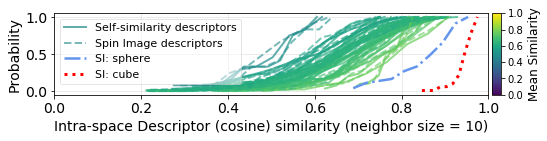

In [114]:
fig=plt.figure(figsize=(8, 1.5)) ##fig=plt.figure(figsize=(80, 80))

neighbor_size = 10

descriptor_similarity = []
descriptor_properties = []
linewidth = 5

# Of all spaces
for o_, descriptors, keypoints in qs_descriptor_set[-1][1]:
    #print(descriptors.shape,keypoints.shape)
    #pass
    #obj_name, pointCloud, triangles in centeredPointCollection
    
    try:
        nbrs = NearestNeighbors(n_neighbors=neighbor_size, algorithm='brute').fit(keypoints[:,:3])
        distances, indices = nbrs.kneighbors(keypoints[:,:3])
    
        nearby_descriptors = descriptors[indices,:]
        refrnc_descriptors = np.reshape(np.repeat(descriptors[:,:],neighbor_size,axis=0),nearby_descriptors.shape)

        descriptor_product = np.sum(np.multiply(refrnc_descriptors,nearby_descriptors),axis=2)/(LA.norm(refrnc_descriptors,axis = 2)*LA.norm(nearby_descriptors,axis = 2))
        #print(descriptor_product.shape,refrnc_descriptors.shape, nearby_descriptors.shape)
    except Exception as e1:
        print(o_,len(descriptors),"Error while getting descriptors,", e1)
        
    hist, values = np.histogram(np.mean(np.abs(descriptor_product),axis = 1))#, bins = np.arange(0,1.001,0.001))
    color = np.mean(np.abs(descriptor_product))
    CY = np.cumsum(hist/np.sum(hist))
    p1, = plt.plot(values[1:], CY, alpha = 0.7, linewidth = 2, color = mpl.cm.viridis(color), label = 'Self-similarity descriptors')
    descriptor_similarity.append(np.mean(values))
    descriptor_properties.append([
        len(descriptors),
        np.mean(np.mean(np.abs(descriptor_product),axis = 1))
    ])
    
descriptor_properties = np.asarray(descriptor_properties)
print("Average number of SS descriptors", np.mean(descriptor_properties[:,0]), np.std(descriptor_properties[:,0]))
print("Average similarity of SS descriptors", np.mean(descriptor_properties[:,1]))

# SI
descriptor_similarity = []
descriptor_properties = []
linewidth = 5

# Of all spaces
for o_, descriptors, keypoints in qi_descriptors:
    #print(descriptors.shape,keypoints.shape)
    #pass
    #obj_name, pointCloud, triangles in centeredPointCollection:
    
    nbrs = NearestNeighbors(n_neighbors=neighbor_size, algorithm='brute').fit(keypoints[:,:3])
    distances, indices = nbrs.kneighbors(keypoints[:,:3])
    
    try:
        nearby_descriptors = descriptors[indices,:]
        refrnc_descriptors = np.reshape(np.repeat(descriptors[:,:],neighbor_size,axis=0),nearby_descriptors.shape)

        descriptor_product = np.sum(np.multiply(refrnc_descriptors,nearby_descriptors),axis=2)/(LA.norm(refrnc_descriptors,axis = 2)*LA.norm(nearby_descriptors,axis = 2))
        #print(descriptor_product.shape,refrnc_descriptors.shape, nearby_descriptors.shape)
    except Exception as e1:
        print("Error while getting descriptors,", e1)
        
    hist, values = np.histogram(np.mean(np.abs(descriptor_product),axis = 1))#, bins = np.arange(0,1.001,0.001))
    color = np.mean(np.abs(descriptor_product))

    CY = np.cumsum(hist/np.sum(hist))
    p2, = plt.plot(values[1:], CY, '--',alpha = 0.6, color = mpl.cm.viridis(color), linewidth = 2, label = 'Spin Image descriptors')
    descriptor_similarity.append(np.mean(values))
    descriptor_properties.append([
        len(descriptors),
        np.mean(np.mean(np.abs(descriptor_product),axis = 1))
    ])
    
try:
    s_descriptors, s_keypoints, s_d_c = getSpinImageDescriptors(edited_spherePointCloud)
    print(s_descriptors.shape, s_keypoints.shape)

    nbrs = NearestNeighbors(n_neighbors=neighbor_size, algorithm='brute').fit(s_keypoints[:,:3])
    distances, indices = nbrs.kneighbors(s_keypoints[:,:3])
    
    nearby_descriptors = s_descriptors[indices,:]
    refrnc_descriptors = np.reshape(np.repeat(s_descriptors[:,:],neighbor_size,axis=0),nearby_descriptors.shape)

    descriptor_product = np.sum(np.multiply(refrnc_descriptors,nearby_descriptors),axis=2)/(LA.norm(refrnc_descriptors,axis = 2)*LA.norm(nearby_descriptors,axis = 2))

except Exception as e1:
    print("Error while getting normals,", e1)

hist, values = np.histogram(np.mean(np.abs(descriptor_product),axis = 1))#, bins = np.arange(0,1.001,0.001))
CY = np.cumsum(hist/np.sum(hist))
p3, = plt.plot(values[1:], CY, alpha = 1, linewidth = 2.5, color = 'cornflowerblue',
               linestyle = '-.',
               label = 'SI: sphere')


try:
    c_descriptors, c_keypoints, c_d_c = getSpinImageDescriptors(np.asarray(cubePointCloud))

    nbrs = NearestNeighbors(n_neighbors=neighbor_size, algorithm='brute').fit(c_keypoints[:,:3])
    distances, indices = nbrs.kneighbors(c_keypoints[:,:3])

    nearby_descriptors = c_descriptors[indices,:]
    refrnc_descriptors = np.reshape(np.repeat(c_descriptors[:,:],neighbor_size,axis=0),nearby_descriptors.shape)

    descriptor_product = np.sum(np.multiply(refrnc_descriptors,nearby_descriptors),axis=2)/(LA.norm(refrnc_descriptors,axis = 2)*LA.norm(nearby_descriptors,axis = 2))

except Exception as e1:
    print("Error while getting normals of cube,", e1)

hist, values = np.histogram(np.mean(np.abs(descriptor_product),axis = 1))#, bins = np.arange(0,1.001,0.001))
CY = np.cumsum(hist/np.sum(hist))
p4, = plt.plot(values[1:], CY, alpha = 2, linewidth = 3, color = 'red', linestyle =':',
               markersize = 5,
               label = 'SI: cube')

descriptor_properties = np.asarray(descriptor_properties)
print("Average number of SI descriptors", np.mean(descriptor_properties[:,0]), np.std(descriptor_properties[:,0]))
print("Average similarity of SI descriptors", np.mean(descriptor_properties[:,1]))
    
plt.xlabel("Intra-space Descriptor (cosine) similarity (neighbor size = {})".format(neighbor_size), fontsize = 14)
plt.ylabel("Probability", fontsize = 14)
plt.xlim(0,1)
plt.xticks(np.arange(0,1.1,0.2),fontsize = 14)
plt.yticks(fontsize = 14)

plt.grid(alpha=0.3)

lines = [p1, p2, p3, p4]#, p5,p6]

plt.legend(lines, [l.get_label() for l in lines], loc='upper left', framealpha = 0.5, fontsize = 11)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="2%", pad=0.05)    
cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=mpl.cm.viridis, orientation='vertical')
cb1.set_label('Mean Similarity', fontsize = 12)
plt.gcf().add_axes(ax_cb)

plt.savefig('plots/descriptor-similarity.pdf', format='pdf', dpi=1000,bbox_inches = 'tight')

/Users/deg032/Projects/3D/info3d.py:1159: RuntimeWarning: invalid value encountered in true_divide
  adjusted_scores = scores[:,:,0]*scores[:,:,-1]/scores[:,:,1]


NameError: name 'combinedProperties' is not defined

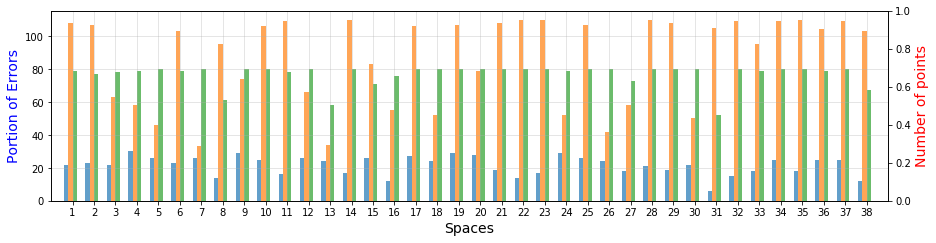

In [59]:
fig=plt.figure(figsize=(15, 3.5))

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        

ax1 = fig.subplots()
width = 0.4

ax1.set_xticks(np.arange(1, 39,1))
ax1.set_xlabel('Spaces',fontsize = 14)
ax1.grid(alpha = 0.4)
#ax1.set_ylim(0,0.05)

ax1.set_xlim(0,39)

ax1.set_ylabel('Portion of Errors', color = 'blue',fontsize = 14)

# COMPLETE
with open('results_spin_image_partials/complete_c_qpr_0.25_3_scores.pickle', 'rb') as f:
    qpr_scores = pickle.load(f)
     
err_rate, qpr_errors = getErrorRate(qpr_scores)

error_accumulation_per_object = []

for radius, error_values, error_maps in qpr_errors:
#    print(radius, error_values.shape, error_maps.shape)
    error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
#    np.sum(error_maps, axis = 0).shape)

error_per_object = np.asarray(error_accumulation_per_object)
#print(error_per_object.shape)
p1 = ax1.bar(
    np.arange(1, error_per_object.shape[1]+1,1)-1.5*0.5*width,
    np.sum(error_per_object,axis = 0),#/np.sum(error_per_object),
    width = 0.5*width, alpha = 0.7,
    label = "Complete points");

# GENERALIZED
with open('results_spin_image_partials/generalized_r_qpr_0.25_3_scores.pickle', 'rb') as f:
    qpr_scores = pickle.load(f)
    
err_rate, qpr_errors = getErrorRate(qpr_scores)

error_accumulation_per_object = []

for radius, error_values, error_maps in qpr_errors:
#    print(radius, error_values.shape, error_maps.shape)
    error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
#    np.sum(error_maps, axis = 0).shape)

g_error_per_object = np.asarray(error_accumulation_per_object)
#print(error_per_object.shape)
p2 = ax1.bar(
    np.arange(1, g_error_per_object.shape[1]+1,1)-0.5*0.5*width,
    np.sum(g_error_per_object,axis = 0),#/np.sum(g_error_per_object),
    width = 0.5*width, alpha = 0.7,
    label = "RANSAC generalized");

# LOCALIZED
with open('results_spin_image_partials_localized/c_qpr_0.25_2_scores.pickle', 'rb') as f:
    qpr_scores = pickle.load(f)
    
err_rate, qpr_errors = getErrorRate(qpr_scores)

error_accumulation_per_object = []

for radius, error_values, error_maps in qpr_errors:
#    print(radius, error_values.shape, error_maps.shape)
    error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
#    np.sum(error_maps, axis = 0).shape)

l_error_per_object = np.asarray(error_accumulation_per_object)
#print(error_per_object.shape)
p3 = ax1.bar(
    np.arange(1, l_error_per_object.shape[1]+1,1)+0.5*0.5*width,
    np.sum(l_error_per_object,axis = 0),#/np.sum(l_error_per_object),
    width = 0.5*width, alpha = 0.7,
    label = "Locally generalized");

ax2 = ax1.twinx()
ax2.set_ylabel('Number of points', color = 'red',fontsize = 14)

ax2.bar(
    np.arange(1, error_per_object.shape[1]+1,1)+1.5*0.5*width,
    combinedProperties[:,0],
    color = 'red', width = 0.5*width, alpha = 0.7,
    label = "Number of points");

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)

ax3.set_ylim(0,1.0)
ax3.set_ylabel('Similarity', color = 'magenta',fontsize = 14)

p7, = ax3.plot(
    np.arange(1, error_per_object.shape[1]+1,1),
    combinedProperties[:,2],
    '-.s',color='magenta', linewidth = 2, alpha = 0.6,
    label = "Mean normal similarity");

p8, = ax3.plot(
    np.arange(1, error_per_object.shape[1]+1,1),
    descriptor_similarity,
    '-.*',color='chocolate', linewidth = 2, alpha = 0.6,
    label = "Mean descriptor similarity");

lines = [p1, p2, p3]#, p5,p6]

ax1.legend(lines, [l.get_label() for l in lines], loc='upper left')
ax2.legend(loc='upper right')

lines = [p7, p8]

ax3.legend(lines, [l.get_label() for l in lines], loc='lower right')

properties_errors_stack = np.stack((np.sum(error_per_object,axis = 0),
                                    np.sum(g_error_per_object,axis = 0),
                                    np.sum(l_error_per_object,axis = 0),
                                    combinedProperties[:,0].flatten('C')/np.sum(combinedProperties[:,0]),
                                    combinedProperties[:,2].flatten('C'),
                                    descriptor_similarity
                                   ),axis =0)
#np.corrcoef(np.stack)
#combinedProperties[:,0].flatten('C').shape
#error_per_object.shape
error_corrcoef = np.corrcoef(properties_errors_stack)
print(error_corrcoef)
#print("Correlation of errors and point population:",error_corrcoef[1])
#print("Correlation of errors and normal similarity:",error_corrcoef[2])

#plt.savefig('plots/space-analysis.pdf', format='pdf', dpi=1000, bbox_inches = 'tight')

In [ ]:
fig=plt.figure(figsize=(15, 15))

plt.matshow(error_corrcoef,cmap=plt.get_cmap('plasma'))
plt.xticks(np.arange(0,6),
           ['Errors\nComplete','Errors\nRANSAC','Errors\nLocal','Number\nof Points','Normal\nSimilarity','Descriptor\nSimilarity'],
           fontsize = 8, rotation=40
          )
plt.yticks(np.arange(0,6),
           ['Errors\nComplete','Errors\nRANSAC','Errors\nLocal','Number of\nPoints','Normal\nSimilarity','Descriptor\nSimilarity'],
           fontsize = 8
          )
plt.clim(-1,1)
plt.colorbar()

for (i, j), z in np.ndenumerate(error_corrcoef):
    if z < 0:
        plt.text(i, j, '{:.3f}'.format(z), ha='center', va='center', color = 'white')
    else:
        plt.text(i, j, '{:.3f}'.format(z), ha='center', va='center')
        
#plt.savefig('plots/space-analysis-corrcoef.pdf', format='pdf', dpi=1000,bbox_inches = 'tight')

<BarContainer object of 38 artists>

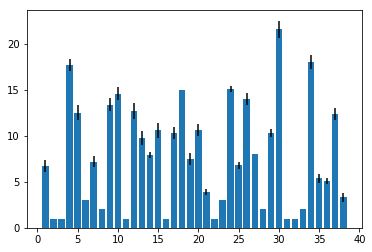

In [41]:
with open('ransac_gen_properties.pickle','rb') as f:
    ransac_gen_properties = pickle.load(f)
    
generalized_planes = []
for plane_properties in ransac_gen_properties:
    plane_count = []
    for count, properties in plane_properties[0]:
        plane_count.append(count)
    generalized_planes.append(np.asarray(plane_count))
    
generalized_planes = np.asarray(generalized_planes)
plt.bar(np.arange(1,39),np.mean(generalized_planes, axis = 1), yerr = np.std(generalized_planes, axis = 1))

In [52]:
print("Mean number of planes of top 10 spaces with high FALSE POSITIVES")
print("Raw:",np.mean(generalized_planes[[0,7,10,15,16,24,26,30,32,37],:]))
print("RANSAC:",np.mean(generalized_planes[[1,7,12,14,15,26,30,32,35,37],:]))
print("LOCAL:",np.mean(generalized_planes[[0,1,3,7,12,14,15,26,30,37],:]))

Mean number of planes of top 10 spaces with high false positives
Raw: 4.21
RANSAC: 4.38
LOCAL: 6.11


In [57]:
print("Mean number of planes of top 10 spaces with high PRECISION")
print("Raw:",np.mean(generalized_planes[[3,4,6,8,9,23,25,28,29,33],:]))
print("RANSAC:",np.mean(generalized_planes[[4,6,8,17,19,23,25,28,29,33],:]))
print("LOCAL:",np.mean(generalized_planes[[1,7,10,15,20,21,24,30,32,37],:]))

Mean number of planes of top 10 spaces with high precision
Raw: 14.44
RANSAC: 13.77
LOCAL: 2.3


In [60]:
print("Mean number of planes of top 10 spaces with high RECALL")
print("Raw:",np.mean(generalized_planes[[8,10,15,21,22,30,31,32,34,37],:]))
print("RANSAC:",np.mean(generalized_planes[[3,4,6,12,17,23,25,29,30,32],:]))
print("LOCAL:",np.mean(generalized_planes[[0,1,3,7,10,12,14,15,30,37],:]))

Mean number of planes of top 10 spaces with high RECALL
Raw: 3.21
RANSAC: 11.59
LOCAL: 5.41


In [62]:
print("Mean number of planes of top 10 spaces with least ERRORS/Privacy")
print("Raw:",np.mean(generalized_planes[[0,10,15,21,22,30,31,32,34,37],:]))
print("RANSAC:",np.mean(generalized_planes[[3,4,6,12,17,23,25,29,30,32],:]))
print("LOCAL:",np.mean(generalized_planes[[1,3,7,10,12,14,15,26,30,37],:]))

Mean number of planes of top 10 spaces with least ERRORS/Privacy
Raw: 2.54
RANSAC: 11.59
LOCAL: 5.54


# Analysing the 'more rotations' results

/Users/deg032/Projects/3D/info3d.py:1491: RuntimeWarning: invalid value encountered in true_divide
  adjusted_scores = scores[:,:,0]*scores[:,:,-1]/scores[:,:,1]


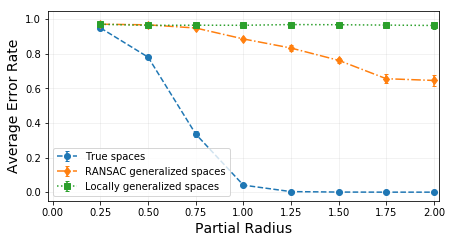

In [5]:
fig=plt.figure(figsize=(7, 3.5))

plt.grid(alpha=0.2)
plt.ylim(-0.05,1.05)
plt.xlim(-0.025,2.025)
plt.xlabel("Partial Radius", fontsize = 14)
plt.ylabel("Average Error Rate", fontsize = 14)

complete_error_rate = []
ransac_error_rate = []
local_error_rate = []

complete_errors = []
ransac_errors = []
local_errors = []


complete_scores = []
ransac_scores = []
local_scores = []

for rotation in np.arange(5):

    with open('results_more_rotations/extended_{}_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        e_scores = pickle.load(f)

    with open('results_more_rotations/extended_{}_qpr_0.25_3_properties.pickle'.format(rotation), 'rb') as f:
        e_properties = pickle.load(f)
        
    with open('results_more_rotations/{}_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        scores = pickle.load(f)

    with open('results_more_rotations/{}_qpr_0.25_3_properties.pickle'.format(rotation), 'rb') as f:
        properties = pickle.load(f)
        
    for r, score in e_scores:
        scores.append([r, score])
        
    error_rate, errors = getErrorRate(scores)
    error_rate = np.asarray(error_rate)
    complete_error_rate.append(error_rate[:,2])
    complete_scores.append(scores)
    #print(rotation,"Error Rate",error_rate[:,2])
    
    error_accumulation_per_object = []
    
    for radius, error_values, error_maps in errors:
    #    print(radius, error_values.shape, error_maps.shape)
        error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
    #    np.sum(error_maps, axis = 0).shape)

    complete_errors.append(np.asarray(error_accumulation_per_object))
    
    with open('results_more_rotations/extended_{}_g_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        e_scores = pickle.load(f)

    with open('results_more_rotations/extended_{}_g_qpr_0.25_3_properties.pickle'.format(rotation), 'rb') as f:
        e_properties = pickle.load(f)
        
    with open('results_more_rotations/{}_g_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        scores = pickle.load(f)

    with open('results_more_rotations/{}_g_qpr_0.25_3_properties.pickle'.format(rotation), 'rb') as f:
        properties = pickle.load(f)
        
    for r, score in e_scores:
        scores.append([r, score])
        
    error_rate, errors = getErrorRate(scores)
    error_rate = np.asarray(error_rate)
    ransac_error_rate.append(error_rate[:,2])
    ransac_scores.append(scores)
    
    error_accumulation_per_object = []
    
    for radius, error_values, error_maps in errors:
    #    print(radius, error_values.shape, error_maps.shape)
        error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
    #    np.sum(error_maps, axis = 0).shape)

    ransac_errors.append(np.asarray(error_accumulation_per_object))

    with open('results_more_rotations/extended_{}_l_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        e_scores = pickle.load(f)

    with open('results_more_rotations/extended_{}_l_qpr_0.25_3_properties.pickle'.format(rotation), 'rb') as f:
        e_properties = pickle.load(f)
        
    with open('results_more_rotations/{}_l_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        scores = pickle.load(f)

    with open('results_more_rotations/{}_l_qpr_0.25_3_properties.pickle'.format(rotation), 'rb') as f:
        properties = pickle.load(f)
        
    for r, score in e_scores:
        scores.append([r, score])
        
    error_rate, errors = getErrorRate(scores)
    error_rate = np.asarray(error_rate)
    local_error_rate.append(error_rate[:,2])
    local_scores.append(scores)

    error_accumulation_per_object = []
    
    for radius, error_values, error_maps in errors:
    #    print(radius, error_values.shape, error_maps.shape)
        error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
    #    np.sum(error_maps, axis = 0).shape)

    local_errors.append(np.asarray(error_accumulation_per_object))
    
complete_error_rate = np.asarray(complete_error_rate)
plt.errorbar(
    np.arange(0.25,2.1,0.25),np.mean(complete_error_rate, axis = 0),
    np.std(complete_error_rate, axis = 0),capsize = 2,
    label = 'True spaces', marker = 'o', linestyle = '--'
)

ransac_error_rate = np.asarray(ransac_error_rate)
plt.errorbar(
    np.arange(0.25,2.1,0.25),np.mean(ransac_error_rate, axis = 0),
    np.std(ransac_error_rate, axis = 0),capsize = 2,
    label = 'RANSAC generalized spaces', marker = 'd', linestyle = '-.'
)

local_error_rate = np.asarray(local_error_rate)
plt.errorbar(
    np.arange(0.25,2.1,0.25),np.mean(local_error_rate, axis = 0),
    np.std(local_error_rate, axis = 0), capsize = 2,
    label = 'Locally generalized spaces', marker = 's', linestyle = ':'
)

plt.legend(loc = 'lower left')
#plt.savefig('plots/partials-more-rotations.pdf', format='pdf', dpi=1000,bbox_inches = 'tight')

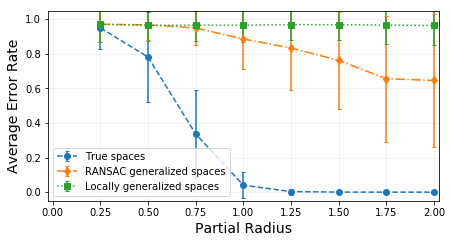

In [6]:
# Verification Error rate
fig=plt.figure(figsize=(7, 3.5))

complete_errors = np.asarray(complete_errors)
ransac_errors = np.asarray(ransac_errors)
local_errors = np.asarray(local_errors)


plt.grid(alpha=0.2)
plt.ylim(-0.05,1.05)
plt.xlim(-0.025,2.025)
plt.xlabel("Partial Radius", fontsize = 14)
plt.ylabel("Average Error Rate", fontsize = 14)

plt.errorbar(
    np.arange(0.25,2.1,0.25),np.mean(complete_errors/10.0, axis = (0, 2)),
    np.std(complete_errors/10.0, axis = (0, 2)),capsize = 2,
    label = 'True spaces', marker = 'o', linestyle = '--'
)

plt.errorbar(
    np.arange(0.25,2.1,0.25),np.mean(ransac_errors/10.0, axis = (0, 2)),
    np.std(ransac_errors/10.0, axis = (0, 2)),capsize = 2,
    label = 'RANSAC generalized spaces', marker = 'd', linestyle = '-.'
)

plt.errorbar(
    np.arange(0.25,2.1,0.25),np.mean(local_errors/10.0, axis = (0, 2)),
    np.std(local_errors/10.0, axis = (0, 2)), capsize = 2,
    label = 'Locally generalized spaces', marker = 's', linestyle = ':'
)

plt.legend(loc = 'lower left')
plt.savefig('plots/partials-more-rotations-verification.pdf', format='pdf', dpi=1000,bbox_inches = 'tight')

/Users/deg032/Projects/3D/info3d.py:1491: RuntimeWarning: invalid value encountered in true_divide
  adjusted_scores = scores[:,:,0]*scores[:,:,-1]/scores[:,:,1]
/Users/deg032/Projects/3D/info3d.py:1492: RuntimeWarning: divide by zero encountered in true_divide
  bayesian_adjusted_scores = adjusted_scores/np.sum(adjusted_scores,axis=1)
/Users/deg032/Projects/3D/info3d.py:1492: RuntimeWarning: invalid value encountered in true_divide
  bayesian_adjusted_scores = adjusted_scores/np.sum(adjusted_scores,axis=1)


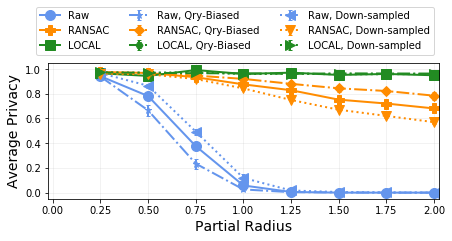

In [7]:
# Down Sampling and Biased Matching

fig=plt.figure(figsize=(7, 2.5))

plt.grid(alpha=0.2)
plt.ylim(-0.05,1.05)
plt.yticks(np.arange(0,1.1,0.2))
plt.xlim(-0.025,2.025)
plt.xlabel("Partial Radius", fontsize = 14)
plt.ylabel("Average Privacy", fontsize = 14)

b_complete_error_rate = []
b_ransac_error_rate = []
b_local_error_rate = []

b_complete_errors = []
b_ransac_errors = []
b_local_errors = []


b_complete_scores = []
b_ransac_scores = []
b_local_scores = []

d_complete_error_rate = []
d_ransac_error_rate = []
d_local_error_rate = []

d_complete_errors = []
d_ransac_errors = []
d_local_errors = []


d_complete_scores = []
d_ransac_scores = []
d_local_scores = []

for rotation in np.arange(5):

    with open('results_more_rotations/b_{}_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        b_scores = pickle.load(f)

    with open('results_more_rotations/b_{}_qpr_0.25_3_properties.pickle'.format(rotation), 'rb') as f:
        b_properties = pickle.load(f)
        
    #for r, score in e_scores:
    #    scores.append([r, score])
        
    error_rate, errors = getErrorRate(b_scores)
    error_rate = np.asarray(error_rate)
    b_complete_error_rate.append(error_rate[:,2])
    b_complete_scores.append(scores)
    #print(rotation,"Error Rate",error_rate[:,2])
    
    error_accumulation_per_object = []
    
    for radius, error_values, error_maps in errors:
    #    print(radius, error_values.shape, error_maps.shape)
        error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
    #    np.sum(error_maps, axis = 0).shape)

    b_complete_errors.append(np.asarray(error_accumulation_per_object))
        
    with open('results_more_rotations/d_{}_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        d_scores = pickle.load(f)

    with open('results_more_rotations/d_{}_qpr_0.25_3_properties.pickle'.format(rotation), 'rb') as f:
        d_properties = pickle.load(f)
        
    #for r, score in e_scores:
    #    scores.append([r, score])
        
    error_rate, errors = getErrorRate(d_scores)
    error_rate = np.asarray(error_rate)
    d_complete_error_rate.append(error_rate[:,2])
    d_complete_scores.append(scores)
    #print(rotation,"Error Rate",error_rate[:,2])
    
    error_accumulation_per_object = []
    
    for radius, error_values, error_maps in errors:
    #    print(radius, error_values.shape, error_maps.shape)
        error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
    #    np.sum(error_maps, axis = 0).shape)

    d_complete_errors.append(np.asarray(error_accumulation_per_object))
    
    with open('results_more_rotations/b_{}_g_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        b_scores = pickle.load(f)

    with open('results_more_rotations/b_{}_g_qpr_0.25_3_properties.pickle'.format(rotation), 'rb') as f:
        b_properties = pickle.load(f)
        
    error_rate, errors = getErrorRate(b_scores)
    error_rate = np.asarray(error_rate)
    b_ransac_error_rate.append(error_rate[:,2])
    b_ransac_scores.append(scores)
    
    error_accumulation_per_object = []
    
    for radius, error_values, error_maps in errors:
    #    print(radius, error_values.shape, error_maps.shape)
        error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
    #    np.sum(error_maps, axis = 0).shape)

    b_ransac_errors.append(np.asarray(error_accumulation_per_object))
        
    with open('results_more_rotations/d_{}_g_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        d_scores = pickle.load(f)

    with open('results_more_rotations/d_{}_g_qpr_0.25_3_properties.pickle'.format(rotation), 'rb') as f:
        d_properties = pickle.load(f)
        
    error_rate, errors = getErrorRate(d_scores)
    error_rate = np.asarray(error_rate)
    d_ransac_error_rate.append(error_rate[:,2])
    d_ransac_scores.append(scores)
    
    error_accumulation_per_object = []
    
    for radius, error_values, error_maps in errors:
    #    print(radius, error_values.shape, error_maps.shape)
        error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
    #    np.sum(error_maps, axis = 0).shape)

    d_ransac_errors.append(np.asarray(error_accumulation_per_object))

    with open('results_more_rotations/b_{}_l_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        b_scores = pickle.load(f)

    with open('results_more_rotations/b_{}_l_qpr_0.25_3_properties.pickle'.format(rotation), 'rb') as f:
        b_properties = pickle.load(f)
        
    error_rate, errors = getErrorRate(b_scores)
    error_rate = np.asarray(error_rate)
    b_local_error_rate.append(error_rate[:,2])
    b_local_scores.append(scores)

    error_accumulation_per_object = []
    
    for radius, error_values, error_maps in errors:
    #    print(radius, error_values.shape, error_maps.shape)
        error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
    #    np.sum(error_maps, axis = 0).shape)

    b_local_errors.append(np.asarray(error_accumulation_per_object))
        
    with open('results_more_rotations/d_{}_l_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        d_scores = pickle.load(f)

    with open('results_more_rotations/d_{}_l_qpr_0.25_3_properties.pickle'.format(rotation), 'rb') as f:
        d_properties = pickle.load(f)
        
    error_rate, errors = getErrorRate(d_scores)
    error_rate = np.asarray(error_rate)
    d_local_error_rate.append(error_rate[:,2])
    d_local_scores.append(scores)

    error_accumulation_per_object = []
    
    for radius, error_values, error_maps in errors:
    #    print(radius, error_values.shape, error_maps.shape)
        error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
    #    np.sum(error_maps, axis = 0).shape)

    d_local_errors.append(np.asarray(error_accumulation_per_object))
    
#complete_error_rate = np.asarray(complete_error_rate)
with open('results_spin_image_partials/complete_c_qpr_0.25_3_scores.pickle', 'rb') as f:
    qpr_scores = pickle.load(f)
        
error_rate, errors = getErrorRate(qpr_scores,rank=1)
complete_error_rate = np.asarray(error_rate)
plt.plot(
    complete_error_rate[:,0],complete_error_rate[:,2],
    #np.arange(0.25,2.1,0.25),np.mean(complete_error_rate, axis = 0),
    #np.std(complete_error_rate, axis = 0),
    #capsize = 2,
    label = 'Raw', marker = 'o', linestyle = '-',
    linewidth = 2, color = 'cornflowerblue',
    markersize = 10
)

with open('results_spin_image_partials/generalized_r_qpr_0.25_3_scores.pickle', 'rb') as f:
    qpr_scores = pickle.load(f)

error_rate, errors = getErrorRate(qpr_scores,rank=1)
ransac_error_rate = np.asarray(error_rate)
plt.plot(
    ransac_error_rate[:,0],ransac_error_rate[:,2],
    #np.arange(0.25,2.1,0.25),np.mean(ransac_error_rate, axis = 0),
    #np.std(ransac_error_rate, axis = 0),
    #capsize = 2,
    label = 'RANSAC', marker = 'P', linestyle = '-',
    linewidth = 2, color = 'darkorange',
    markersize = 10
)


with open('results_spin_image_partials_localized/c_qpr_0.25_2_scores.pickle', 'rb') as f:
    qpr_scores = pickle.load(f)

error_rate, errors = getErrorRate(qpr_scores,rank=1)
local_error_rate = np.asarray(error_rate)
plt.plot(
    local_error_rate[:,0],local_error_rate[:,2],
    #np.std(local_error_rate, axis = 0),
    #capsize = 2,
    label = 'LOCAL', marker = 's', linestyle = '-',
    linewidth = 2, color = 'forestgreen',
    markersize = 10
)

b_complete_error_rate = np.asarray(b_complete_error_rate)
plt.errorbar(
    np.arange(0.25,2.1,0.25),np.mean(b_complete_error_rate, axis = 0),
    np.std(b_complete_error_rate, axis = 0),capsize = 2,
    label = 'Raw, Qry-Biased', marker = '*', linestyle = '-.',
    linewidth = 2,color = 'cornflowerblue',
    markersize = 7
)

b_ransac_error_rate = np.asarray(b_ransac_error_rate)
plt.errorbar(
    np.arange(0.25,2.1,0.25),np.mean(b_ransac_error_rate, axis = 0),
    np.std(b_ransac_error_rate, axis = 0),capsize = 2,
    label = 'RANSAC, Qry-Biased', marker = 'D', linestyle = '-.',
    linewidth = 2,color = 'darkorange',
    markersize = 7
)

b_local_error_rate = np.asarray(b_local_error_rate)
plt.errorbar(
    np.arange(0.25,2.1,0.25),np.mean(b_local_error_rate, axis = 0),
    np.std(b_local_error_rate, axis = 0), capsize = 2,
    label = 'LOCAL, Qry-Biased', marker = 'H', linestyle = '-.',
    linewidth = 2,color = 'forestgreen',
    markersize = 7
)

d_complete_error_rate = np.asarray(d_complete_error_rate)
plt.errorbar(
    np.arange(0.25,2.1,0.25),np.mean(d_complete_error_rate, axis = 0),
    np.std(d_complete_error_rate, axis = 0),capsize = 2,
    label = 'Raw, Down-sampled', marker = '<', linestyle = ':',
    linewidth = 2,color = 'cornflowerblue',
    markersize = 10
)

d_ransac_error_rate = np.asarray(d_ransac_error_rate)
plt.errorbar(
    np.arange(0.25,2.1,0.25),np.mean(d_ransac_error_rate, axis = 0),
    np.std(d_ransac_error_rate, axis = 0),capsize = 2,
    label = 'RANSAC, Down-sampled', marker = 'v', linestyle = ':',
    linewidth = 2,color = 'darkorange',
    markersize = 10
)

d_local_error_rate = np.asarray(d_local_error_rate)
plt.errorbar(
    np.arange(0.25,2.1,0.25),np.mean(d_local_error_rate, axis = 0),
    np.std(d_local_error_rate, axis = 0), capsize = 2,
    label = 'LOCAL, Down-sampled', marker = '>', linestyle = ':',
    linewidth = 2,color = 'forestgreen',
    markersize = 10
)

plt.legend(bbox_to_anchor=(1, 1.45),
           ncol=3, fancybox=True, fontsize = 10)
plt.savefig('plots/partials-more-rotations-no-extra.pdf', format='pdf', dpi=1000,bbox_inches = 'tight')

/Users/deg032/Projects/3D/info3d.py:1491: RuntimeWarning: invalid value encountered in true_divide
  adjusted_scores = scores[:,:,0]*scores[:,:,-1]/scores[:,:,1]
/Users/deg032/Projects/3D/info3d.py:1492: RuntimeWarning: divide by zero encountered in true_divide
  bayesian_adjusted_scores = adjusted_scores/np.sum(adjusted_scores,axis=1)
/Users/deg032/Projects/3D/info3d.py:1492: RuntimeWarning: invalid value encountered in true_divide
  bayesian_adjusted_scores = adjusted_scores/np.sum(adjusted_scores,axis=1)


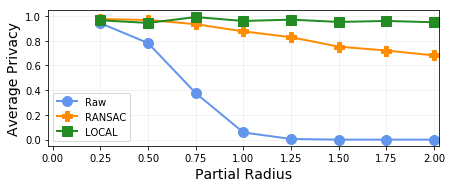

In [10]:
# Down Sampling and Biased Matching

fig=plt.figure(figsize=(7, 2.5))

plt.grid(alpha=0.2)
plt.ylim(-0.05,1.05)
plt.yticks(np.arange(0,1.1,0.2))
plt.xlim(-0.025,2.025)
plt.xlabel("Partial Radius", fontsize = 14)
plt.ylabel("Average Privacy", fontsize = 14)

b_complete_error_rate = []
b_ransac_error_rate = []
b_local_error_rate = []

b_complete_errors = []
b_ransac_errors = []
b_local_errors = []


b_complete_scores = []
b_ransac_scores = []
b_local_scores = []

d_complete_error_rate = []
d_ransac_error_rate = []
d_local_error_rate = []

d_complete_errors = []
d_ransac_errors = []
d_local_errors = []


d_complete_scores = []
d_ransac_scores = []
d_local_scores = []

for rotation in np.arange(5):

    with open('results_more_rotations/b_{}_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        b_scores = pickle.load(f)

    with open('results_more_rotations/b_{}_qpr_0.25_3_properties.pickle'.format(rotation), 'rb') as f:
        b_properties = pickle.load(f)
        
    #for r, score in e_scores:
    #    scores.append([r, score])
        
    error_rate, errors = getErrorRate(b_scores)
    error_rate = np.asarray(error_rate)
    b_complete_error_rate.append(error_rate[:,2])
    b_complete_scores.append(scores)
    #print(rotation,"Error Rate",error_rate[:,2])
    
    error_accumulation_per_object = []
    
    for radius, error_values, error_maps in errors:
    #    print(radius, error_values.shape, error_maps.shape)
        error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
    #    np.sum(error_maps, axis = 0).shape)

    b_complete_errors.append(np.asarray(error_accumulation_per_object))
        
    with open('results_more_rotations/d_{}_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        d_scores = pickle.load(f)

    with open('results_more_rotations/d_{}_qpr_0.25_3_properties.pickle'.format(rotation), 'rb') as f:
        d_properties = pickle.load(f)
        
    #for r, score in e_scores:
    #    scores.append([r, score])
        
    error_rate, errors = getErrorRate(d_scores)
    error_rate = np.asarray(error_rate)
    d_complete_error_rate.append(error_rate[:,2])
    d_complete_scores.append(scores)
    #print(rotation,"Error Rate",error_rate[:,2])
    
    error_accumulation_per_object = []
    
    for radius, error_values, error_maps in errors:
    #    print(radius, error_values.shape, error_maps.shape)
        error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
    #    np.sum(error_maps, axis = 0).shape)

    d_complete_errors.append(np.asarray(error_accumulation_per_object))
    
    with open('results_more_rotations/b_{}_g_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        b_scores = pickle.load(f)

    with open('results_more_rotations/b_{}_g_qpr_0.25_3_properties.pickle'.format(rotation), 'rb') as f:
        b_properties = pickle.load(f)
        
    error_rate, errors = getErrorRate(b_scores)
    error_rate = np.asarray(error_rate)
    b_ransac_error_rate.append(error_rate[:,2])
    b_ransac_scores.append(scores)
    
    error_accumulation_per_object = []
    
    for radius, error_values, error_maps in errors:
    #    print(radius, error_values.shape, error_maps.shape)
        error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
    #    np.sum(error_maps, axis = 0).shape)

    b_ransac_errors.append(np.asarray(error_accumulation_per_object))
        
    with open('results_more_rotations/d_{}_g_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        d_scores = pickle.load(f)

    with open('results_more_rotations/d_{}_g_qpr_0.25_3_properties.pickle'.format(rotation), 'rb') as f:
        d_properties = pickle.load(f)
        
    error_rate, errors = getErrorRate(d_scores)
    error_rate = np.asarray(error_rate)
    d_ransac_error_rate.append(error_rate[:,2])
    d_ransac_scores.append(scores)
    
    error_accumulation_per_object = []
    
    for radius, error_values, error_maps in errors:
    #    print(radius, error_values.shape, error_maps.shape)
        error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
    #    np.sum(error_maps, axis = 0).shape)

    d_ransac_errors.append(np.asarray(error_accumulation_per_object))

    with open('results_more_rotations/b_{}_l_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        b_scores = pickle.load(f)

    with open('results_more_rotations/b_{}_l_qpr_0.25_3_properties.pickle'.format(rotation), 'rb') as f:
        b_properties = pickle.load(f)
        
    error_rate, errors = getErrorRate(b_scores)
    error_rate = np.asarray(error_rate)
    b_local_error_rate.append(error_rate[:,2])
    b_local_scores.append(scores)

    error_accumulation_per_object = []
    
    for radius, error_values, error_maps in errors:
    #    print(radius, error_values.shape, error_maps.shape)
        error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
    #    np.sum(error_maps, axis = 0).shape)

    b_local_errors.append(np.asarray(error_accumulation_per_object))
        
    with open('results_more_rotations/d_{}_l_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        d_scores = pickle.load(f)

    with open('results_more_rotations/d_{}_l_qpr_0.25_3_properties.pickle'.format(rotation), 'rb') as f:
        d_properties = pickle.load(f)
        
    error_rate, errors = getErrorRate(d_scores)
    error_rate = np.asarray(error_rate)
    d_local_error_rate.append(error_rate[:,2])
    d_local_scores.append(scores)

    error_accumulation_per_object = []
    
    for radius, error_values, error_maps in errors:
    #    print(radius, error_values.shape, error_maps.shape)
        error_accumulation_per_object.append(np.sum(error_maps, axis = 0))
    #    np.sum(error_maps, axis = 0).shape)

    d_local_errors.append(np.asarray(error_accumulation_per_object))
    
#complete_error_rate = np.asarray(complete_error_rate)
with open('results_spin_image_partials/complete_c_qpr_0.25_3_scores.pickle', 'rb') as f:
    qpr_scores = pickle.load(f)
        
error_rate, errors = getErrorRate(qpr_scores,rank=1)
complete_error_rate = np.asarray(error_rate)
plt.plot(
    complete_error_rate[:,0],complete_error_rate[:,2],
    #np.arange(0.25,2.1,0.25),np.mean(complete_error_rate, axis = 0),
    #np.std(complete_error_rate, axis = 0),
    #capsize = 2,
    label = 'Raw', marker = 'o', linestyle = '-',
    linewidth = 2, color = 'cornflowerblue',
    markersize = 10
)

with open('results_spin_image_partials/generalized_r_qpr_0.25_3_scores.pickle', 'rb') as f:
    qpr_scores = pickle.load(f)

error_rate, errors = getErrorRate(qpr_scores,rank=1)
ransac_error_rate = np.asarray(error_rate)
plt.plot(
    ransac_error_rate[:,0],ransac_error_rate[:,2],
    #np.arange(0.25,2.1,0.25),np.mean(ransac_error_rate, axis = 0),
    #np.std(ransac_error_rate, axis = 0),
    #capsize = 2,
    label = 'RANSAC', marker = 'P', linestyle = '-',
    linewidth = 2, color = 'darkorange',
    markersize = 10
)


with open('results_spin_image_partials_localized/c_qpr_0.25_2_scores.pickle', 'rb') as f:
    qpr_scores = pickle.load(f)

error_rate, errors = getErrorRate(qpr_scores,rank=1)
local_error_rate = np.asarray(error_rate)
plt.plot(
    local_error_rate[:,0],local_error_rate[:,2],
    #np.std(local_error_rate, axis = 0),
    #capsize = 2,
    label = 'LOCAL', marker = 's', linestyle = '-',
    linewidth = 2, color = 'forestgreen',
    markersize = 10
)



plt.legend(#bbox_to_anchor=(1, 1.45),
           ncol=1, fancybox=True, fontsize = 10, loc = "lower left")
plt.savefig('plots/partials-more-rotations-no-extra.pdf', format='pdf', dpi=1000,bbox_inches = 'tight')

In [ ]:
markers = ['o','D','s','<','*']

In [85]:
def getFalsePositiveRate(qpr_scores, rank = 1):
    qpr_errors = []
    for radius, _scores in qpr_scores:
        #print(radius)
        fp_errors_map = getFalsePositiveErrorMaps(_scores, rank = rank)
        #fp_errors_accum = np.sum(fp_errors_map,axis = 0)
        #print(radius,fp_errors_accum.shape)
#        qpr_error_rate.append([
#            radius,
#            np.mean(_errors[:,1]/38), # mean unweighted scores,
#            np.mean(_errors[:,2]/38), # mean weighted scores,
#            np.std(_errors[:,2]/38)
#        ])
        qpr_errors.append([
            radius,
            fp_errors_map
        ])
        
    return qpr_errors#qpr_error_rate, qpr_errors

def getFalsePositiveErrorMaps(_scores, rank = 1):
    
    _errors_map = []

    for res, scores in _scores:

        _error_map = np.zeros(scores.shape[:-1])

        adjusted_scores = scores[:,:,0]*scores[:,:,-1]/scores[:,:,1]
        #print(_error_map.shape,adjusted_scores.shape)
        
        w_errors = 0

        for i,h in enumerate(adjusted_scores):         
            _error_map[i,np.argmax(h)] = 1
                    #print(i,np.argsort(h)[-5:])
                    #w_errors += 1
                    
        _errors_map.append(_error_map)
        
        #print("   ",res,_error_map)
    
    return np.asarray(_errors_map)


In [86]:
complete_fp_map = []

ransac_fp_map = []

local_fp_map = []

for rotation in np.arange(5):

    with open('results_more_rotations/extended_{}_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        e_scores = pickle.load(f)
        
    with open('results_more_rotations/{}_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        scores = pickle.load(f)
        
    for r, score in e_scores:
        scores.append([r, score])
        
    # COMPLETE
    fp_errors = getFalsePositiveRate(scores[:])
    fp_error_map = []
    for radius, fp_error in fp_errors:
        fp_errors_accum = np.sum(fp_error,axis = 0)
        fp_error_map.append(fp_errors_accum)
        
    fp_error_map = np.asarray(fp_error_map)
    
    complete_fp_map.append(np.sum(fp_error_map,axis = 0))
    
    with open('results_more_rotations/extended_{}_g_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        e_scores = pickle.load(f)
        
    with open('results_more_rotations/{}_g_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        scores = pickle.load(f)
        
    for r, score in e_scores:
        scores.append([r, score])
        
    # RANSAC 
    fp_errors = getFalsePositiveRate(scores[:])
    fp_error_map = []
    for radius, fp_error in fp_errors:
        fp_errors_accum = np.sum(fp_error,axis = 0)
        fp_error_map.append(fp_errors_accum)
        
    fp_error_map = np.asarray(fp_error_map)
    ransac_fp_map.append(np.sum(fp_error_map,axis = 0))
    
    with open('results_more_rotations/extended_{}_l_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        e_scores = pickle.load(f)
        
    with open('results_more_rotations/{}_l_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        scores = pickle.load(f)
        
    for r, score in e_scores:
        scores.append([r, score])
        
    # RANSAC 
    fp_errors = getFalsePositiveRate(scores[:])
    fp_error_map = []
    for radius, fp_error in fp_errors:
        fp_errors_accum = np.sum(fp_error,axis = 0)
        fp_error_map.append(fp_errors_accum)
        
    fp_error_map = np.asarray(fp_error_map)
    local_fp_map.append(np.sum(fp_error_map,axis = 0))
 

/Users/deg032/anaconda3/envs/p35_env/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in true_divide


True Positives [299. 291. 284. 273. 284. 299. 282. 314. 249. 263. 355. 270. 293. 298.
 278. 330. 280. 274. 257. 267. 295. 313. 346. 261. 294. 270. 311. 304.
 289. 283. 349. 333. 317. 266. 322. 275. 282. 341.]
Complete: Recall = 0.7362 (0.0671), Precision = 0.7930 (0.1684)
[0.7475 0.7275 0.71   0.6825 0.71   0.7475 0.705  0.785  0.6225 0.6575
 0.8875 0.675  0.7325 0.745  0.695  0.825  0.7    0.685  0.6425 0.6675
 0.7375 0.7825 0.865  0.6525 0.735  0.675  0.7775 0.76   0.7225 0.7075
 0.8725 0.8325 0.7925 0.665  0.805  0.6875 0.705  0.8525]
[ 0 30 10 16 37  7 26 24 32 20 15  1 22 14 34  2 36  5 12 31 27 35 18 21
 13 11 17 19  9  8 23  4  3 28  6 29 25 33]
[0.39602649 0.74045802 0.79551821 0.975      0.96928328 0.8125
 0.9825784  0.54895105 0.94676806 0.94265233 0.48365123 0.89403974
 0.81615599 0.88955224 0.75749319 0.73496659 0.5204461  0.910299
 0.86531987 0.92708333 0.73019802 0.8718663  0.74730022 0.94909091
 0.66666667 0.98901099 0.55535714 0.84679666 0.97966102 0.98606272
 0.4395466

/Users/deg032/anaconda3/envs/p35_env/lib/python3.5/site-packages/ipykernel/__main__.py:133: RuntimeWarning: invalid value encountered in true_divide


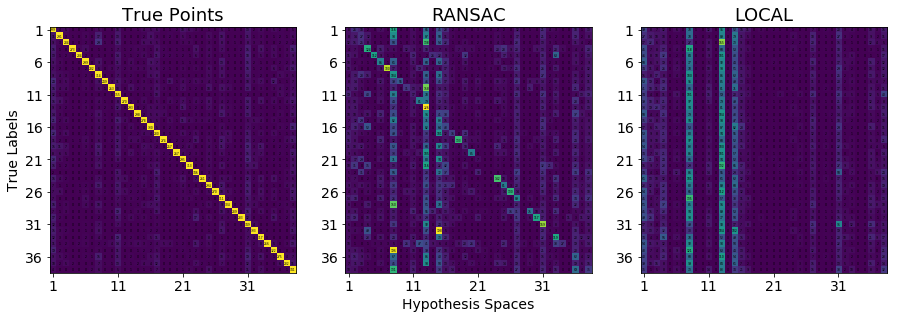

In [87]:
fig=plt.figure(figsize=(15, 5))

fp_map = np.asarray(complete_fp_map)

ax1 = fig.add_subplot(131)

ax1.imshow(np.sum(fp_map,axis = 0),vmin=0, vmax=200)
ax1.set_title('True Points', fontsize = 18)
ax1.set_xticklabels(np.arange(-9,39,10))
ax1.set_yticklabels(np.arange(-4,39,5))
ax1.tick_params(axis="x", labelsize=14)
ax1.tick_params(axis="y", labelsize=14)
ax2.set_xlabel("Hypothesis Spaces", fontsize = 14)
ax1.set_ylabel("True Labels",fontsize = 14)

#print(np.sum(fp_error_map,axis = 0))
#print(np.sum(fp_error_map, axis = (0,1))
positives = np.sum(fp_map, axis = (0,1))
true_positives = np.diagonal(np.sum(fp_map,axis = 0))
false_positives = positives - true_positives
false_negatives = np.sum(fp_map, axis = (0,2)) - np.amax(np.sum(fp_map,axis = 0),axis = 0)
true_negatives = np.sum(fp_map) - false_positives - false_negatives - true_positives
#print(true_negatives)

accuracy = (true_positives + true_negatives)/(true_positives + false_positives + true_negatives + false_negatives)
#print("Positives",positives)
print("True Positives",true_positives)
#print("Accuracy = {} {} ({})".format(accuracy,np.mean(accuracy),np.std(accuracy)))
#print("False Positives",false_positives)
#print("Spaces labelled most fp  \n",np.argsort(-positives + true_positives)+1)
recall = true_positives/(true_positives + false_negatives)
precision = true_positives/(true_positives + false_positives)
print("Complete: Recall = {:.4f} ({:.4f}), Precision = {:.4f} ({:.4f})".format(np.mean(recall),np.std(recall),np.mean(precision),np.std(precision)))
print(recall)
print(np.argsort(precision))
print(precision)
print(np.argsort(precision))

complete_properties = [
    positives,
    true_positives,
    false_negatives,
    recall,
    precision
]

#print("Accuracy =",(true_positives + )/())

for (i, j), z in np.ndenumerate(np.sum(fp_map,axis = 0)):
    ax1.text(j, i, '{}'.format(int(z)), ha='center', va='center', fontsize = 3)
  

fp_map = np.asarray(ransac_fp_map)

ax2 = fig.add_subplot(132)
#ax2.grid(alpha=0.2)

ax2.imshow(np.sum(fp_map,axis = 0),vmin=0, vmax=200)
ax2.set_title('RANSAC', fontsize = 18)
ax2.set_xticklabels(np.arange(-9,39,10))
ax2.set_yticklabels(np.arange(-4,39,5))
ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14)
ax2.set_xlabel("Hypothesis Spaces", fontsize = 14)

#print(np.sum(fp_error_map,axis = 0))
#print(np.sum(fp_error_map, axis = (0,1))
positives = np.sum(fp_map, axis = (0,1))
true_positives = np.diagonal(np.sum(fp_map,axis = 0))
false_positives = positives - true_positives
false_negatives = np.sum(fp_map, axis = (0,2)) - np.amax(np.sum(fp_map,axis = 0),axis = 0)
true_negatives = np.sum(fp_map) - false_positives - false_negatives - true_positives
#print(true_negatives)

accuracy = (true_positives + true_negatives)/(true_positives + false_positives + true_negatives + false_negatives)
#print("Positives",positives)
print("True Positives",true_positives)
#print("Accuracy = {} {} ({})".format(accuracy,np.mean(accuracy),np.std(accuracy)))
#print("False Positives",false_positives)
#print("Spaces labelled most fp  \n",np.argsort(-positives + true_positives)+1)
recall = true_positives/np.sum(fp_map, axis = (0,2))
precision = true_positives/positives
print("RANSAC: Recall = {:.4f} ({:.4f}), Precision = {:.4f} ({:.4f})".format(np.mean(recall),np.std(recall),np.mean(precision),np.std(precision)))
print(recall)
print(np.argsort(precision))
print(precision)
print(np.argsort(precision))
#print("Accuracy =",(true_positives + )/())

ransac_properties = [
    positives,
    true_positives,
    false_negatives,
    recall,
    precision
]

for (i, j), z in np.ndenumerate(np.sum(fp_map,axis = 0)):
    ax2.text(j, i, '{}'.format(int(z)), ha='center', va='center', fontsize = 3)
    
fp_map = np.asarray(local_fp_map)

ax3 = fig.add_subplot(133)
#ax3.grid(alpha=0.2)

cax = ax3.imshow(np.sum(fp_map,axis = 0),vmin=0, vmax=200)

ax3.set_title('LOCAL', fontsize = 18)
ax3.set_xticklabels(np.arange(-9,39,10))
ax3.set_yticklabels(np.arange(-4,39,5))
ax3.tick_params(axis="x", labelsize=14)
ax3.tick_params(axis="y", labelsize=14)
ax2.set_xlabel("Hypothesis Spaces", fontsize = 14)

#print(np.sum(fp_error_map,axis = 0))
#print(np.sum(fp_error_map, axis = (0,1))
positives = np.sum(fp_map, axis = (0,1))
true_positives = np.diagonal(np.sum(fp_map,axis = 0))
false_positives = positives - true_positives
false_negatives = np.sum(fp_map, axis = (0,2)) - np.amax(np.sum(fp_map,axis = 0),axis = 0)
true_negatives = np.sum(fp_map) - false_positives - false_negatives - true_positives
#print(true_negatives)

accuracy = (true_positives + true_negatives)/(true_positives + false_positives + true_negatives + false_negatives)
#print("Positives",positives)
print("True Positives",true_positives)
print("Positives",positives)
#print("Accuracy = {} {} ({})".format(accuracy,np.mean(accuracy),np.std(accuracy)))
#print("False Positives",false_positives)
#print("Spaces labelled most fp  \n",np.argsort(-positives + true_positives)+1)
recall = true_positives/np.sum(fp_map, axis = (0,2))
#print("Recall = {} ({})".format(np.mean(recall),np.std(recall)))
precision = true_positives/positives
print("LOCAL: Recall = {:.4f} ({:.4f}), Precision = {:.4f} ({:.4f})".format(np.mean(recall),np.std(recall),np.mean(np.nan_to_num(precision)),np.std(np.nan_to_num(precision))))
print(recall)
print(np.argsort(precision))
print(precision)
print(np.argsort(precision))

#print("Accuracy =",(true_positives + )/())

local_properties = [
    positives,
    true_positives,
    false_negatives,
    recall,
    precision
]

for (i, j), z in np.ndenumerate(np.sum(fp_map,axis = 0)):
    ax3.text(j, i, '{}'.format(int(z)), ha='center', va='center', fontsize = 3)
    
#plt.savefig('plots/classification-maps-text-0.25.pdf', format='pdf', dpi=1000,bbox_inches = 'tight')

In [88]:
complete_fp_properties = []
ransac_fp_properties = []
local_fp_properties = []

for r_i in np.arange(8):

    complete_fp_map = []

    ransac_fp_map = []

    local_fp_map = []

    for rotation in np.arange(5):

        with open('results_more_rotations/extended_{}_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
            e_scores = pickle.load(f)

        with open('results_more_rotations/{}_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
            scores = pickle.load(f)

        for r, score in e_scores:
            scores.append([r, score])

        # COMPLETE
        fp_errors = getFalsePositiveRate([scores[r_i]])
        fp_error_map = []
        for radius, fp_error in fp_errors:
            fp_errors_accum = np.sum(fp_error,axis = 0)
            fp_error_map.append(fp_errors_accum)

        fp_error_map = np.asarray(fp_error_map)

        complete_fp_map.append(np.sum(fp_error_map,axis = 0))

        with open('results_more_rotations/extended_{}_g_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
            e_scores = pickle.load(f)

        with open('results_more_rotations/{}_g_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
            scores = pickle.load(f)

        for r, score in e_scores:
            scores.append([r, score])

        # RANSAC 
        fp_errors = getFalsePositiveRate([scores[r_i]])
        fp_error_map = []
        for radius, fp_error in fp_errors:
            fp_errors_accum = np.sum(fp_error,axis = 0)
            fp_error_map.append(fp_errors_accum)

        fp_error_map = np.asarray(fp_error_map)
        ransac_fp_map.append(np.sum(fp_error_map,axis = 0))

        with open('results_more_rotations/extended_{}_l_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
            e_scores = pickle.load(f)

        with open('results_more_rotations/{}_l_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
            scores = pickle.load(f)

        for r, score in e_scores:
            scores.append([r, score])

        # RANSAC 
        fp_errors = getFalsePositiveRate([scores[r_i]])
        fp_error_map = []
        for radius, fp_error in fp_errors:
            fp_errors_accum = np.sum(fp_error,axis = 0)
            fp_error_map.append(fp_errors_accum)

        fp_error_map = np.asarray(fp_error_map)
        local_fp_map.append(np.sum(fp_error_map,axis = 0))
        
    fp_map = np.asarray(complete_fp_map)
        
    positives = np.sum(fp_map, axis = (0,1))
    true_positives = np.diagonal(np.sum(fp_map,axis = 0))
    false_positives = positives - true_positives
    false_negatives = np.sum(fp_map, axis = (0,2)) - np.amax(np.sum(fp_map,axis = 0),axis = 0)
    true_negatives = np.sum(fp_map) - false_positives - false_negatives - true_positives
    #print(true_negatives)

    accuracy = (true_positives + true_negatives)/(true_positives + false_positives + true_negatives + false_negatives)
    recall = true_positives/(true_positives + false_negatives)
    precision = true_positives/(true_positives + false_positives)
    
    complete_fp_properties.append([
        recall,
        precision,
        accuracy
    ])
    
    fp_map = np.asarray(ransac_fp_map)
        
    positives = np.sum(fp_map, axis = (0,1))
    true_positives = np.diagonal(np.sum(fp_map,axis = 0))
    false_positives = positives - true_positives
    false_negatives = np.sum(fp_map, axis = (0,2)) - np.amax(np.sum(fp_map,axis = 0),axis = 0)
    true_negatives = np.sum(fp_map) - false_positives - false_negatives - true_positives
    #print(true_negatives)

    accuracy = (true_positives + true_negatives)/(true_positives + false_positives + true_negatives + false_negatives)
    recall = true_positives/(true_positives + false_negatives)
    precision = true_positives/(true_positives + false_positives)
    
    ransac_fp_properties.append([
        recall,
        precision,
        accuracy
    ])
    
    fp_map = np.asarray(local_fp_map)
        
    positives = np.sum(fp_map, axis = (0,1))
    true_positives = np.diagonal(np.sum(fp_map,axis = 0))
    false_positives = positives - true_positives
    false_negatives = np.sum(fp_map, axis = (0,2)) - np.amax(np.sum(fp_map,axis = 0),axis = 0)
    true_negatives = np.sum(fp_map) - false_positives - false_negatives - true_positives
    #print(true_negatives)

    accuracy = (true_positives + true_negatives)/(true_positives + false_positives + true_negatives + false_negatives)
    recall = true_positives/(true_positives + false_negatives)
    precision = true_positives/(true_positives + false_positives)
    
    local_fp_properties.append([
        recall,
        precision,
        accuracy
    ])
    


/Users/deg032/anaconda3/envs/p35_env/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in true_divide
/Users/deg032/anaconda3/envs/p35_env/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: invalid value encountered in true_divide
/Users/deg032/anaconda3/envs/p35_env/lib/python3.5/site-packages/ipykernel/__main__.py:103: RuntimeWarning: invalid value encountered in true_divide
/Users/deg032/anaconda3/envs/p35_env/lib/python3.5/site-packages/ipykernel/__main__.py:122: RuntimeWarning: invalid value encountered in true_divide


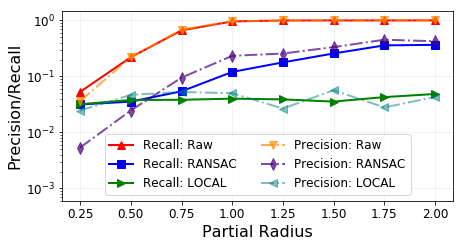

In [89]:
fig=plt.figure(figsize=(7, 3.5))

plt.grid(alpha=0.2)
plt.ylim(0.0006,1.5)
#plt.xlim(-0.025,2.025)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Partial Radius", fontsize = 16)
plt.ylabel("Precision/Recall", fontsize = 16)

complete_fp_properties = np.nan_to_num(np.asarray(complete_fp_properties))
ransac_fp_properties = np.nan_to_num(np.asarray(ransac_fp_properties))
local_fp_properties = np.nan_to_num(np.asarray(local_fp_properties))

plt.semilogy(np.arange(0.25,2.1,0.25),np.mean(complete_fp_properties[:,0,:],axis = 1),'-^', color = 'red',
             linewidth = 2, markersize = 8,
             label = 'Recall: Raw')
plt.semilogy(np.arange(0.25,2.1,0.25),np.mean(ransac_fp_properties[:,0,:],axis = 1),'b-s',
             linewidth = 2, markersize = 8,
             label = 'Recall: RANSAC')
plt.semilogy(np.arange(0.25,2.1,0.25),np.mean(local_fp_properties[:,0,:],axis = 1),'g->',
             linewidth = 2, markersize = 8,
             label = 'Recall: LOCAL')
plt.semilogy(np.arange(0.25,2.1,0.25),np.mean(complete_fp_properties[:,1,:],axis = 1),'-.v', color = 'darkorange',
             linewidth = 2, markersize = 8, alpha = 0.7,
             label = 'Precision: Raw')
plt.semilogy(np.arange(0.25,2.1,0.25),np.mean(ransac_fp_properties[:,1,:],axis = 1),'b-.d', color = 'indigo',
             linewidth = 2, markersize = 8,alpha = 0.7,
             label = 'Precision: RANSAC')
plt.semilogy(np.arange(0.25,2.1,0.25),np.mean(local_fp_properties[:,1,:],axis = 1),'g-.<', color = 'teal',
             linewidth = 2, markersize = 8,alpha = 0.5,
             label = 'Precision: LOCAL')

plt.legend(loc = 'lower center', ncol=2, fontsize = 12)

plt.savefig('plots/precision-recall-vs-radius.pdf', format='pdf', dpi=1000,bbox_inches = 'tight')

In [90]:
np.mean(local_fp_properties[:,0,:],axis = 1)

array([0.03178609, 0.03792448, 0.03818439, 0.04004747, 0.03884102,
       0.03551308, 0.04265742, 0.0485184 ])

In [98]:
#Up to 4
complete_errors = np.asarray(complete_errors)
ransac_errors = np.asarray(ransac_errors)
local_errors = np.asarray(local_errors)

properties_errors_stack = np.stack((np.sum(complete_errors[:,:,:],axis = (0,1)),#[:,:4,:]
                                    np.sum(ransac_errors[:,:,:],axis = (0,1)),#[:,:4,:]
                                    np.sum(local_errors[:,2:,:],axis = (0,1)),#[:,:4,:]
                                    complete_properties[-2], # recall
                                    ransac_properties[-2], # recall
                                    local_properties[-2], # recall
                                    complete_properties[-1], #precision
                                    ransac_properties[-1], #precision
                                    local_properties[-1], #precision
                                    combinedProperties[:,0].flatten('C')/np.sum(combinedProperties[:,0]), #number of points 
                                    np.mean(generalized_planes, axis = 1), # number of planes
                                    combinedProperties[:,2].flatten('C'), # normal similarity
                                    descriptor_similarity, # descriptor similarity
                                   ),axis =0)

properties_errors_stack = np.nan_to_num(properties_errors_stack)
error_corrcoef = np.corrcoef(properties_errors_stack)
properties_errors_stack.shape


(13, 38)

In [ ]:
np.sum(complete_errors[:,2:,:],axis = (0,1))

In [ ]:
np.sum(complete_errors[:,:,:],axis = (0,1))

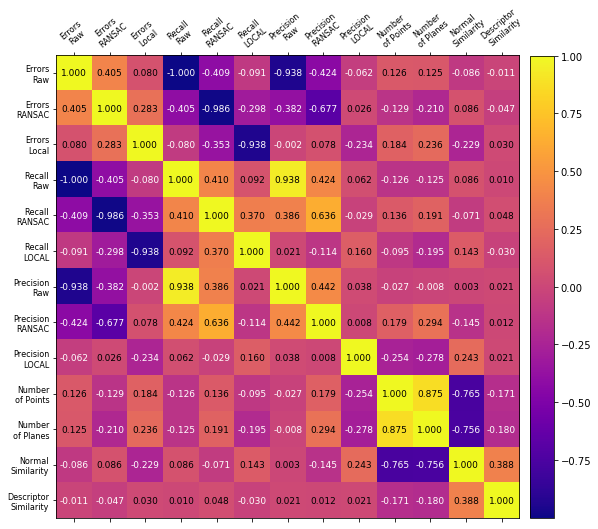

In [102]:
#Up to 4
complete_errors = np.asarray(complete_errors)
ransac_errors = np.asarray(ransac_errors)
local_errors = np.asarray(local_errors)

num_points = combinedProperties[:,0].flatten('C') # (38,)
num_planes = np.mean(generalized_planes, axis = 1) # (38,)
normal_sim = combinedProperties[:,2].flatten('C') # (38,)

errors_stack = np.stack((np.sum(complete_errors[:,:,:],axis = 0).flatten(),#[:,:4,:]
                        np.sum(ransac_errors[:,:,:],axis = 0).flatten(),#[:,:4,:]
                        np.sum(local_errors[:,:,:],axis = 0).flatten(),#[:,:4,:]
                        complete_fp_properties[:,0,:].flatten(), # recall
                        ransac_fp_properties[:,0,:].flatten(), # recall
                        local_fp_properties[:,0,:].flatten(), # recall
                        complete_fp_properties[:,1,:].flatten(), #precision
                        ransac_fp_properties[:,1,:].flatten(), #precision
                        local_fp_properties[:,1,:].flatten(), #precision
                        np.tile(num_points, 8), #combinedProperties[:,0].flatten('C')/np.sum(combinedProperties[:,0]),
                        np.tile(num_planes, 8), #np.mean(generalized_planes, axis = 1),
                        np.tile(normal_sim, 8), #combinedProperties[:,2].flatten('C'),
                        np.tile(descriptor_similarity,8)
                                   ),axis =0)

errors_stack = np.nan_to_num(errors_stack)
err_corrcoef = np.corrcoef(errors_stack)
errors_stack.shape

# ALL
fig, ax=plt.subplots(figsize=(10, 10))

cax = ax.matshow(err_corrcoef, cmap=plt.get_cmap('plasma'))
ax.set_xticks(np.arange(0,13))
ax.set_xticklabels(
    ['Errors\nRaw','Errors\nRANSAC','Errors\nLocal',
    'Recall\nRaw', 'Recall\nRANSAC', 'Recall\nLOCAL', 
    'Precision\nRaw','Precision\nRANSAC','Precision\nLOCAL',
    'Number\nof Points','Number\nof Planes','Normal\nSimilarity','Descriptor\nSimilarity'
    ],
    #fontsize = 12,
    #rotation=40
          )
ax.tick_params(axis="x", labelsize=8, rotation = 40)

ax.set_yticks(np.arange(0,13))
ax.set_yticklabels(
           ['Errors\nRaw','Errors\nRANSAC','Errors\nLocal',
            'Recall\nRaw', 'Recall\nRANSAC', 'Recall\nLOCAL', 
            'Precision\nRaw','Precision\nRANSAC','Precision\nLOCAL',
            'Number\nof Points','Number\nof Planes','Normal\nSimilarity','Descriptor\nSimilarity'
           ]
          )
ax.tick_params(axis="y", labelsize=8)

fig.colorbar(cax, orientation="vertical", pad = 0.02, shrink = 0.85)

for (i, j), z in np.ndenumerate(err_corrcoef):
    if z < 0:
        ax.text(i, j, '{:.3f}'.format(z), ha='center', va='center', color = 'white',
                 fontsize = 9)
    else:
        ax.text(i, j, '{:.3f}'.format(z), ha='center', va='center', fontsize = 9)
        
plt.savefig('plots/space-analysis-corrcoef-more-rotations-all-just-errors.pdf',
            format='pdf', dpi=1000,bbox_inches = 'tight')

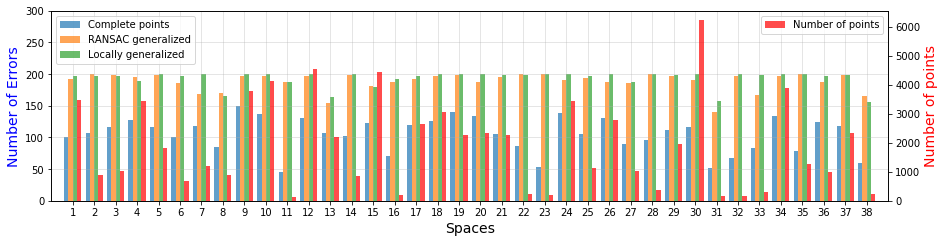

In [103]:
fig=plt.figure(figsize=(15, 3.5))

complete_errors = np.asarray(complete_errors)
ransac_errors = np.asarray(ransac_errors)
local_errors = np.asarray(local_errors)

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        

ax1 = fig.subplots()
width = 0.4

ax1.set_xticks(np.arange(1, 39,1))
ax1.set_xlabel('Spaces',fontsize = 14)
ax1.grid(alpha = 0.4)
ax1.set_ylim(0,300)

ax1.set_xlim(0,39)

ax1.set_ylabel('Number of Errors', color = 'blue',fontsize = 14)

# COMPLETE
#print(error_per_object.shape)
p1 = ax1.bar(
    np.arange(1, complete_errors.shape[-1]+1,1)-1.5*0.5*width,
    np.sum(complete_errors[:,:4,:],axis = (0,1)),#/np.sum(error_per_object),
    width = 0.5*width, alpha = 0.7,
    label = "Complete points");

# GENERALIZED
#print(error_per_object.shape)
p2 = ax1.bar(
    np.arange(1, ransac_errors.shape[-1]+1,1)-0.5*0.5*width,
    np.sum(ransac_errors[:,:4,:],axis = (0,1)),#/np.sum(g_error_per_object),
    width = 0.5*width, alpha = 0.7,
    label = "RANSAC generalized");

# LOCALIZED
#print(error_per_object.shape)
p3 = ax1.bar(
    np.arange(1, local_errors.shape[-1]+1,1)+0.5*0.5*width,
    np.sum(local_errors[:,:4,:],axis = (0,1)),#/np.sum(l_error_per_object),
    width = 0.5*width, alpha = 0.7,
    label = "Locally generalized");

ax2 = ax1.twinx()
ax2.set_ylabel('Number of points', color = 'red',fontsize = 14)

ax2.bar(
    np.arange(1, local_errors.shape[-1]+1,1)+1.5*0.5*width,
    combinedProperties[:,0],
    color = 'red', width = 0.5*width, alpha = 0.7,
    label = "Number of points");

lines = [p1, p2, p3]#, p5,p6]

ax1.legend(lines, [l.get_label() for l in lines], loc='upper left')
ax2.legend(loc='upper right')

#print("Correlation of errors and point population:",error_corrcoef[1])
#print("Correlation of errors and normal similarity:",error_corrcoef[2])

plt.savefig('plots/space-analysis-more-rotations.pdf', format='pdf', dpi=1000, bbox_inches = 'tight')

In [ ]:
fig=plt.figure(figsize=(15, 8))

complete_errors = np.asarray(complete_errors)
ransac_errors = np.asarray(ransac_errors)
local_errors = np.asarray(local_errors)

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        

ax3 = fig.add_subplot(211)
ax3.grid(alpha = 0.4)
ax3.set_xticks(np.arange(1, 39,1))
ax3.set_xlabel('Spaces',fontsize = 14)
ax3.set_xlim(0,39)

width = 0.4

ax3.set_ylim(0,1.0)
ax3.set_ylabel('Similarity', fontsize = 14)

p7, = ax3.plot(
    np.arange(1, local_errors.shape[-1]+1,1),
    combinedProperties[:,2],
    '-.s',color='magenta', linewidth = 2, alpha = 0.6,
    label = "Mean normal similarity");

p8, = ax3.plot(
    np.arange(1, local_errors.shape[-1]+1,1),
    descriptor_similarity,
    '-.*',color='chocolate', linewidth = 2, alpha = 0.6,
    label = "Mean descriptor similarity");

p9, = ax3.plot(
    np.arange(1, local_errors.shape[-1]+1,1),
    complete_properties[-2], #recall
    #'-.*',color='chocolate', 
    linewidth = 2, alpha = 0.6,
    label = "Recall (Complete)");

p10, = ax3.plot(
    np.arange(1, local_errors.shape[-1]+1,1),
    complete_properties[-1], #recall
    #'-.*',color='chocolate', 
    linewidth = 2, alpha = 0.6,
    label = "Precision (Complete)");

p11, = ax3.plot(
    np.arange(1, local_errors.shape[-1]+1,1),
    ransac_properties[-2], #recall
    #'-.*',color='chocolate', 
    linewidth = 2, alpha = 0.6,
    label = "Recall (RANSAC)");

p12, = ax3.plot(
    np.arange(1, local_errors.shape[-1]+1,1),
    ransac_properties[-1], #recall
    #'-.*',color='chocolate', 
    linewidth = 2, alpha = 0.6,
    label = "Precision (RANSAC)");

p13, = ax3.plot(
    np.arange(1, local_errors.shape[-1]+1,1),
    local_properties[-2], #recall
    #'-.*',color='chocolate', 
    linewidth = 2, alpha = 0.6,
    label = "Recall (LOCAL)");

p14, = ax3.plot(
    np.arange(1, local_errors.shape[-1]+1,1),
    local_properties[-1], #recall
    #'-.*',color='chocolate', 
    linewidth = 2, alpha = 0.6,
    label = "Precision (LOCAL)");

lines = [p1, p2, p3]#, p5,p6]

lines = [p7, p8, p9, p10, p11, p12, p13, p14]

ax3.legend(lines, [l.get_label() for l in lines], loc='lower right')

#np.corrcoef(np.stack)
#combinedProperties[:,0].flatten('C').shape
#error_per_object.shape
#print(error_corrcoef)
#print("Correlation of errors and point population:",error_corrcoef[1])
#print("Correlation of errors and normal similarity:",error_corrcoef[2])

#plt.savefig('plots/space-analysis.pdf', format='pdf', dpi=1000, bbox_inches = 'tight')

ax2 = fig.add_subplot(212)
ax2.grid(alpha=0.4)
ax2.scatter(combinedProperties[:,2],descriptor_similarity)
ax2.set_ylabel("Descriptor Similarity")
ax2.set_xlabel("Normal Similarity");

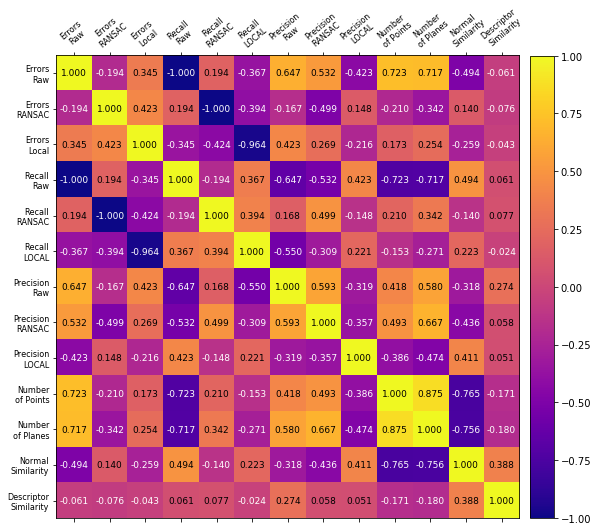

In [106]:
# ALL
fig, ax=plt.subplots(figsize=(10, 10))

cax = ax.matshow(error_corrcoef, cmap=plt.get_cmap('plasma'))
ax.set_xticks(np.arange(0,13))
ax.set_xticklabels(
           ['Errors\nRaw','Errors\nRANSAC','Errors\nLocal',
            'Recall\nRaw', 'Recall\nRANSAC', 'Recall\nLOCAL', 
            'Precision\nRaw','Precision\nRANSAC','Precision\nLOCAL',
            'Number\nof Points','Number\nof Planes','Normal\nSimilarity','Descriptor\nSimilarity']
           #fontsize = 8,
           #   rotation=40
          )
ax.tick_params(axis="x", labelsize=8, rotation = 40)

ax.set_yticks(np.arange(0,13))
ax.set_yticklabels(
           ['Errors\nRaw','Errors\nRANSAC','Errors\nLocal',
            'Recall\nRaw', 'Recall\nRANSAC', 'Recall\nLOCAL', 
            'Precision\nRaw','Precision\nRANSAC','Precision\nLOCAL',
            'Number\nof Points','Number\nof Planes','Normal\nSimilarity','Descriptor\nSimilarity']
          )
ax.tick_params(axis="y", labelsize=8)

fig.colorbar(cax, orientation="vertical", pad = 0.02, shrink = 0.85)

for (i, j), z in np.ndenumerate(error_corrcoef):
    if z < 0:
        ax.text(i, j, '{:.3f}'.format(z), ha='center', va='center', color = 'white',
                 fontsize = 9)
    else:
        ax.text(i, j, '{:.3f}'.format(z), ha='center', va='center', fontsize = 9)
        
plt.savefig('plots/space-analysis-corrcoef-more-rotations-all.pdf',
            format='pdf', dpi=1000,bbox_inches = 'tight')

In [105]:
print(
    "Top 10 FPs complete\n",
    np.argsort(complete_properties[0]-complete_properties[1])[-10:]+1,
    #np.sort(np.argsort(complete_properties[0]-complete_properties[1])[-10:]+1),
)
print(
    "Top 10 FPs RANSAC\n",
    np.argsort(ransac_properties[0]-ransac_properties[1])[-10:]+1,
    #np.sort(np.argsort(ransac_properties[0]-ransac_properties[1])[-10:]+1),
)
print(
    "Top 10 FPs Local\n",
    np.argsort(ransac_properties[0]-ransac_properties[1])[-10:]+1,
    #np.sort(np.argsort(local_properties[0]-local_properties[1])[-10:]+1),
)

Top 10 FPs complete
 [16 25 33 27  8 17 38 11 31  1]
Top 10 FPs RANSAC
 [ 2 33 38 16 36 31 27 15  8 13]
Top 10 FPs Local
 [ 2 33 38 16 36 31 27 15  8 13]


In [73]:
print(
    "Top 10 FPs complete\n",
    #np.argsort(complete_properties[0]-complete_properties[1])[-10:]+1,
    np.sort(np.argsort(complete_properties[0]-complete_properties[1])[-10:]+1),
)
print(
    "Top 10 FPs RANSAC\n",
    #np.argsort(ransac_properties[0]-ransac_properties[1])[-10:]+1,
    np.sort(np.argsort(ransac_properties[0]-ransac_properties[1])[-10:]+1),
)
print(
    "Top 10 FPs Local\n",
    #np.argsort(ransac_properties[0]-ransac_properties[1])[-10:]+1,
    np.sort(np.argsort(local_properties[0]-local_properties[1])[-10:]+1),
)

Top 10 FPs complete
 [ 1  8 11 16 17 25 27 31 33 38]
Top 10 FPs RANSAC
 [ 2  8 13 15 16 27 31 33 36 38]
Top 10 FPs Local
 [ 1  2  4  8 13 15 16 27 31 38]


In [74]:
complete_properties[0]-complete_properties[1]

array([456., 102.,  73.,   7.,   9.,  69.,   5., 258.,  14.,  16., 379.,
        32.,  66.,  37.,  89., 119., 258.,  27.,  40.,  21., 109.,  46.,
       117.,  14., 147.,   3., 249.,  55.,   6.,   4., 445.,  67., 149.,
         1.,  92.,  49.,  69., 310.])

In [75]:
print("Top 10 precision complete\n",
      np.sort(np.argsort(properties_errors_stack[6])[-10:]+1),"\n",
      #properties_errors_stack[6,np.argsort(properties_errors_stack[6])[-10:]]
     )
print("Top 10 precision RANSAC\n",
      np.sort(np.argsort(properties_errors_stack[7])[-10:]+1),"\n",
      #properties_errors_stack[7,np.argsort(properties_errors_stack[7])[-10:]]
     )
print("Top 10 precision Local\n",
      np.sort(np.argsort(properties_errors_stack[8])[-10:]+1),"\n",
      #properties_errors_stack[8,np.argsort(properties_errors_stack[8])[-10:]]
     )

NameError: name 'properties_errors_stack' is not defined

In [76]:
print("Top 10 recall complete\n",
      np.sort(np.argsort(properties_errors_stack[3])[-10:]+1),"\n",
      #properties_errors_stack[3, np.argsort(properties_errors_stack[3])[-10:]]
     )
print("Top 10 recall RANSAC\n",
      np.sort(np.argsort(properties_errors_stack[4])[-10:]+1),"\n",
      #properties_errors_stack[4, np.argsort(properties_errors_stack[4])[-10:]]
     )
print("Top 10 recall Local\n",
      np.sort(np.argsort(properties_errors_stack[5])[-10:]+1),"\n",
      #properties_errors_stack[5, np.argsort(properties_errors_stack[5])[-10:]]
     )

NameError: name 'properties_errors_stack' is not defined

In [77]:
print("Sorted spaces based on errors from least to most errors")
print("Complete\n",np.sort(np.argsort(properties_errors_stack[0])[:10]+1),"\n",
      " Errors:",np.argsort(properties_errors_stack[0])[:10],"\n"
      " Recall:",properties_errors_stack[3,np.sort(np.argsort(properties_errors_stack[0])[:10])],"\n",
      " Precision:",properties_errors_stack[6,np.sort(np.argsort(properties_errors_stack[0])[:10])],"\n",
      " Normal Similarity:",properties_errors_stack[12,np.sort(np.argsort(properties_errors_stack[0])[:10])])      
print("RANSAC\n",np.sort(np.argsort(properties_errors_stack[1])[:10]+1),"\n",
      " Recall:",properties_errors_stack[4,np.sort(np.argsort(properties_errors_stack[1])[:10])],"\n",
      " Precision:",properties_errors_stack[7,np.sort(np.argsort(properties_errors_stack[1])[:10])],"\n",
      " Normal Similarity:",properties_errors_stack[12,np.sort(np.argsort(properties_errors_stack[1])[:10])])      
print("Local\n",np.sort(np.argsort(properties_errors_stack[2])[:10]+1),"\n",
      " Recall:",properties_errors_stack[5,np.sort(np.argsort(properties_errors_stack[2])[:10])],"\n",
      " Precision:",properties_errors_stack[8,np.sort(np.argsort(properties_errors_stack[2])[:10])],"\n",
      " Normal Similarity:",properties_errors_stack[12,np.sort(np.argsort(properties_errors_stack[2])[:10])])

Sorted spaces based on errors from least to most errors


NameError: name 'properties_errors_stack' is not defined

In [93]:
print("Sorted spaces based on errors from least to most errors")
print("Complete\n",np.sort(np.argsort(properties_errors_stack[0])[-10:]+1),"\n",
      " Errors:",np.argsort(properties_errors_stack[0])[-10:],"\n"
      " Recall:",properties_errors_stack[3,np.sort(np.argsort(properties_errors_stack[0])[:10])],"\n",
      " Precision:",properties_errors_stack[6,np.sort(np.argsort(properties_errors_stack[0])[:10])],"\n",
      " Normal Similarity:",properties_errors_stack[12,np.sort(np.argsort(properties_errors_stack[0])[:10])])      
print("RANSAC\n",np.sort(np.argsort(properties_errors_stack[1])[:10]+1),"\n",
      " Recall:",properties_errors_stack[4,np.sort(np.argsort(properties_errors_stack[1])[:10])],"\n",
      " Precision:",properties_errors_stack[7,np.sort(np.argsort(properties_errors_stack[1])[:10])],"\n",
      " Normal Similarity:",properties_errors_stack[12,np.sort(np.argsort(properties_errors_stack[1])[:10])])      
print("Local\n",np.sort(np.argsort(properties_errors_stack[2])[:10]+1),"\n",
      " Recall:",properties_errors_stack[5,np.sort(np.argsort(properties_errors_stack[2])[:10])],"\n",
      " Precision:",properties_errors_stack[8,np.sort(np.argsort(properties_errors_stack[2])[:10])],"\n",
      " Normal Similarity:",properties_errors_stack[12,np.sort(np.argsort(properties_errors_stack[2])[:10])])

Sorted spaces based on errors from least to most errors
Complete
 [ 8  9 10 12 18 19 20 24 26 34] 
  Errors: [17  7 11 25 19 33  8 23 18  9] 
 Recall: [0.7475 0.8875 0.825  0.7825 0.865  0.8725 0.8325 0.7925 0.805  0.8525] 
  Precision: [0.39602649 0.48365123 0.73496659 0.8718663  0.74730022 0.4395466
 0.8325     0.68025751 0.77777778 0.52380952] 
  Normal Similarity: [0.48431396 0.57836914 0.734375   0.55749512 0.4855957  0.61791992
 0.76293945 0.58239746 0.54711914 0.4432373 ]
RANSAC
 [ 4  5  7 13 18 24 26 30 31 33] 
  Recall: [0.31   0.28   0.45   0.565  0.3325 0.355  0.325  0.2925 0.4225 0.2975] 
  Precision: [0.28054299 0.95726496 0.89552239 0.09247136 0.80120482 0.47333333
 0.64039409 0.73584906 0.20386007 0.22537879] 
  Normal Similarity: [0.60107422 0.63916016 0.6270752  0.57128906 0.56152344 0.54156494
 0.59875488 0.52600098 0.61791992 0.58239746]
Local
 [ 2  4  8 11 13 15 16 27 31 38] 
  Recall: [0.035  0.0425 0.25   0.04   0.2025 0.1175 0.07   0.0325 0.2275 0.08  ] 
  Precis

In [59]:
print("Sorted spaces based on errors using true spaces (least to most errors)")
print(np.argsort(properties_errors_stack[0])+1)

print("\nSorted spaces based on errors using RANSAC spaces (least to most errors)")
print(np.argsort(properties_errors_stack[1])+1)

print("\nSorted spaces based on errors using locally-generalized spaces (least to most errors)")
print(np.argsort(properties_errors_stack[2])+1)

Sorted spaces based on errors using true spaces (least to most errors)
[11 31 23 38 32 16 35 33  8 22 27 28  1  6 14 21 25 13  2 29  5  3 30  7
 37 17 15 36 18  4 26 12 20 34 10 24 19  9]

Sorted spaces based on errors using RANSAC spaces (least to most errors)
[31 13 38 33  7  8 15 27  6 36 26 11 20 16 24 30  1 17 25 21  4 34 10  9
 18 32 12 29  3 19 14 37  5 23 22 35  2 28]

Sorted spaces based on errors using locally-generalized spaces (least to most errors)
[38 31 13  8 15 27 11  4 16 36 17  1  6  3 25  2 33 37 22 21 29 35 34 32
 30 28 10 26 12 24 23 20 18  7  9 14  5 19]


In [156]:
np.arange(0.25,2.1,0.25),np.mean(local_fp_properties[:,0,:],axis = 1),np.mean(local_fp_properties[:,1,:],axis = 1)

TypeError: list indices must be integers or slices, not tuple

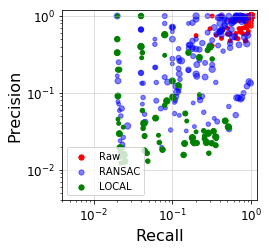

In [162]:
fig=plt.figure(figsize=(3.5,3.5))

plt.grid(alpha = 0.5)

plt.xlim(0.004,1.2)
plt.ylim(0.004,1.2)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Recall", fontsize = 16)
plt.ylabel("Precision", fontsize = 16)

plt.scatter(complete_fp_properties[2:,0,:],
            complete_fp_properties[2:,1,:],
            s = 20*np.reshape(np.repeat(np.arange(0.75,2.1,0.25).T,38),(6,38)), 
            color = 'red', label = 'Raw')
plt.scatter(ransac_fp_properties[2:,0,:],
            ransac_fp_properties[2:,1,:],
            s = 20*np.reshape(np.repeat(np.arange(0.75,2.1,0.25).T,38),(6,38)),
            alpha = 0.5,
            color = 'blue', label = 'RANSAC')
plt.scatter(local_fp_properties[2:,0,:],
            local_fp_properties[2:,1,:],
            s = 20*np.reshape(np.repeat(np.arange(0.75,2.1,0.25).T,38),(6,38)), 
            color = 'green', label = 'LOCAL')

plt.xscale('log')
plt.yscale('log')

plt.legend(ncol = 1,loc = 'lower left', fontsize = 10)

plt.savefig('plots/precision-vs-recall.pdf', format='pdf', dpi=1000,bbox_inches = 'tight')

In [96]:
complete_fp_properties[:,0,:].flatten()

array([0.19047619, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.0625    , 0.        , 0.        ,
       0.46      , 0.        , 0.        , 0.        , 0.04081633,
       0.04081633, 0.12820513, 0.        , 0.        , 0.        ,
       0.        , 0.02040816, 0.1875    , 0.        , 0.02325581,
       0.        , 0.16666667, 0.        , 0.        , 0.        ,
       0.1875    , 0.0212766 , 0.        , 0.        , 0.08      ,
       0.        , 0.        , 0.4       , 0.22      , 0.10416667,
       0.18      , 0.        , 0.02      , 0.28      , 0.04      ,
       0.4       , 0.02040816, 0.        , 0.64      , 0.02      ,
       0.1       , 0.14      , 0.18      , 0.64      , 0.06122449,
       0.02040816, 0.06      , 0.        , 0.24      , 0.36      ,
       0.74      , 0.        , 0.14      , 0.        , 0.38      ,
       0.22      , 0.02      , 0.02      , 0.8       , 0.64      ,
       0.54      , 0.        , 0.48      , 0.0625    , 0.06   

In [91]:
print("Complete",np.corrcoef(complete_fp_properties[:,0,:].flatten(),
            complete_fp_properties[:,1,:].flatten()))
print("RANSAC",np.corrcoef(ransac_fp_properties[:,0,:].flatten(),
            ransac_fp_properties[:,1,:].flatten()))
print("LOCAL",np.corrcoef(local_fp_properties[:,0,:].flatten(),
            local_fp_properties[:,1,:].flatten()))

Complete [[1.         0.93812286]
 [0.93812286 1.        ]]
RANSAC [[1.         0.63636832]
 [0.63636832 1.        ]]
LOCAL [[1.         0.16030905]
 [0.16030905 1.        ]]


In [51]:
complete_fp_properties[:,0,:].shape

(8, 38)

In [254]:
complete_fp_properties[:,0,:].shape
np.reshape(np.repeat(np.arange(0.25,2.1,0.25).T,38),(8,38))

array([[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
        0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
        0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
        0.25, 0.25, 0.25, 0.25, 0.25],
       [0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
        0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
        0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
        0.5 , 0.5 , 0.5 , 0.5 , 0.5 ],
       [0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
        0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
        0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
        0.75, 0.75, 0.75, 0.75, 0.75],
       [1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1

In [52]:
complete_fp_properties

array([[[0.19047619, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.0625    , 0.        , 0.        ,
         0.46      , 0.        , 0.        , 0.        , 0.04081633,
         0.04081633, 0.12820513, 0.        , 0.        , 0.        ,
         0.        , 0.02040816, 0.1875    , 0.        , 0.02325581,
         0.        , 0.16666667, 0.        , 0.        , 0.        ,
         0.1875    , 0.0212766 , 0.        , 0.        , 0.08      ,
         0.        , 0.        , 0.4       ],
        [0.02266289, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.0375    , 0.        , 0.        ,
         0.06406685, 0.        , 0.        , 0.        , 0.125     ,
         0.06451613, 0.025     , 0.        , 0.        , 0.        ,
         0.        , 0.33333333, 0.17307692, 0.        , 0.0125    ,
         0.        , 0.05594406, 0.        , 0.        , 0.        ,
         0.03947368, 0.03571429, 0.        , 0.        , 

In [124]:
# ALL, or 1

complete_fp_map = []

ransac_fp_map = []

local_fp_map = []

for rotation in np.arange(5):

    with open('results_more_rotations/extended_{}_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        e_scores = pickle.load(f)
        
    with open('results_more_rotations/{}_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        scores = pickle.load(f)
        
    for r, score in e_scores:
        scores.append([r, score])
        
    # COMPLETE
    fp_errors = getFalsePositiveRate(scores)#[1:4])
    fp_error_map = []
    for radius, fp_error in fp_errors:
        fp_errors_accum = np.sum(fp_error,axis = 0)
        fp_error_map.append(fp_errors_accum)
        
    fp_error_map = np.asarray(fp_error_map)
    
    complete_fp_map.append(np.sum(fp_error_map,axis = 0))
    
    with open('results_more_rotations/extended_{}_g_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        e_scores = pickle.load(f)
        
    with open('results_more_rotations/{}_g_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        scores = pickle.load(f)
        
    for r, score in e_scores:
        scores.append([r, score])
        
    # RANSAC 
    fp_errors = getFalsePositiveRate(scores)#[1:4])
    fp_error_map = []
    for radius, fp_error in fp_errors:
        fp_errors_accum = np.sum(fp_error,axis = 0)
        fp_error_map.append(fp_errors_accum)
        
    fp_error_map = np.asarray(fp_error_map)
    ransac_fp_map.append(np.sum(fp_error_map,axis = 0))
    
    with open('results_more_rotations/extended_{}_l_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        e_scores = pickle.load(f)
        
    with open('results_more_rotations/{}_l_qpr_0.25_3_scores.pickle'.format(rotation), 'rb') as f:
        scores = pickle.load(f)
        
    for r, score in e_scores:
        scores.append([r, score])
        
    # RANSAC 
    fp_errors = getFalsePositiveRate(scores)#[1:4])
    fp_error_map = []
    for radius, fp_error in fp_errors:
        fp_errors_accum = np.sum(fp_error,axis = 0)
        fp_error_map.append(fp_errors_accum)
        
    fp_error_map = np.asarray(fp_error_map)
    local_fp_map.append(np.sum(fp_error_map,axis = 0))
 

/Users/deg032/anaconda3/envs/p35_env/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in true_divide


True Positives [50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50.]
Complete: Recall = 1.0000 (0.0000), Precision = 1.0000 (0.0000)
True Positives [ 0.  5.  5. 44. 33. 32. 40. 28. 21.  5.  0. 29. 47.  0. 21. 10.  6. 47.
  1. 21.  0.  0.  0. 45. 20. 42. 20.  0. 29. 29. 36.  0. 30. 10.  0. 16.
  0.  0.]
RANSAC: Recall = 0.3537 (0.3271), Precision = nan (nan)


/Users/deg032/anaconda3/envs/p35_env/lib/python3.5/site-packages/ipykernel/__main__.py:80: RuntimeWarning: invalid value encountered in true_divide


True Positives [10.  1.  2.  1.  0.  0.  0. 19.  0.  0.  0.  0. 10.  0.  7.  4.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 15.  2.  4.  0.  0.  0.
  0.  0.]
LOCAL: Recall = 0.0395 (0.0876), Precision = 0.0430 (0.1240)


/Users/deg032/anaconda3/envs/p35_env/lib/python3.5/site-packages/ipykernel/__main__.py:128: RuntimeWarning: invalid value encountered in true_divide


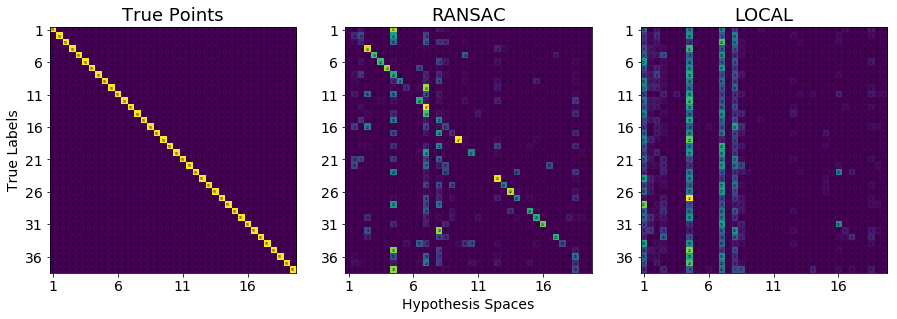

In [79]:
fig=plt.figure(figsize=(15, 5))

fp_map = np.asarray(complete_fp_map)

ax1 = fig.add_subplot(131)

ax1.imshow(np.sum(fp_map,axis = 0))#,vmin=0, vmax=160)
ax1.set_title('True Points', fontsize = 18)
ax1.set_xticklabels(np.arange(-4,39,5))
ax1.set_yticklabels(np.arange(-4,39,5))
ax1.tick_params(axis="x", labelsize=14)
ax1.tick_params(axis="y", labelsize=14)
ax2.set_xlabel("Hypothesis Spaces", fontsize = 14)
ax1.set_ylabel("True Labels",fontsize = 14)

#print(np.sum(fp_error_map,axis = 0))
#print(np.sum(fp_error_map, axis = (0,1))
positives = np.sum(fp_map, axis = (0,1))
true_positives = np.diagonal(np.sum(fp_map,axis = 0))
false_positives = positives - true_positives
false_negatives = np.sum(fp_map, axis = (0,2)) - np.amax(np.sum(fp_map,axis = 0),axis = 0)
true_negatives = np.sum(fp_map) - false_positives - false_negatives - true_positives
#print(true_negatives)

accuracy = (true_positives + true_negatives)/(true_positives + false_positives + true_negatives + false_negatives)
#print("Positives",positives)
print("True Positives",true_positives)
#print("Accuracy = {} {} ({})".format(accuracy,np.mean(accuracy),np.std(accuracy)))
#print("False Positives",false_positives)
#print("Spaces labelled most fp  \n",np.argsort(-positives + true_positives)+1)
recall = true_positives/(true_positives + false_negatives)
precision = true_positives/(true_positives + false_positives)
print("Complete: Recall = {:.4f} ({:.4f}), Precision = {:.4f} ({:.4f})".format(np.mean(recall),np.std(recall),np.mean(precision),np.std(precision)))
#print(recall)
#print(precision)

complete_properties = [
    positives,
    true_positives,
    false_negatives,
    recall,
    precision
]

#print("Accuracy =",(true_positives + )/())

for (i, j), z in np.ndenumerate(np.sum(fp_map,axis = 0)):
    ax1.text(j, i, '{}'.format(int(z)), ha='center', va='center', fontsize = 3)
  

fp_map = np.asarray(ransac_fp_map)

ax2 = fig.add_subplot(132)
#ax2.grid(alpha=0.2)

ax2.imshow(np.sum(fp_map,axis = 0))#,vmin=0, vmax=160)
ax2.set_title('RANSAC', fontsize = 18)
ax2.set_xticklabels(np.arange(-4,39,5))
ax2.set_yticklabels(np.arange(-4,39,5))
ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14)
ax2.set_xlabel("Hypothesis Spaces", fontsize = 14)

#print(np.sum(fp_error_map,axis = 0))
#print(np.sum(fp_error_map, axis = (0,1))
positives = np.sum(fp_map, axis = (0,1))
true_positives = np.diagonal(np.sum(fp_map,axis = 0))
false_positives = positives - true_positives
false_negatives = np.sum(fp_map, axis = (0,2)) - np.amax(np.sum(fp_map,axis = 0),axis = 0)
true_negatives = np.sum(fp_map) - false_positives - false_negatives - true_positives
#print(true_negatives)

accuracy = (true_positives + true_negatives)/(true_positives + false_positives + true_negatives + false_negatives)
#print("Positives",positives)
print("True Positives",true_positives)
#print("Accuracy = {} {} ({})".format(accuracy,np.mean(accuracy),np.std(accuracy)))
#print("False Positives",false_positives)
#print("Spaces labelled most fp  \n",np.argsort(-positives + true_positives)+1)
recall = true_positives/np.sum(fp_map, axis = (0,2))
precision = true_positives/positives
print("RANSAC: Recall = {:.4f} ({:.4f}), Precision = {:.4f} ({:.4f})".format(np.mean(recall),np.std(recall),np.mean(precision),np.std(precision)))
#print(recall)
#print(precision)
#print("Accuracy =",(true_positives + )/())

ransac_properties = [
    positives,
    true_positives,
    false_negatives,
    recall,
    precision
]

for (i, j), z in np.ndenumerate(np.sum(fp_map,axis = 0)):
    ax2.text(j, i, '{}'.format(int(z)), ha='center', va='center', fontsize = 3)
    
fp_map = np.asarray(local_fp_map)

ax3 = fig.add_subplot(133)
#ax3.grid(alpha=0.2)

cax = ax3.imshow(np.sum(fp_map,axis = 0))#,vmin=0, vmax=160)

ax3.set_title('LOCAL', fontsize = 18)
ax3.set_xticklabels(np.arange(-4,39,5))
ax3.set_yticklabels(np.arange(-4,39,5))
ax3.tick_params(axis="x", labelsize=14)
ax3.tick_params(axis="y", labelsize=14)
ax2.set_xlabel("Hypothesis Spaces", fontsize = 14)

#print(np.sum(fp_error_map,axis = 0))
#print(np.sum(fp_error_map, axis = (0,1))
positives = np.sum(fp_map, axis = (0,1))
true_positives = np.diagonal(np.sum(fp_map,axis = 0))
false_positives = positives - true_positives
false_negatives = np.sum(fp_map, axis = (0,2)) - np.amax(np.sum(fp_map,axis = 0),axis = 0)
true_negatives = np.sum(fp_map) - false_positives - false_negatives - true_positives
#print(true_negatives)

accuracy = (true_positives + true_negatives)/(true_positives + false_positives + true_negatives + false_negatives)
#print("Positives",positives)
print("True Positives",true_positives)
#print("Accuracy = {} {} ({})".format(accuracy,np.mean(accuracy),np.std(accuracy)))
#print("False Positives",false_positives)
#print("Spaces labelled most fp  \n",np.argsort(-positives + true_positives)+1)
recall = true_positives/np.sum(fp_map, axis = (0,2))
#print("Recall = {} ({})".format(np.mean(recall),np.std(recall)))
precision = true_positives/positives
print("LOCAL: Recall = {:.4f} ({:.4f}), Precision = {:.4f} ({:.4f})".format(np.mean(recall),np.std(recall),np.mean(np.nan_to_num(precision)),np.std(np.nan_to_num(precision))))
#print(recall)
#print(precision)

#print("Accuracy =",(true_positives + )/())

local_properties = [
    positives,
    true_positives,
    false_negatives,
    recall,
    precision
]

for (i, j), z in np.ndenumerate(np.sum(fp_map,axis = 0)):
    ax3.text(j, i, '{}'.format(int(z)), ha='center', va='center', fontsize = 3)
    
plt.savefig('plots/classification-maps-text-selected.pdf', format='pdf', dpi=1000,bbox_inches = 'tight')

In [80]:
#ALL
complete_errors = np.asarray(complete_errors)
ransac_errors = np.asarray(ransac_errors)
local_errors = np.asarray(local_errors)

properties_errors_stack = np.stack((np.sum(complete_errors,axis = (0,1)),#[:,:4,:]
                                    np.sum(ransac_errors,axis = (0,1)),#[:,:4,:]
                                    np.sum(local_errors,axis = (0,1)),#[:,:4,:]
                                    complete_properties[-2], # recall
                                    ransac_properties[-2], # recall
                                    local_properties[-2], # recall
                                    complete_properties[-1], #precision
                                    ransac_properties[-1], #precision
                                    local_properties[-1], #precision
                                    combinedProperties[:,0].flatten('C')/np.sum(combinedProperties[:,0]),
                                    np.mean(generalized_planes, axis = 1),
                                    combinedProperties[:,2].flatten('C'),
                                    descriptor_similarity
                                   ),axis =0)

error_corrcoef = np.corrcoef(np.nan_to_num(properties_errors_stack))
properties_errors_stack.shape

NameError: name 'complete_errors' is not defined

In [ ]:
# ALL
fig, ax=plt.subplots(figsize=(10, 10))

cax = ax.matshow(error_corrcoef, cmap=plt.get_cmap('plasma'))
ax.set_xticks(np.arange(0,13))
ax.set_xticklabels(
           ['Errors\nComplete','Errors\nRANSAC','Errors\nLocal',
            'Recall\nComplete', 'Recall\nRANSAC', 'Recall\nLOCAL', 
            'Precision\nComplete','Precision\nRANSAC','Precision\nLOCAL',
            'Number\nof Points','Number\nof Planes','Normal\nSimilarity','Descriptor\nSimilarity']
           #fontsize = 8,
           #   rotation=40
          )
ax.tick_params(axis="x", labelsize=8, rotation = 40)

ax.set_yticks(np.arange(0,13))
ax.set_yticklabels(
           ['Errors\nComplete','Errors\nRANSAC','Errors\nLocal',
            'Recall\nComplete', 'Recall\nRANSAC', 'Recall\nLOCAL', 
            'Precision\nComplete','Precision\nRANSAC','Precision\nLOCAL',
            'Number\nof Points','Number\nof Planes','Normal\nSimilarity','Descriptor\nSimilarity']
          )
ax.tick_params(axis="y", labelsize=8)

fig.colorbar(cax)

for (i, j), z in np.ndenumerate(error_corrcoef):
    if z < 0:
        ax.text(i, j, '{:.3f}'.format(z), ha='center', va='center', color = 'white',
                 fontsize = 9)
    else:
        ax.text(i, j, '{:.3f}'.format(z), ha='center', va='center', fontsize = 9)
        
plt.savefig('plots/space-analysis-corrcoef-more-rotations-all.pdf',
            format='pdf', dpi=1000,bbox_inches = 'tight')

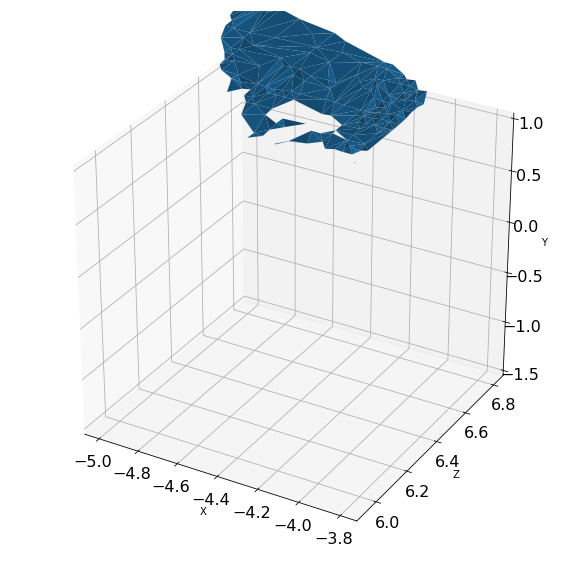

object 31 : descriptor similarity = 0.617919921875 normal_similarity = 0.964233987341527


In [66]:
space_of_interest = 31

fig=plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection='3d')

pointCloudObject = centeredPointCollection[space_of_interest-1]
object_name = pointCloudObject[0]
    
pointCloud = np.asarray(pointCloudObject[1])
triangles = np.asarray(pointCloudObject[2])#-vertices_length

X = pointCloud[:,0]
Y = pointCloud[:,1]
Z = pointCloud[:,2]
#vertices_length += len(X)
#im = ax.scatter(X,Y,Z, c = object_name*3*np.ones(pointCloud.shape[0]))
color = (object_name%256,object_name%127,object_name%63)
#print(object_name,len(X),triangles.min(),triangles.max())
try:
    ax.plot_trisurf(X, -Z, Y, triangles=triangles)#, cmap=plt.cm.Spectral)
except:
    pass
        

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_zlim(-1.5,1)
#ax.set_title('True surfaces')

#ax.set_xticks(np.arange(-10,6,2))
#ax.set_yticks(np.arange(-6,7,2))
#ax.set_zticks(np.arange(-1,2,1.5))
#ax.set_title('Showing different regions sliced by X-Z')

# Add a colorbar
#fig.colorbar(im, ax=ax)

# set the color limits - not necessary here, but good to know how.
#im.set_clim(0.0, 1.0)
#ax._axis3don = False
ax.tick_params(axis='both', labelsize = 16)

plt.show()
print("object",object_name,": descriptor similarity =",descriptor_similarity[space_of_interest-1],
      "normal_similarity =", combinedProperties[space_of_interest-1,2]
)

#plt.savefig('plots/complete-point-cloud.pdf', format='pdf', dpi=1000)

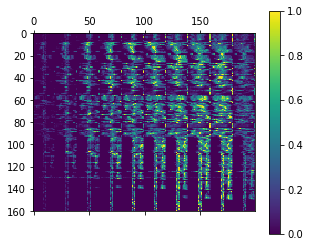

In [150]:
plt.matshow(np.asarray(qi_descriptors[3][1],dtype = np.float32))
plt.colorbar()

In [20]:
# Using minima-extracted, and localized descriptors
with open('descriptors/local_minima_qs_descriptors_r1_20.pickle', 'rb') as f:
    qs_descriptor_set = pickle.load(f)

with open('descriptors/local_minima_rs_descriptors_r1_20.pickle', 'rb') as f:
    rs_descriptor_set = pickle.load(f)

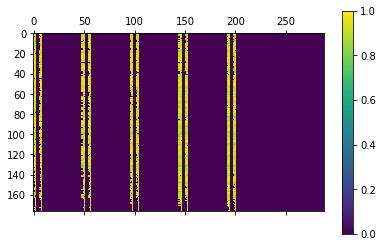

In [146]:
qs_descriptor_set[-1][1][3][1].shape
plt.matshow(np.asarray(qs_descriptor_set[-1][1][3][1],dtype = np.float32))
plt.colorbar()

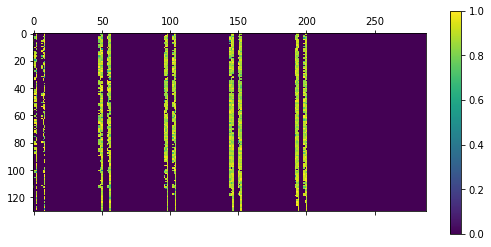

In [149]:
qs_descriptor_set[-1][1][3][1].shape
plt.matshow(np.asarray(qs_descriptor_set[5][1][3][1],dtype = np.float32))
plt.colorbar()

# RANSAC Plane Fitting
Trying RANSAC plane fitting to estimate planes from the sense point cloud (from Hololens).

# Pseudocode

    Input:
    X = {x_1 , x_2 , ..., x_n}, a s et of 3D points
    P the number of planes to find
    T the point-plane distance threshold
    R the number of RANSAC trials
    
    for p = 1 to P:
        bestPlane = {0,0}
        bestPoints = {}
        for r = 1 to R:
            S = {s_1 , s_2 , s_3} = 3 points at random f rom X
            thisPlane = {s_1 , crossProduct(s_3 -s_1 , s_2 -s_1)}
            thisPoints = {}
            for x_i in X:
                if (distance(thisPlane , x_i) < T):
                    thisPoints = thisPoints + x_i
            if |thisPoints| > |bestPoints |:
                bestPlane = thisPlane
                bestPoints = thisPoints
                
        output bestPlane
        X = X - bestPoints

6 696
Time to extract planes:  0.3797450065612793
horizontal [ -9.96691187e-07   6.99998003e-04  -1.27947653e-06] 0.1327517853465487
7 1187
Time to extract planes:  0.6124889850616455
horizontal [  5.02818261e-04  -1.09871805e-03  -5.35945224e-06] 24.59199905741421
vertical [  5.99761775e-04   1.51300038e-06  -1.68171382e-05] 89.8555188107793
8 200
Time to extract planes:  0.12396001815795898
horizontal [-0.00068974 -0.00160066  0.00031966] 25.404761919267276
9 3766


/Users/deg032/anaconda3/envs/mr-environment/lib/python3.6/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in double_scalars


Time to extract planes:  1.8794279098510742
horizontal [ 0.00437807 -0.00499582 -0.00012306] 41.240815097011634
horizontal [-0.00183886 -0.01160187 -0.00174816] 12.335853194235604
10 1201
Time to extract planes:  0.6012599468231201
horizontal [ -6.16868322e-05   3.31996013e-02  -1.39020609e-04] 0.2624782191268327
11 119
Time to extract planes:  0.07068586349487305
vertical [ 0.01522899  0.00014221  0.00590753] 89.50118410759531
12 41
Time to extract planes:  0.033727407455444336
horizontal [  5.21056532e-06  -1.11999377e-02  -1.06391559e-04] 0.5449056664587982
13 1125
Time to extract planes:  0.5480778217315674
horizontal [ -3.80756137e-06   1.79999583e-03  -2.98778796e-07] 0.12157111003434454
14 1479
Time to extract planes:  0.7339012622833252
vertical [  2.99881557e-04   3.04065293e-07  -8.44940856e-06] 89.94192793653815
15 861
Time to extract planes:  0.4601709842681885
horizontal [-0.02255988 -0.02992341 -0.00591404] 37.93269976681419
horizontal [-0.05595175 -0.10358381 -0.0412811 

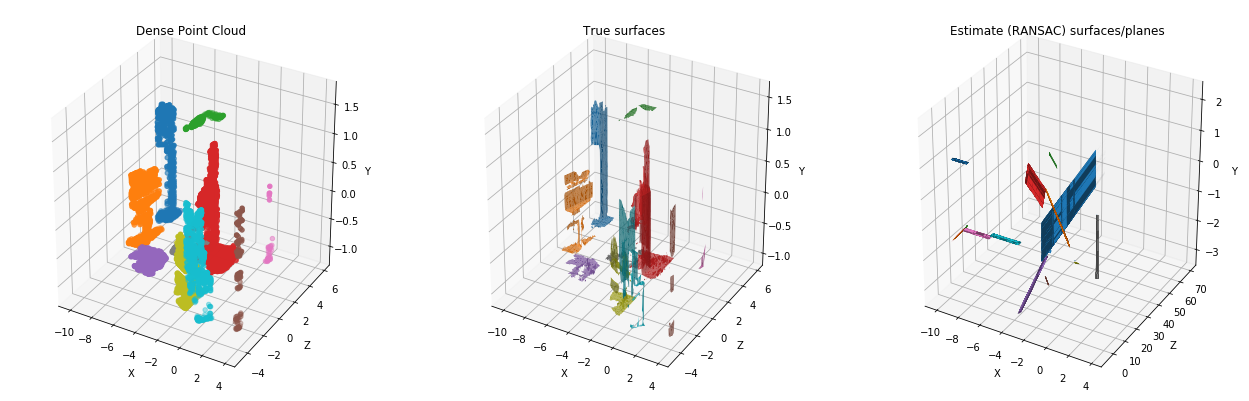

In [290]:
# pointCollection --> object_number, vertices, vertex normals, polygons
#print(len(pointCollection),len(pointCollection[0]))

fig=plt.figure(figsize=(22, 7)) ##fig=plt.figure(figsize=(80, 80))

Planes_to_find = 100 # number of planes to find
threshold = 0.001     # the point-plane distance threshold
R_trials = 100       # the number of RANSAC trials

planeCollection = []
test_max = 10

ax0 = fig.add_subplot(1,3,1, projection='3d')
ax0.set_xlabel('X')
ax0.set_ylabel('Z')
ax0.set_zlabel('Y')
ax0.set_title('Dense Point Cloud')

ax1 = fig.add_subplot(1,3,2, projection='3d')
ax1.set_xlabel('X')
ax1.set_ylabel('Z')
ax1.set_zlabel('Y')
ax1.set_title('True surfaces')

ax2 = fig.add_subplot(1,3,3, projection='3d')
ax2.set_xlabel('X')
ax2.set_ylabel('Z')
ax2.set_zlabel('Y')
ax2.set_title('Estimate (RANSAC) surfaces/planes')

for object_name, pointCloud, _vn, triangles in pointCollection[5:15]:
    
    t0 = time.time()
    pointCloud = np.asarray(pointCloud)
    triangles = np.asarray(triangles)#-vertices_length
    
    planes = []
    depletable_pc = np.copy(pointCloud)
    print(object_name,len(depletable_pc))

    for i_plane in np.arange(Planes_to_find):
        #pass
        bestPoints = []
        #neighbours, _ = getEuclideanNearestNeighbours(depletable_pc,2)
        #print(object_name,i_plane,len(depletable_pc))
        if len(depletable_pc) < 3:
            continue
        for i_trials in np.arange(R_trials):
            sample = np.random.randint(len(depletable_pc))
            testPlane = [depletable_pc[sample],
                         np.cross(depletable_pc[sample-2]-depletable_pc[sample],
                                 depletable_pc[sample-1]-depletable_pc[sample]
                                 )]
            testPoints = []
            d = -testPlane[0].dot(testPlane[1])
            for i, point in enumerate(depletable_pc):
                if ((np.dot(testPlane[1],point)+d)*1.0/LA.norm(testPlane[1],ord = 2)) < threshold:
                    testPoints.append(i)                
            if len(testPoints) > len(bestPoints):
                bestPlane = testPlane
                bestPoints = testPoints
                
        #print(object_name,i_plane,len(depletable_pc),bestPlane)
        planes.append([bestPlane, depletable_pc[bestPoints]])
        depletable_pc = np.delete(depletable_pc,bestPoints,0)

    print("Time to extract planes: ", time.time() - t0)
    planeCollection.append([object_name, planes])
    
    X = pointCloud[:,0]
    Y = pointCloud[:,1]
    Z = pointCloud[:,2]
    #vertices_length += len(X)
    #im = ax.scatter(X,Y,Z, c = object_name*3*np.ones(pointCloud.shape[0]))
    color = (object_name%256,object_name%127,object_name%63)
    #print(object_name,len(X),triangles.min(),triangles.max())
    try:
        ax0.scatter(X,-Z,Y)
        ax1.plot_trisurf(X, -Z, Y, triangles=triangles)#, cmap=plt.cm.Spectral)
    except:
        pass
    
    for plane, points in planes:
        d = -plane[0].dot(plane[1])
        
        try:
            phi = math.fabs(plane[1][1]* 1./LA.norm(plane[1])) # y/r
            #print("Angle = ", angle)
            ax2.quiver(plane[0][0], -plane[0][2], plane[0][1],
                       plane[1][0], -plane[1][2], plane[1][1])
            if math.degrees(math.acos(phi)) < 45 : # arc-cos(y/r) = phi < 45 --> horizontal
                # use floor (plane x-z) as origin mesh
                print("horizontal",plane[1], math.degrees(math.acos(phi)))
                
                # create x,y (actually z in pointcloud, y in matplotlib)
                xx, zz = np.meshgrid(points[:,0], -points[:,2])
                # calculate corresponding z
                y = (-plane[1][0] * xx - plane[1][2] * zz - d) * 1. /plane[1][1]
                # plot the surface
                ax2.plot_surface(xx, zz, y)
            else: #use vertical wall x-y as origin mesh
                print("vertical", plane[1], math.degrees(math.acos(phi)))
                # create x,y (actually z in pointcloud, y in matplotlib)
                xx, yy = np.meshgrid(points[:,0], points[:,1])

                # calculate corresponding z
                z = (-plane[1][0] * xx - plane[1][1] * yy - d) * 1. /plane[1][2]
                # plot the surface
                ax2.plot_surface(xx, -z, yy)
        except:
            pass

plt.show()


In [ ]:
point  = np.array([1, 2, 3])
normal = np.array([1, 1, 2])

# a plane is a*x+b*y+c*z+d=0
# [a,b,c] is the normal. Thus, we have to calculate
# d and we're set
d = -point.dot(normal)

# create x,y
xx, yy = np.meshgrid(range(10), range(10))

# calculate corresponding z
z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

# plot the surface
plt3d = plt.figure().gca(projection='3d')
plt3d.plot_surface(xx, yy, z)
plt.show()

# Below are the points from ARCore
Testing it if we are getting the correct interpretation even with low expressiveness (and confidence) from the created point cloud.

In [68]:
pointCloudFile = open('point_cloud-Sep-18-2018.obj')#('SpatialMesh.obj')#

pointCloudLines = pointCloudFile.readlines()

In [69]:
pointCollection = [] # object_number, vertices, vertex normals, polygons

pointCollection_no_objects = [[],[],[]] 
prev_length = 0
vertices_length = 1

for line in pointCloudLines:
    
    if line == '\n': continue

    line_items = line.split()
    
    if line_items[0] == 'v':
        x = line_items[1]
        y = line_items[2]
        z = line_items[3]
        if len(line_items)> 4:
            c = line_items[4]
            if float(c) > 0:
                #pointCollection[0][1].append([float(x),float(y),float(z),float(c)])
                pointCollection_no_objects[0].append([float(x),float(y),float(z),float(c)])
        else:
            #pointCollection[object_number-1][1].append([float(x),float(y),float(z)])
            pointCollection_no_objects[0].append([float(x),float(y),float(z)])    

pointCloudFile.close

pointCloud_arcore = np.asarray(pointCollection_no_objects[0])
pointcloudnn, difference  = getEuclideanNearestNeighbours(pointCloud_arcore,3)
print(pointCloud_arcore.shape)

<function TextIOWrapper.close>

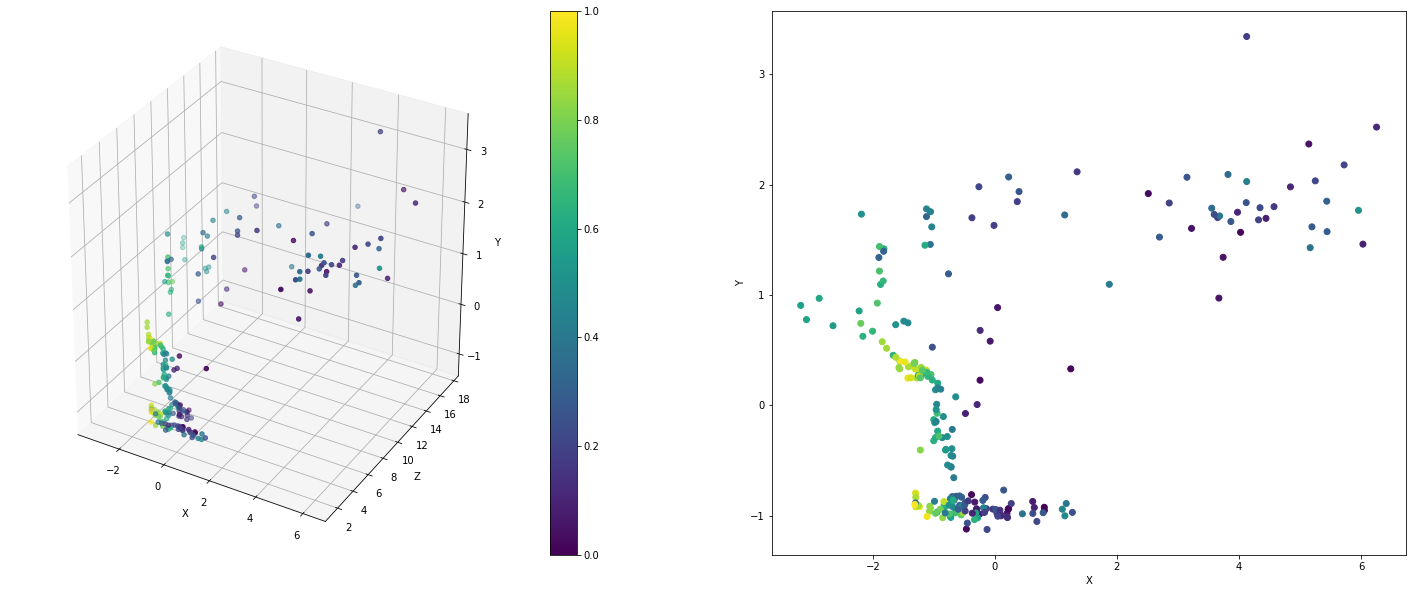

In [87]:
fig=plt.figure(figsize=(25, 10))


ax = fig.add_subplot(121, projection='3d')

#vertices_length = 1

#pointCloud = np.asarray(pointCloud)
#triangles = np.asarray(triangles)#-vertices_length

X = pointCloud_arcore[:,0]
Y = pointCloud_arcore[:,1]
Z = pointCloud_arcore[:,2]
C = pointCloud_arcore[:,3]
#vertices_length += len(X)
im = ax.scatter(xs=X,ys=-Z,zs=Y, c = C)
        
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

# Add a colorbar
fig.colorbar(im, ax=ax)
# set the color limits - not necessary here, but good to know how.
im.set_clim(0.0, 1.0)

ax2 = fig.add_subplot(122)
ax2.scatter(X,Y, c = C)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')

plt.show()

In [88]:
surfaces_delaunay = Delaunay(pointCloud_arcore[:,:2])
triangles=surfaces_delaunay.simplices

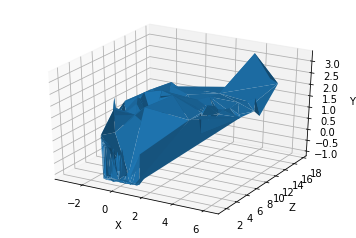

In [89]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')

# The triangles in parameter space determine which x, y, z points are
# connected by an edge
#ax.plot_trisurf(x, y, z, triangles=tri.triangles, cmap=plt.cm.Spectral)
ax.plot_trisurf(X, -Z, Y)#, triangles=triangles, cmap=plt.cm.Spectral)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

plt.show()

In [30]:
triangles[1]

array([60, 39, 40], dtype=int32)

In [31]:
pointCloud_arcore[triangles[1]]

array([[-54.64224625,  -6.20973635, -78.36937714,   0.87131578],
       [-52.48039246,   9.36611271, -67.95469666,   0.87451386],
       [-55.35603333,  10.65515614, -73.51652527,   0.87242764]])

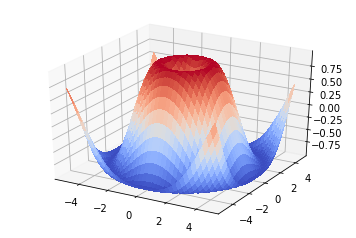

In [42]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm,
                       linewidth=0, antialiased=False)

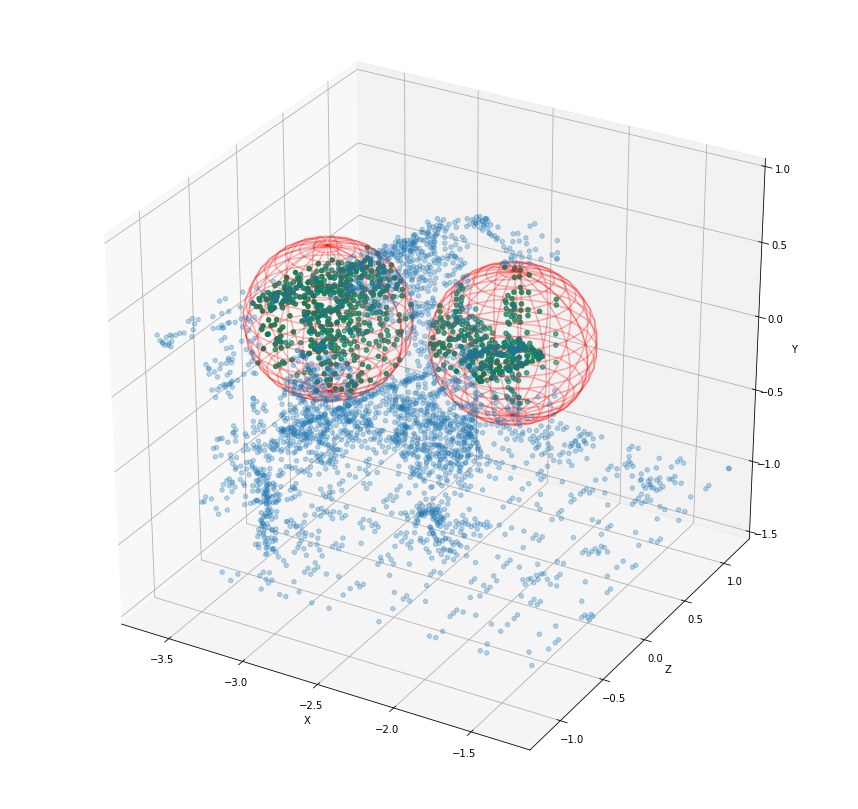

In [130]:
# plotting the partial
fig=plt.figure(figsize=(15, 14.5)) ##fig=plt.figure(figsize=(80, 80))

radius = 0.5

sample_pointCloud = centeredPointCollection[3][1]
sample_triangles = centeredPointCollection[3][2]

partial_pointcloud, partial_triangles, original_vertex = getPartialPointCloud(sample_pointCloud,sample_triangles,radius)
partial_pointcloud2, partial_triangles, original_vertex2 = getPartialPointCloud(sample_pointCloud,sample_triangles,radius)

#t_pointCloud, t_triangles, _ = getQuantizedPointCloud(sample_pointCloud,sample_triangles)
t_pointCloud = sample_pointCloud
t_triangles = sample_triangles

#p_pointCloud, p_triangles, _ = getQuantizedPointCloud(partial_pointcloud,partial_triangles)
#p_pointCloud = gen_pointCloud
#p_triangles = gen_triangles

down_resolution = 20 #np.arange(1,70)#0,110,10)#,30)

planeCollection = []
test_max = 10

ax0 = fig.add_subplot(1,1,1, projection='3d')
ax0.set_xlabel('X')
ax0.set_ylabel('Z')
ax0.set_zlabel('Y')
ax0.set_zlim(-1.5,1)
#ax0.set_title('Dense Point Cloud')

X = t_pointCloud[:,0]
Y = t_pointCloud[:,1]
Z = t_pointCloud[:,2]

PX = partial_pointcloud[:,0]
PY = partial_pointcloud[:,1]
PZ = partial_pointcloud[:,2]

ax0.set_xlim(min(X), max(X))
ax0.set_ylim(min(-Z), max(-Z))

try:
    ax0.scatter(X,-Z,Y,alpha = 0.3)

    #ax0.plot_trisurf(X, -Z, Y, triangles=t_triangles, cmap=plt.cm.Spectral)

    #ax2.quiver(X, -Z, Y,
    #           t_pointCloud[:,3], -t_pointCloud[:,5], t_pointCloud[:,4],length=0.1)#, cmap=plt.cm.Spectral)

    #ax3.scatter(PX,-PZ,PY,alpha = 0.2)

    #ax4.plot_trisurf(PX, -PZ, PY, triangles=p_triangles, cmap=plt.cm.Spectral)

    # draw sphere
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:20j]
    sx = np.cos(u)*np.sin(v)*radius+original_vertex[0]
    sy = np.sin(u)*np.sin(v)*radius+original_vertex[2]
    sz = np.cos(v)*radius+original_vertex[1]
    #ax3.scatter(original_vertex[0],-original_vertex[2],original_vertex[1],color='g')
    ax0.scatter(PX,-PZ,PY,color='g')
    ax0.plot_wireframe(sx, -sy, sz, color="r",alpha=0.3)
    
    PX = partial_pointcloud2[:,0]
    PY = partial_pointcloud2[:,1]
    PZ = partial_pointcloud2[:,2]

    sx = np.cos(u)*np.sin(v)*radius+original_vertex2[0]
    sy = np.sin(u)*np.sin(v)*radius+original_vertex2[2]
    sz = np.cos(v)*radius+original_vertex2[1]
    #ax3.scatter(original_vertex[0],-original_vertex[2],original_vertex[1],color='g')
    ax0.scatter(PX,-PZ,PY,color='g')
    ax0.plot_wireframe(sx, -sy, sz, color="r",alpha=0.3)
except Exception as ex:
    print(ex)
    pass

plt.show()

In [150]:
# Getting multiple generalizations and getting their properties

iterations = 10
ransac_gen_properties = []

newManyGeneralizedPointCollection = []

for obj_name, pointCloud, triangles in new_centered_point_collection:

    obj_plane_properties = []
    
    generalizations = []
    
    for iteration in np.arange(iterations):
        gen_planes, gen_plane_properties = GetRansacPlanes(pointCloud,triangles)
        
        obj_plane_properties.append([
            len(gen_planes),
            gen_plane_properties
        ])
        
        generalizations.append([
            gen_planes,
            gen_plane_properties
        ])
        
        if iteration % 3 == 0:
            print("Done: Obj {}, Iteration {}".format(obj_name,iteration))
        
    newManyGeneralizedPointCollection.append([
        obj_name,
        generalizations
    ])
    ransac_gen_properties.append([
        obj_plane_properties
    ])
    
    with open('new_ransac_generalizations.pickle','wb') as f:
        pickle.dump(newManyGeneralizedPointCollection,f)
    
    with open('new_ransac_gen_properties3.pickle','wb') as f:
        pickle.dump(ransac_gen_properties,f)

/Users/deg032/Projects/3D/generalizations.py:88: RuntimeWarning: invalid value encountered in double_scalars
  if abs(np.dot(testPlane[1],point[3:])/(LA.norm(testPlane[1])*LA.norm(point[3:]))) > (normal_threshold_multiplier*threshold):


Done: Obj Reception-Data61-L5.obj1, Iteration 0
Done: Obj Reception-Data61-L5.obj1, Iteration 3


/Users/deg032/Projects/3D/generalizations.py:84: RuntimeWarning: invalid value encountered in double_scalars
  if abs((np.dot(testPlane[1],point[:3])+d)*1.0/LA.norm(testPlane[1],ord = 2)) < threshold:


Done: Obj Reception-Data61-L5.obj1, Iteration 6
Done: Obj Reception-Data61-L5.obj1, Iteration 9
Done: Obj Reception-Data61-L5.obj2, Iteration 0
Done: Obj Reception-Data61-L5.obj2, Iteration 3
Done: Obj Reception-Data61-L5.obj2, Iteration 6
Done: Obj Reception-Data61-L5.obj2, Iteration 9
Done: Obj Reception-Data61-L5.obj3, Iteration 0
Done: Obj Reception-Data61-L5.obj3, Iteration 3
Done: Obj Reception-Data61-L5.obj3, Iteration 6
Done: Obj Reception-Data61-L5.obj3, Iteration 9
Done: Obj Reception-Data61-L5.obj4, Iteration 0
Done: Obj Reception-Data61-L5.obj4, Iteration 3
Done: Obj Reception-Data61-L5.obj4, Iteration 6
Done: Obj Reception-Data61-L5.obj4, Iteration 9
Done: Obj Reception-Data61-L5.obj6, Iteration 0
Done: Obj Reception-Data61-L5.obj6, Iteration 3
Done: Obj Reception-Data61-L5.obj6, Iteration 6
Done: Obj Reception-Data61-L5.obj6, Iteration 9
Done: Obj Reception-Data61-L5.obj7, Iteration 0
Done: Obj Reception-Data61-L5.obj7, Iteration 3
Done: Obj Reception-Data61-L5.obj7, Iter

Done: Obj Kitchen-Data61-L4.obj14, Iteration 6
Done: Obj Kitchen-Data61-L4.obj14, Iteration 9
Done: Obj Kitchen-Data61-L4.obj15, Iteration 0
Done: Obj Kitchen-Data61-L4.obj15, Iteration 3
Done: Obj Kitchen-Data61-L4.obj15, Iteration 6
Done: Obj Kitchen-Data61-L4.obj15, Iteration 9
Done: Obj Kitchen-Data61-L4.obj17, Iteration 0
Done: Obj Kitchen-Data61-L4.obj17, Iteration 3
Done: Obj Kitchen-Data61-L4.obj17, Iteration 6
Done: Obj Kitchen-Data61-L4.obj17, Iteration 9
Done: Obj Kitchen-Data61-L4.obj18, Iteration 0
Done: Obj Kitchen-Data61-L4.obj18, Iteration 3
Done: Obj Kitchen-Data61-L4.obj18, Iteration 6
Done: Obj Kitchen-Data61-L4.obj18, Iteration 9
Done: Obj HallWayToKitchen-Data61-L4.obj1, Iteration 0
Done: Obj HallWayToKitchen-Data61-L4.obj1, Iteration 3
Done: Obj HallWayToKitchen-Data61-L4.obj1, Iteration 6
Done: Obj HallWayToKitchen-Data61-L4.obj1, Iteration 9
Done: Obj HallWayToKitchen-Data61-L4.obj2, Iteration 0
Done: Obj HallWayToKitchen-Data61-L4.obj2, Iteration 3
Done: Obj Ha

In [105]:
ransac_gen_properties

[[[[6, array([[5.13207029e+00, 5.14996844e+02],
           [4.18351711e+00, 6.04754309e+01],
           [3.26306312e+00, 7.96797337e+01],
           [4.68933359e-01, 3.11344879e+02],
           [7.92823012e-01, 9.08147202e+01],
           [2.98078095e-01, 2.01289531e+02]])],
   [7, array([[5.13214536e+00, 5.20445118e+02],
           [4.14760445e+00, 5.30426665e+01],
           [1.11441500e+00, 2.09975638e+02],
           [4.68933359e-01, 3.11344879e+02],
           [4.59982192e-01, 1.60875793e+02],
           [2.94839804e-01, 2.03500339e+02],
           [6.88410782e-01, 3.63155265e+01]])],
   [6, array([[5.13161758e+00, 5.32970346e+02],
           [1.39902033e+00, 1.72263400e+02],
           [4.40420096e+00, 3.47395592e+01],
           [4.70553775e-01, 3.14523032e+02],
           [4.54457566e-01, 1.95837866e+02],
           [2.70947198e-01, 2.14063849e+02]])],
   [7, array([[5.13204498e+00, 5.20260444e+02],
           [3.41071597e+00, 5.89319080e+01],
           [5.20954227e-01, 2.8985

In [47]:
# Getting multiple generalizations and getting their properties

iterations = 10

manyGeneralizedPointCollection_no_objects = []

for pointCloud, normals, triangles in [pointCollection_no_objects]:
        
    pointCloud = np.concatenate((pointCloud,normals),axis = 1)
    
    for iteration in np.arange(iterations):
        gen_planes, gen_plane_properties = getRansacPlanes(pointCloud,triangles)
        
        obj_plane_properties.append([
            len(gen_planes),
            gen_plane_properties
        ])
        
        manyGeneralizedPointCollection_no_objects.append([
            gen_planes,
            gen_plane_properties
        ])
        
        print("Iteration {}".format(obj_name,iteration))
        
        with open('ransac_generalizations_no_objects.pickle','wb') as f:
            pickle.dump(manyGeneralizedPointCollection_no_objects,f)        
    

/Users/deg032/Projects/3D/info3d.py:293: RuntimeWarning: invalid value encountered in double_scalars
  if abs(np.dot(testPlane[1],point[3:])/(LA.norm(testPlane[1])*LA.norm(point[3:]))) > (normal_threshold_multiplier*threshold):
/Users/deg032/Projects/3D/info3d.py:289: RuntimeWarning: invalid value encountered in double_scalars
  if abs((np.dot(testPlane[1],point[:3])+d)*1.0/LA.norm(testPlane[1],ord = 2)) < threshold:


Iteration 38
Iteration 38
Iteration 38
Iteration 38
Iteration 38
Iteration 38
Iteration 38
Iteration 38
Iteration 38
Iteration 38


In [12]:
with open('ransac_gen_properties2.pickle','wb') as f:
    pickle.dump(ransac_gen_properties,f)

In [21]:
for 

(73215, 3)

In [23]:
np.asarray(pointCollection_no_objects[1]).shape

(73215, 3)

In [22]:
np.asarray(pointCollection_no_objects[2]).shape

(121972, 3)

In [34]:
len(manyGeneralizedPointCollection[0])

2

In [14]:
with open('ransac_generalizations.pickle','rb') as f:
    RmanyGeneralizedPointCollection = pickle.load(f)   

In [33]:
#with open('ransac_plane_generalizations.pickle','wb') as f:
#    pickle.dump(RmanyGeneralizedPointCollection,f)

In [15]:
many_ransac_generalizedPointCollection = []

for obj, generalizations in RmanyGeneralizedPointCollection:
    
    obj_generalizedPointCollection = []
    
    for gen_planes, gen_properties in generalizations:
        genPointCloud, genTriangles = getGeneralizedPointCloud(
            gen_planes, 
            gen_properties
        )
        
        obj_generalizedPointCollection.append([
            genPointCloud,
            genTriangles
        ])
        
    many_ransac_generalizedPointCollection.append([
        obj,
        obj_generalizedPointCollection
    ])
    
#with open('many_ransac_generalizedPointCollection.pickle','wb') as f:
#    pickle.dump(many_ransac_generalizedPointCollection,f)

In [48]:
many_ransac_generalizedPointCollection_no_objects = []

for gen_planes, gen_properties in manyGeneralizedPointCollection_no_objects:
    
    genPointCloud, genTriangles = getGeneralizedPointCloud(
        gen_planes, 
        gen_properties
    )

    many_ransac_generalizedPointCollection_no_objects.append([
        genPointCloud,
        genTriangles
    ])
    
#with open('many_ransac_generalizedPointCollection_no_objects.pickle','wb') as f:
#    pickle.dump(many_ransac_generalizedPointCollection_no_objects,f)

4 (2422, 6) (4603, 3)
Got the true descriptors (92, 200) (92, 6)


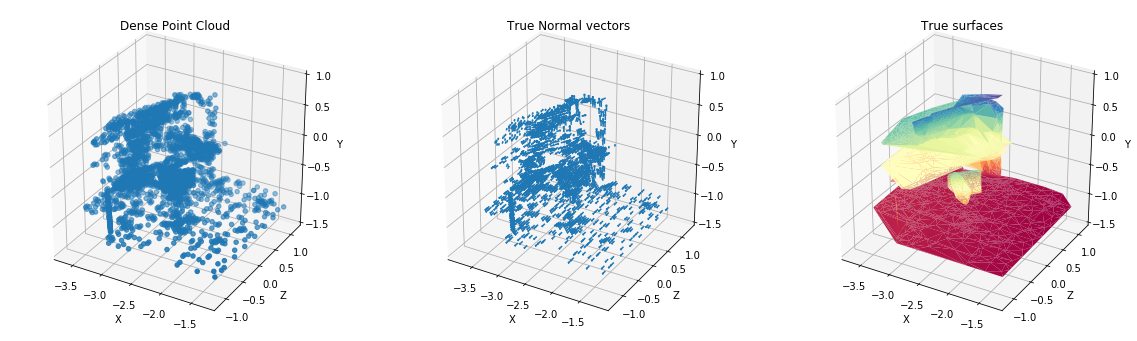

In [10]:
# pointCollection --> object_number, vertices, vertex normals, polygons
space = 3
sample = 9

fig=plt.figure(figsize=(20, 20)) ##fig=plt.figure(figsize=(80, 80))

descriptor_resolution = 10

ax0 = fig.add_subplot(3,3,1, projection='3d')
ax0.set_xlabel('X')
ax0.set_ylabel('Z')
ax0.set_zlabel('Y')
ax0.set_zlim(-1.5,1)
ax0.set_title('Dense Point Cloud')

ax1 = fig.add_subplot(3,3,3, projection='3d')
ax1.set_xlabel('X')
ax1.set_ylabel('Z')
ax1.set_zlabel('Y')
ax1.set_zlim(-1.5,1)
ax1.set_title('True surfaces')

ax4 = fig.add_subplot(3,3,2, projection='3d')
ax4.set_xlabel('X')
ax4.set_ylabel('Z')
ax4.set_zlabel('Y')
ax4.set_zlim(-1.5,1)
ax4.set_title('True Normal vectors')

object_name =  many_ransac_generalizedPointCollection[space][0]
pointCloud = np.asarray(many_ransac_generalizedPointCollection[space][1][sample][0])
triangles = np.asarray(many_ransac_generalizedPointCollection[space][1][sample][1])

#pointCloud = np.concatenate((pointCloud,normals),axis = 1)

print(object_name,pointCloud.shape, triangles.shape)

t0 = time.time()

#t_pointCloud = np.asarray(np.copy(pointCloud))
#t_triangles = np.asarray(triangles)#-vertices_length
#t_pointCloud, t_triangles, t_p_ = getQuantizedPointCloud(pointCloud,triangles,descriptor_resolution)

try:
    t_descriptors, t_keypoints, t_d_c = getSpinImageDescriptors(pointCloud)
    print("Got the true descriptors",t_descriptors.shape,t_keypoints.shape)
except Exception as ex:
    print(ex)
    print("Error getting the true descriptors of",object_name,"with size",t_pointCloud.shape)

#t_pointCloud[:,:3] = t_pointCloud[:,:3]*resolution+2.5*resolution

X = pointCloud[:,0]
Y = pointCloud[:,1]
Z = pointCloud[:,2]

ax0.set_xlim(min(X), max(X))
ax0.set_ylim(min(-Z), max(-Z))
ax1.set_xlim(min(X), max(X))
ax1.set_ylim(min(-Z), max(-Z))

try:
    imT = ax0.scatter(X,-Z,Y)#,c=t_l_s_[:,-1])
    #imT.set_clim(0.0, 1.0)
    #cbarT = fig.colorbar(imT, ax=ax0)
    #cbarT.ax.set_ylabel('Local self-similarity ({} neighbors)'.format(len(t_k_[0])))

    ax1.plot_trisurf(X, -Z, Y, triangles=triangles, cmap=plt.cm.Spectral)

    ax4.quiver(X, -Z, Y,
               pointCloud[:,3], -pointCloud[:,4], pointCloud[:,5],length=0.1)#, cmap=plt.cm.Spectral)

except Exception as ex:
    print(ex)
    pass

In [6]:
with open('many_ransac_generalizedPointCollection.pickle','rb') as f:
    many_ransac_generalizedPointCollection = pickle.load(f)

30 (4688, 6) (9039, 3)


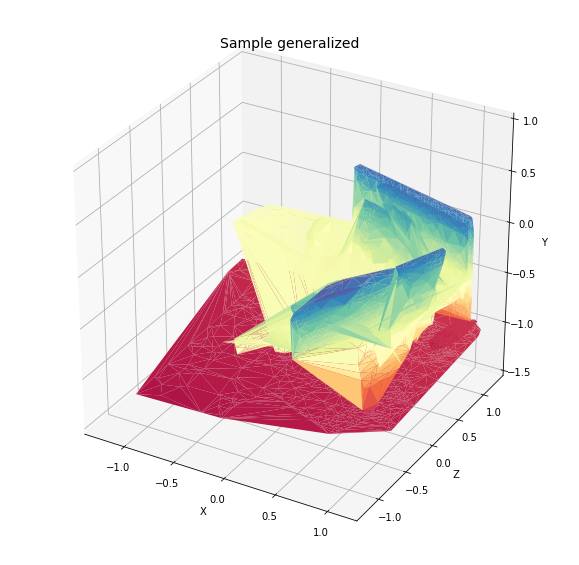

In [11]:
# pointColection --> object_number, vertices, vertex normals, polygons
space = 29
sample = 1

fig=plt.figure(figsize=(10, 10)) ##fig=plt.figure(figsize=(80, 80))

descriptor_resolution = 10

ax0 = fig.add_subplot(1,1,1, projection='3d')
ax0.set_xlabel('X')
ax0.set_ylabel('Z')
ax0.set_zlabel('Y')
ax0.set_zlim(-1.5,1)
ax0.set_title('Sample generalized', fontsize = 14)

object_name =  many_ransac_generalizedPointCollection[space][0]
pointCloud = np.asarray(many_ransac_generalizedPointCollection[space][1][sample][0])
triangles = np.asarray(many_ransac_generalizedPointCollection[space][1][sample][1])

#pointCloud = np.concatenate((pointCloud,normals),axis = 1)

print(object_name,pointCloud.shape,  triangles.shape)#normals.shape,

t0 = time.time()

#t_pointCloud = np.asarray(np.copy(pointCloud))
#t_triangles = np.asarray(triangles)#-vertices_length
#t_pointCloud, t_triangles, t_p_ = getQuantizedPointCloud(pointCloud,triangles,descriptor_resolution)

#try:
#    t_descriptors, t_keypoints, t_d_c = getSpinImageDescriptors(pointCloud)
#    print("Got the true descriptors",t_descriptors.shape,t_keypoints.shape)
#except Exception as ex:
#    print(ex)
#    print("Error getting the true descriptors of",object_name,"with size",t_pointCloud.shape)

#t_pointCloud[:,:3] = t_pointCloud[:,:3]*resolution+2.5*resolution

X = pointCloud[:,0]
Y = pointCloud[:,1]
Z = pointCloud[:,2]

ax0.set_xlim(min(X), max(X))
ax0.set_ylim(min(-Z), max(-Z))

try:
    #imT = ax0.scatter(X,-Z,Y)#,c=t_l_s_[:,-1])
    #imT.set_clim(0.0, 1.0)
    #cbarT = fig.colorbar(imT, ax=ax0)
    #cbarT.ax.set_ylabel('Local self-similarity ({} neighbors)'.format(len(t_k_[0])))

    ax0.plot_trisurf(X, -Z, Y, triangles=triangles, cmap=plt.cm.Spectral)

    #ax4.quiver(X, -Z, Y,
    #           pointCloud[:,3], -pointCloud[:,4], pointCloud[:,5],length=0.1)#, cmap=plt.cm.Spectral)

except Exception as ex:
    print(ex)
    pass

In [46]:
many_ransac_descriptors = []

for obj, generalizations in many_ransac_generalizedPointCollection:
    obj_descriptors = []
    
    for i, pointCollection in enumerate(generalizations):
        
        try:
            t_descriptors, t_keypoints, t_d_c = getSpinImageDescriptors(pointCollection[0])
            #print("Got the true descriptors",t_descriptors.shape,t_keypoints.shape)
        except Exception as ex:
            print(ex)
            print("Error getting the true descriptors of",object_name,"with size",t_pointCloud.shape)
        
        obj_descriptors.append([
            t_descriptors,
            t_keypoints,
            t_d_c
        ])
        
        if i%3 == 0:
            print("Done {}: Iteration {}".format(obj, i))
        
    many_ransac_descriptors.append([
        obj,
        obj_descriptors
    ])
    
    with open('many_ransac_descriptors.pickle','wb') as f:
        pickle.dump(many_ransac_descriptors,f)


Done 1: Iteration 0
Done 1: Iteration 3
Done 1: Iteration 6
Done 1: Iteration 9
Done 2: Iteration 0
Done 2: Iteration 3
Done 2: Iteration 6
Done 2: Iteration 9
Done 3: Iteration 0
Done 3: Iteration 3
Done 3: Iteration 6
Done 3: Iteration 9
Done 4: Iteration 0
Done 4: Iteration 3
Done 4: Iteration 6
Done 4: Iteration 9
Done 5: Iteration 0
Done 5: Iteration 3
Done 5: Iteration 6
Done 5: Iteration 9
Done 6: Iteration 0
Done 6: Iteration 3
Done 6: Iteration 6
Done 6: Iteration 9
Done 7: Iteration 0
Done 7: Iteration 3
Done 7: Iteration 6
Done 7: Iteration 9
Done 8: Iteration 0
Done 8: Iteration 3
Done 8: Iteration 6
Done 8: Iteration 9
Done 9: Iteration 0
Done 9: Iteration 3
Done 9: Iteration 6
Done 9: Iteration 9
Done 10: Iteration 0
Done 10: Iteration 3
Done 10: Iteration 6
Done 10: Iteration 9
Done 11: Iteration 0
Done 11: Iteration 3
Done 11: Iteration 6
Done 11: Iteration 9
Done 12: Iteration 0
Done 12: Iteration 3
Done 12: Iteration 6
Done 12: Iteration 9
Done 13: Iteration 0
Done 13

In [49]:
many_ransac_descriptors_no_objects = []

for i, pointCollection in enumerate(many_ransac_generalizedPointCollection_no_objects):
            
    try:
        t_descriptors, t_keypoints, t_d_c = getSpinImageDescriptors(pointCollection[0])
        #print("Got the true descriptors",t_descriptors.shape,t_keypoints.shape)
    except Exception as ex:
        print(ex)
        print("Error getting the true descriptors of",object_name,"with size",pointCollection[0].shape)


    print("Done with Iteration {}".format(i))
        
    many_ransac_descriptors_no_objects.append([
        t_descriptors,
        t_keypoints,
        t_d_c
    ])
    
    with open('many_ransac_descriptors_no_objects.pickle','wb') as f:
        pickle.dump(many_ransac_descriptors_no_objects,f)


Done with Iteration 0
Done with Iteration 1
Done with Iteration 2
Done with Iteration 3
Done with Iteration 4
Done with Iteration 5
Done with Iteration 6
Done with Iteration 7
Done with Iteration 8
Done with Iteration 9


In [51]:
descriptors_no_objects = []

pointCloud_no_objects = np.concatenate(
    (pointCollection_no_objects[0],pointCollection_no_objects[1]),
    axis = 1
)

print(pointCloud_no_objects.shape)

try:
    t_descriptors, t_keypoints, t_d_c = getSpinImageDescriptors(pointCloud_no_objects)
    #print("Got the true descriptors",t_descriptors.shape,t_keypoints.shape)
except Exception as ex:
    print(ex)
    print("Error getting the true descriptors of",object_name,"with size",pointCloud_no_objects[0].shape)


print("Done with Iteration {}".format(i))

descriptors_no_objects = [
    t_descriptors,
    t_keypoints,
    t_d_c
]

with open('descriptors_no_objects.pickle','wb') as f:
    pickle.dump(descriptors_no_objects,f)


(73215, 6)
Done with Iteration 9
